In [2]:
import sys
sys.path.append('../')
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
from systematics_module import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

## systematic test 

In [3]:
import numpy as np
import healpy as hp

In [4]:
from systematics import sys_iteration, fitting_SP, sys_ngal

In [13]:
# calling catalog
#from systematics import GalaxyDensity_Systematics,loadSystematicMaps, chisquare_dof, MatchHPArea, SysMapBadRegionMask, callingEliGoldMask

def calling_sysMap( properties=None, kind='SPT', nside=4096, path = None):
    # Calling maps
    from systematics import callingEliGoldMask,callingY1GoldMask
    GoldMask = callingEliGoldMask()
    #GoldMask = callingY1GoldMask(nside)
    
    MaskDic = {}
    for i,p in enumerate(properties):
        if p == 'NSTARS_allband':
            filename =  'y1a1_gold_1.0.2_stars_nside1024.fits'
            sysMap = loadSystematicMaps( filename = filename, property = p, filter = 'g', nside = 1024 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'GE':
            sysMap = loadSystematicMaps( property = p, filter = 'g', nside = 512 , kind = kind, path = path)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        elif p == 'FWHM_pca':
            filename =  'pca_sysmaps_4096_test_fwhmg_fwhmr_fwhmi_components_spt_s82_fromcoeff_pc0.fits.gz'
            syspath = '/n/des/lee.5922/data/systematic_maps/'
            sysMap = loadSystematicMaps( filename = filename, property = p, path=syspath, filter = 'g', nside = 4096 , kind = kind)
            if kind is 'STRIPE82': sysMap = sysMap[sysMap['DEC'] > -3]
            elif kind is 'SPT': sysMap = sysMap[sysMap['DEC'] < -3]
            mapname = 'sys_'+p+'_'+'g'+'_'+kind
            MaskDic[mapname] = sysMap
            
        else :
            filter = ['g', 'r', 'i', 'z']
            
            if p =='EXPTIME':
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_EXPTIME__total.fits.gz'\
                             for f in filter ]
            elif p =='DEPTH' :
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_maglimit3__.fits.gz'\
                             for f in filter ]
            elif p == 'NSTARS' : 
                filename = ['Y1A1NEW_COADD_'+kind+'_band_'+f+'_nside4096_oversamp4_NSTARS_ACCEPTED_MEAN_coaddweights3_mean.fits.gz'\
                             for f in filter ]
            else : filename = [None for f in filter]

            for j,f in enumerate(filter):
                sysMap = loadSystematicMaps( filename = filename[j], property = p, filter = f, nside = nside , kind = kind, path = path)
                mapname = 'sys_'+p+'_'+f+'_'+kind
                keep = np.in1d(sysMap['PIXEL'], GoldMask['PIXEL'])
                MaskDic[mapname] = sysMap[keep]
                
    return MaskDic

In [14]:
def maskingCatalogSP(catalog=None, sysMap=None):
    
    
    exp_i_hpind = sysMap['sys_EXPTIME_i_SPT']['PIXEL'][(sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 480)]
    fwhm_r_hpind = sysMap['sys_FWHM_r_SPT']['PIXEL'][(sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5)]
    ge_hpind = sysMap['sys_GE_g_SPT']['PIXEL'][(sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.09)]
    skybrite_g_hpind = sysMap['sys_SKYBRITE_g_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 170)]
    skybrite_i_hpind = sysMap['sys_SKYBRITE_i_SPT']['PIXEL'][(sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400)]
    
    all_mask1 = np.zeros( hp.nside2npix(4096), dtype=bool )
    all_mask2 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask3 = np.zeros( hp.nside2npix(4096),dtype=bool )
    all_mask4 = np.zeros( hp.nside2npix(4096),dtype=bool )
    
    all_mask512 = np.zeros( hp.nside2npix(512),dtype=bool )
    
    all_mask1[exp_i_hpind] = 1
    all_mask2[fwhm_r_hpind] = 1
    all_mask3[skybrite_g_hpind] = 1
    all_mask4[skybrite_i_hpind] = 1
    
    all_mask512[ge_hpind] = 1
    
    all_mask4096 = all_mask1 * all_mask2 * all_mask3* all_mask4


    all_ind4096 = np.arange( hp.nside2npix(4096) )
    all_ind512 = np.arange( hp.nside2npix(512) )
    goodindices4096 = all_ind4096[all_mask4096]
    goodindices512 = all_ind512[all_mask512]
  
    
    #goodindices = np.hstack([exp_i_hpind, fwhm_r_hpind, ge_hpind])
    
    #exp_mask =  (sysMap['sys_EXPTIME_i_SPT']['SIGNAL'] < 500) &  (sysMap['sys_EXPTIME_r_SPT']['SIGNAL'] < 500)
    #fwhm_mask = ((sysMap['sys_FWHM_g_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 500) 
    #            & (sysMap['sys_FWHM_i_SPT']['SIGNAL'] < 500) & (sysMap['sys_FWHM_z_SPT']['SIGNAL'] < 500))

    fwhm_mask = (sysMap['sys_FWHM_r_SPT']['SIGNAL'] < 4.5) 
    skybrite_mask = (sysMap['sys_SKYBRITE_g_SPT']['SIGNAL'] < 160) & (sysMap['sys_SKYBRITE_i_SPT']['SIGNAL'] < 1400) \
    &(sysMap['sys_SKYBRITE_z_SPT']['SIGNAL'] < 3000) 
    
    #ge_mask = (sysMap['sys_GE_g_SPT']['SIGNAL'] < 0.08)  
    #all_mask = fwhm_mask*exp_mask*skybrite_mask
    #print 'exp mask ', 1. - np.sum(exp_mask) *1./exp_mask.size
    #print 'fwhm mask', 1. - np.sum(fwhm_mask) *1./fwhm_mask.size
    #print 'skybrite mask', 1. - np.sum(skybrite_mask) *1./skybrite_mask.size
    #print 'all mask', 1. - np.sum(fwhm_mask*exp_mask*skybrite_mask) *1./fwhm_mask.size   

    catHpInd4096 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=4096, nest=False)
    catHpInd512 = hpRaDecToHEALPixel(catalog['RA'], catalog['DEC'], nside=512, nest=False)
    HpIdxInsys_mask4096 = np.in1d(catHpInd4096, goodindices4096)
    HpIdxInsys_mask512 = np.in1d(catHpInd512, goodindices512)
    
    HpIdxInsys_mask = HpIdxInsys_mask4096 * HpIdxInsys_mask512
    
    print HpIdxInsys_mask.size, np.sum(HpIdxInsys_mask)
    print 'mask ', np.sum(HpIdxInsys_mask) * 1./catalog.size
    return catalog[HpIdxInsys_mask]
    

In [15]:
# calling map 
GoldMask = callingEliGoldMask()
#GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_st82 = GoldMask[ GoldMask['DEC'] > -3.0 ]
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = cutcat20(GoldMask_spt)
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 100, dec=-52, dec2 = -48)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

In [16]:
# import DMASS

dmass = fitsio.read('../output/n2_2/dmass_spt.fits')
#dmass = cutcat20(dmass)
cmass = fitsio.read('../output/n2/dmass_st82.fits')
print 'dmass sample size :', dmass.size
print 'cmass sample size :', cmass.size

dmass sample size : 112398
cmass sample size : 11593


In [17]:
#rand_bg = uniform_random_on_sphere(dmass_spt2, size = 100 * dmass_spt2.size)
#rand_bg = Cuts.keepGoodRegion(rand_bg)
#rand_bg_train = uniform_random_on_sphere(clean_cmass_data_des, size = 100 * clean_cmass_data_des.size)
#rand_bg_train = Cuts.keepGoodRegion(rand_bg_train)

rand = uniform_random_on_sphere(dmass, size = 10 * dmass.size)
rand = Cuts.keepGoodRegion(rand)
#rand = Cuts.keepY1GoldRegion(rand)
rand = rand[ rand['DEC'] < -3.0 ]
#rand = cutcat20(rand)

rand2 = uniform_random_on_sphere(dmass, size = 50 * dmass.size)
rand2 = Cuts.keepGoodRegion(rand2)
#rand = Cuts.keepY1GoldRegion(rand)
rand2 = rand2[ rand2['DEC'] < -3.0 ]
#rand2 = cutcat20(rand2)

rand_cmass = uniform_random_on_sphere(cmass, size = 200 * cmass.size)
rand_cmass = Cuts.keepGoodRegion(rand_cmass)
rand_cmass = rand_cmass[ rand_cmass['DEC'] > -3.0 ]

rand2_cmass = uniform_random_on_sphere(cmass, size = 500 * cmass.size)
rand2_cmass = Cuts.keepGoodRegion(rand2_cmass)
rand2_cmass = rand2_cmass[ rand2_cmass['DEC'] > -3.0 ]

print rand.size, dmass.size
print rand_cmass.size, cmass.size
#rand_train = uniform_random_on_sphere(clean_cmass_data_des, size = 10 * clean_cmass_data_des.size)
#rand_train = Cuts.keepGoodRegion(rand_train)

510014 112398
187665 11593


In [40]:
kind = 'SPT'
FullArea = SPTMaparea
#def CalculteGalaxyNgal(data, ):
#properties = ['DEPTH','EXPTIME']
#properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM', 'NSTARS']
properties = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE','FWHM','FWHM_pca','NSTARS_allband', 'GE']
#properties = ['FWHM']
suffix='no_weight'
# calculating galaxy density and weights iterately

In [20]:
sysMap = calling_sysMap( properties=properties, kind='SPT', nside=4096 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_r_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_i_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_z_nside4096_oversamp4_maglimit3__.fits.gz
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = EXPLICIT

PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
Y1A1NEW_COADD_SPT_band_g_nside4096_oversamp4_EXPTIME__total.fits.gz

In [27]:
dmass_masked = maskingCatalogSP(catalog=dmass, sysMap=sysMap)
rand_masked = maskingCatalogSP(catalog=rand, sysMap=sysMap)
rand2_masked = maskingCatalogSP(catalog=rand2, sysMap=sysMap)

112398 106857
mask  0.9507019697859392
510014 488511
mask  0.9578384122788787
2551747 2443947
mask  0.9577544325515029


In [31]:
inputdir = '../data_txt/systematics/pca/'
figoutdir = '../data_txt/systematics/pca/figure/'
os.system('mkdir '+inputdir)
#os.system('mkdir '+figoutdir)
#os.system('mkdir '+inputdir+'/weights/')
#cp ../data_txt/systematics/2nd/systematic*_no_weight.txt ../data_txt/systematics/pca/.

0

In [46]:
#cp ../data_txt/systematics/3rd/systematic*_wg_ge_g.txt ../data_txt/systematics/pca/.

In [34]:
sys_ngal(cat1 = dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2 = rand2_masked, sysmap = sysMap, 
         FullArea = SPTMaparea, properties = ['FWHM_pca'], kind='SPT', nbins = 15,
         pixelmask = None, reweight=None, nside = 4096,
         suffix='no_weight', outdir=inputdir)

../systematics.py:451: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:455: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:455: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/pca/systematic_FWHM_pca_g_SPT_no_weight.txt


In [ ]:
from systematics_module.contCorrection import doVisualization_ngal

for p in properties : 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix='no_weight', \
                         inputdir=inputdir, outdir=figoutdir)

chi2_null =  50.59984729903779
chi2_mod. =  26.635443901524916
Delta chi2 (sample) = 23.964403397512875
output save to  ../data_txt/systematics/pca/systematic_NSTARS_allband_g_SPT_no_weight.txt.model

chi2_null =  261.98383332699797
chi2_mod. =  31.40650989136384
Delta chi2 (sample) = 230.57732343563413
output save to  ../data_txt/systematics/pca/systematic_GE_g_SPT_no_weight.txt.model

chi2_null =  97.42289703000559
chi2_mod. =  21.811396663974026
Delta chi2 (sample) = 75.61150036603156
output save to  ../data_txt/systematics/pca/systematic_FWHM_pca_g_SPT_no_weight.txt.model

chi2_null =  28.24242235085985
chi2_mod. =  22.571460041641956
Delta chi2 (sample) = 5.670962309217895
output save to  ../data_txt/systematics/pca/systematic_FWHM_g_SPT_no_weight.txt.model

chi2_null =  206.8139164810105
chi2_mod. =  39.86213960972477
Delta chi2 (sample) = 166.95177687128572
output save to  ../data_txt/systematics/pca/systematic_FWHM_r_SPT_no_weight.txt.model

chi2_null =  116.0619414039192
chi2_

(['GE_g',
  'FWHM_r',
  'FWHM_i',
  'SKYBRITE_i',
  'FWHM_pca_g',
  'AIRMASS_r',
  'AIRMASS_z',
  'AIRMASS_i',
  'NSTARS_allband_g',
  'AIRMASS_g',
  'FWHM_z',
  'DEPTH_i',
  'FWHM_g',
  'EXPTIME_g',
  'DEPTH_g',
  'DEPTH_r',
  'EXPTIME_i',
  'EXPTIME_z',
  'SKYBRITE_g',
  'SKYBRITE_z',
  'DEPTH_z',
  'SKYBRITE_r',
  'EXPTIME_r'],
 [230.57732343563413,
  166.95177687128572,
  85.56095616380422,
  78.57005719044274,
  75.61150036603156,
  58.498050439396216,
  52.26310662357321,
  43.69925065144632,
  23.964403397512875,
  21.805957037265284,
  18.241042978002476,
  14.950241166510487,
  5.670962309217895,
  4.211958466111559,
  2.5442512023209716,
  1.8695471648117916,
  0.9285000485214816,
  0.8846034850740097,
  0.5168688003278383,
  0.22682776970761154,
  0.1703245297495286,
  0.16475257384126607,
  0.010291844296382635])

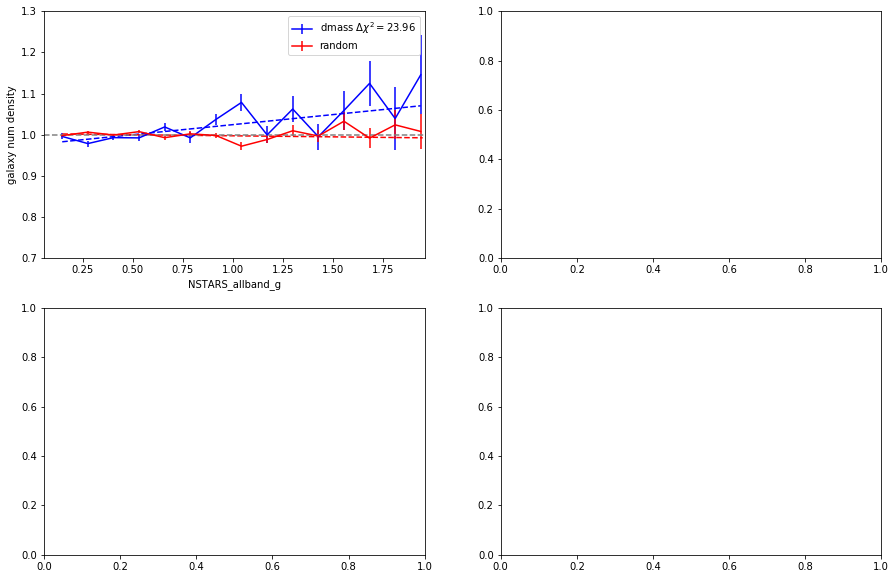

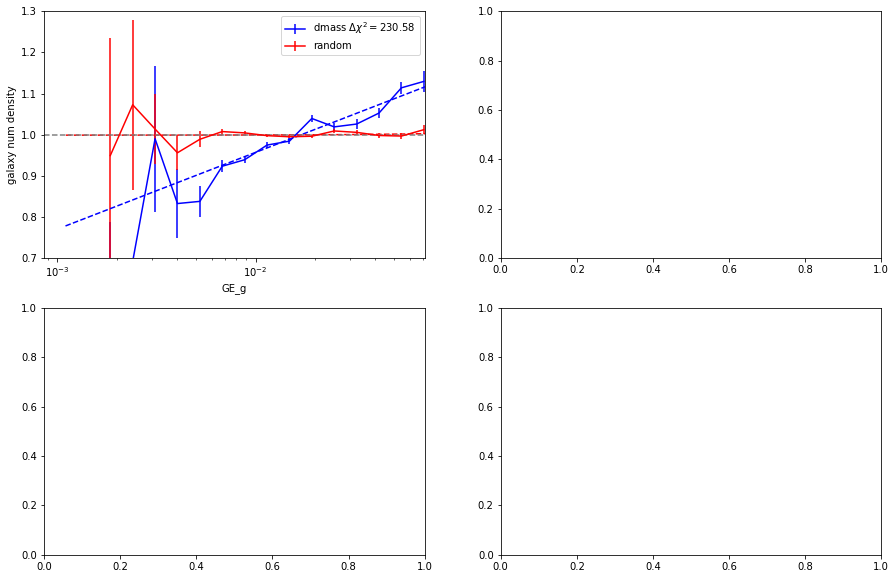

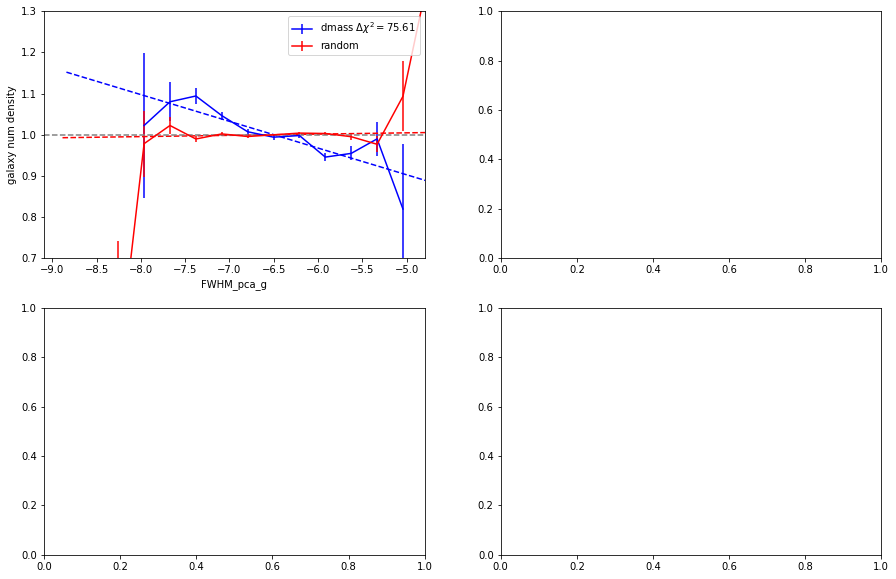

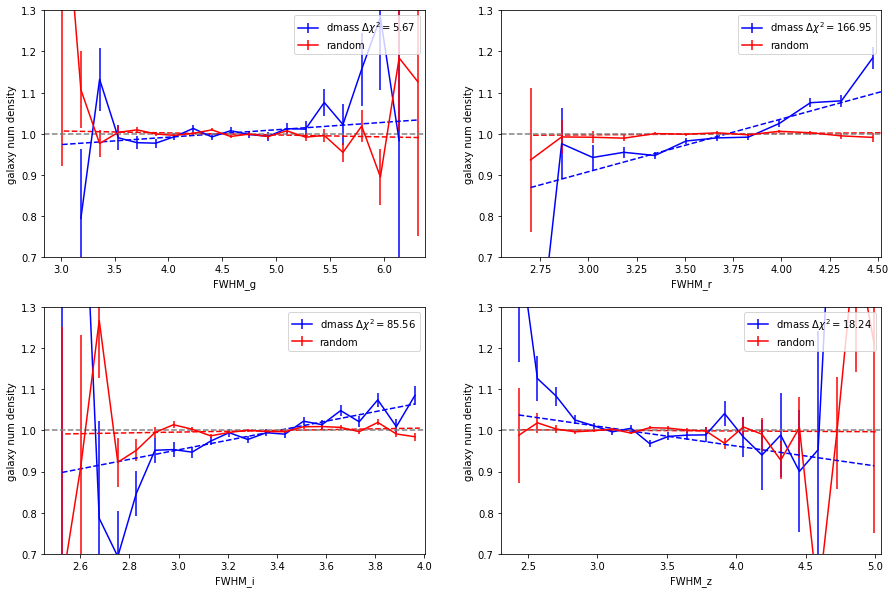

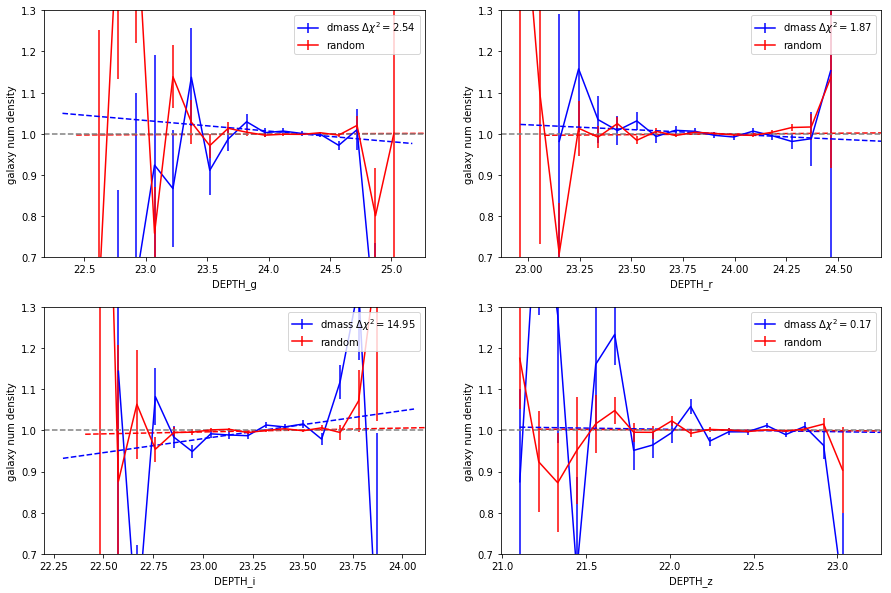

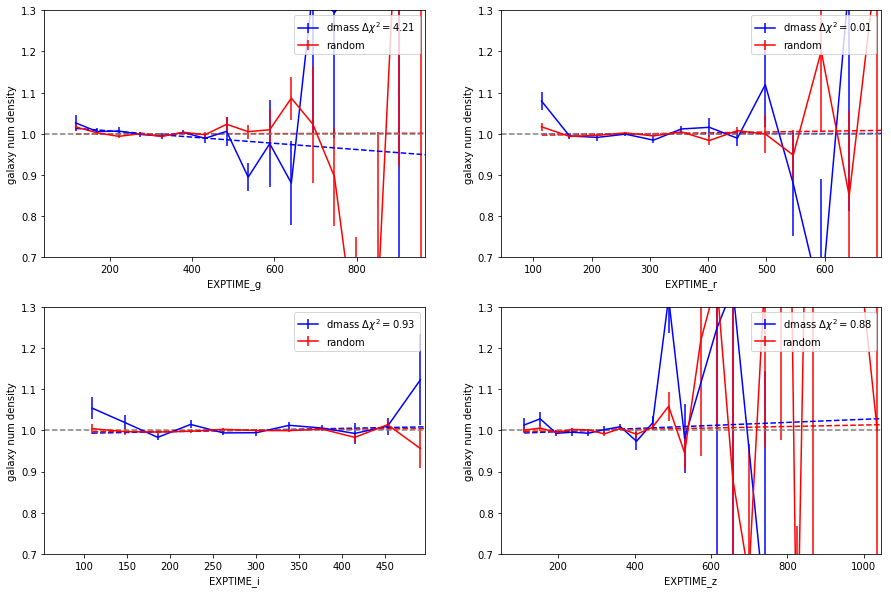

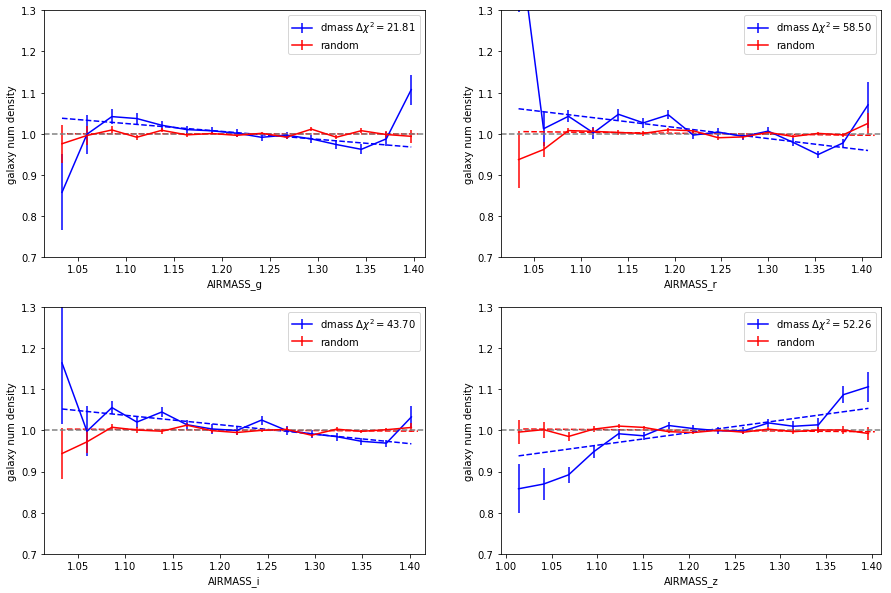

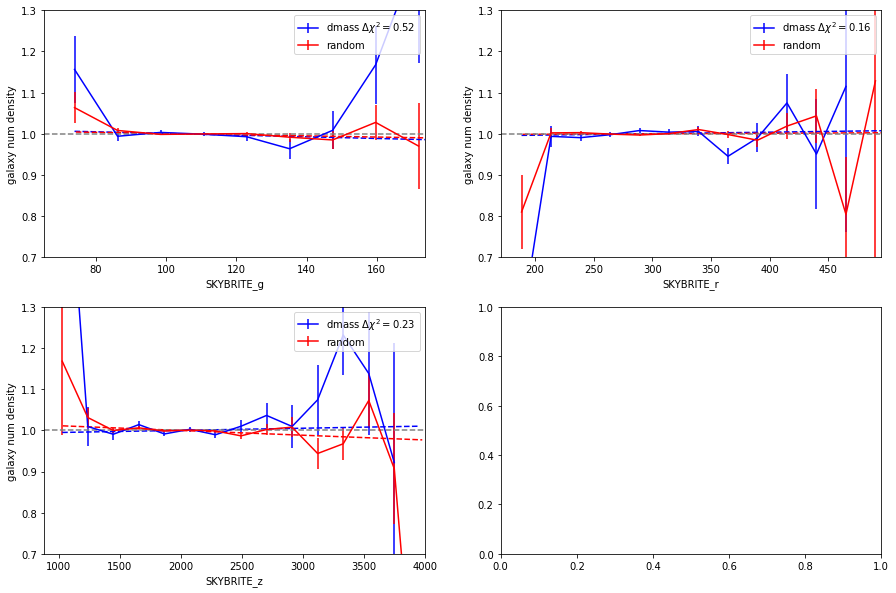

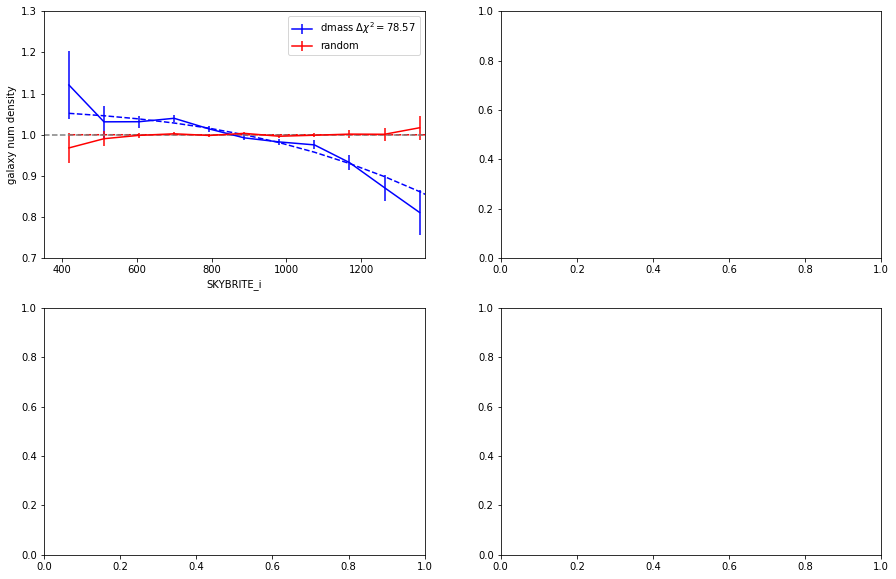

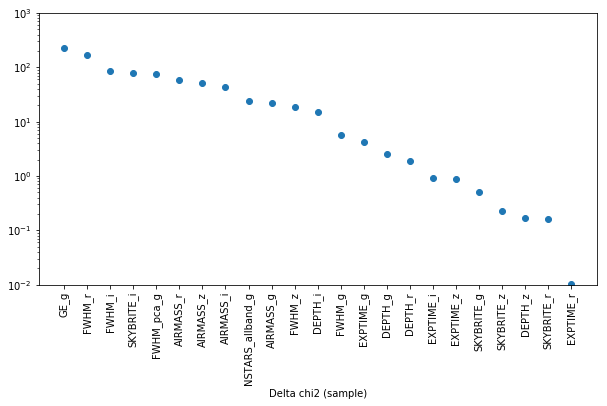

In [41]:
filters = ['g']
fitting_SP( property = ['NSTARS_allband'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'log',
                path = inputdir )

fitting_SP( property = ['FWHM_pca'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )



filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['FWHM'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['DEPTH'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['EXPTIME'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )

filters = ['g', 'r', 'i', 'z']
fitting_SP( property = ['AIRMASS'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['g', 'r', 'z']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'linear',
                path = inputdir )


filters = ['i']
fitting_SP( property = ['SKYBRITE'], filter=filters, kind = 'SPT', suffix='no_weight', plot=True, function = 'errftn',
                path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, suffix='no_weight', 
                path = inputdir, deltachi2=True)


# Correction ! 

### Galactic Extinction

In [43]:
weightDic = {}
weightDic['noweight'] = np.ones(dmass_masked.size)
all_weight = weightDic['noweight']
suffix = 'no_weight'
nextweight = 'GE_g'

----------------------------------
initialize function  GE_g
log
106857
store weight  GE_g
save weight to fits ../data_txt/systematics/pca//weights/wg_ge_g_SPT.fits
suffix =  wg_ge_g


../systematics.py:451: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:455: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:455: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/pca/systematic_FWHM_pca_g_SPT_wg_ge_g.txt


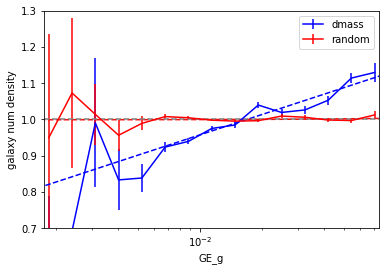

In [44]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=512, kind='SPT', function='log', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  9.748001223180127
chi2_mod. =  8.823770564426063
Delta chi2 (sample) = 0.9242306587540643
output save to  ../data_txt/systematics/pca/systematic_DEPTH_g_SPT_wg_ge_g.txt.model

chi2_null =  9.239403971437612
chi2_mod. =  8.912071323088268
Delta chi2 (sample) = 0.32733264834934417
output save to  ../data_txt/systematics/pca/systematic_DEPTH_r_SPT_wg_ge_g.txt.model

chi2_null =  15.068883465302644
chi2_mod. =  9.93713036741868
Delta chi2 (sample) = 5.131753097883964
output save to  ../data_txt/systematics/pca/systematic_DEPTH_i_SPT_wg_ge_g.txt.model

chi2_null =  23.51862144776997
chi2_mod. =  23.388520319873766
Delta chi2 (sample) = 0.13010112789620365
output save to  ../data_txt/systematics/pca/systematic_DEPTH_z_SPT_wg_ge_g.txt.model

chi2_null =  20.816324397833352
chi2_mod. =  15.057008699729712
Delta chi2 (sample) = 5.75931569810364
output save to  ../data_txt/systematics/pca/systematic_EXPTIME_g_SPT_wg_ge_g.txt.model

chi2_null =  27.743797119045738
chi2_mod. =  27.421

(['FWHM_r',
  'FWHM_pca_g',
  'FWHM_i',
  'AIRMASS_z',
  'SKYBRITE_i',
  'SKYBRITE_z',
  'AIRMASS_r',
  'AIRMASS_g',
  'AIRMASS_i',
  'FWHM_z',
  'EXPTIME_g',
  'NSTARS_allband_g',
  'DEPTH_i',
  'FWHM_g',
  'EXPTIME_z',
  'DEPTH_g',
  'SKYBRITE_g',
  'EXPTIME_i',
  'DEPTH_r',
  'EXPTIME_r',
  'GE_g',
  'DEPTH_z',
  'SKYBRITE_r'],
 [177.1553355279681,
  81.97829156385222,
  77.5858473756343,
  62.83589112105472,
  44.52277033794589,
  13.650778441424066,
  13.05650998328828,
  13.052196257381631,
  9.575215164777752,
  7.3305274044429325,
  5.75931569810364,
  5.138903893744814,
  5.131753097883964,
  2.537819006817031,
  1.5632286067686856,
  0.9242306587540643,
  0.7842007063574119,
  0.7761013994321608,
  0.32733264834934417,
  0.3223988538200331,
  0.1321113800825593,
  0.13010112789620365,
  0.021163361539272785])

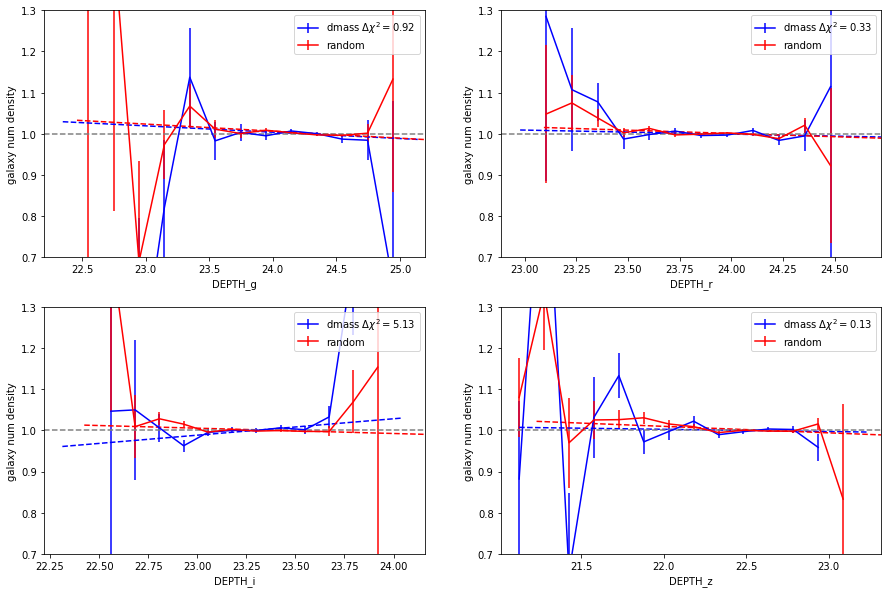

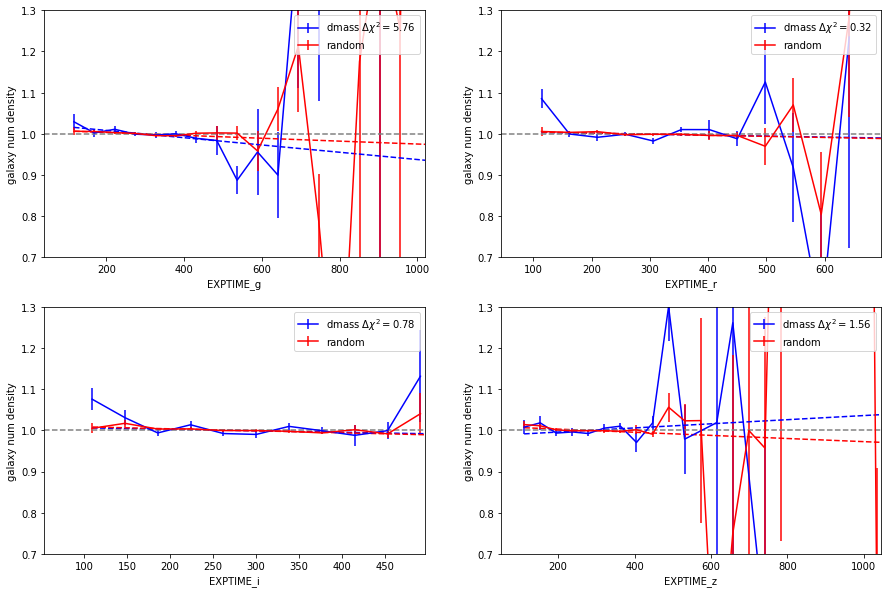

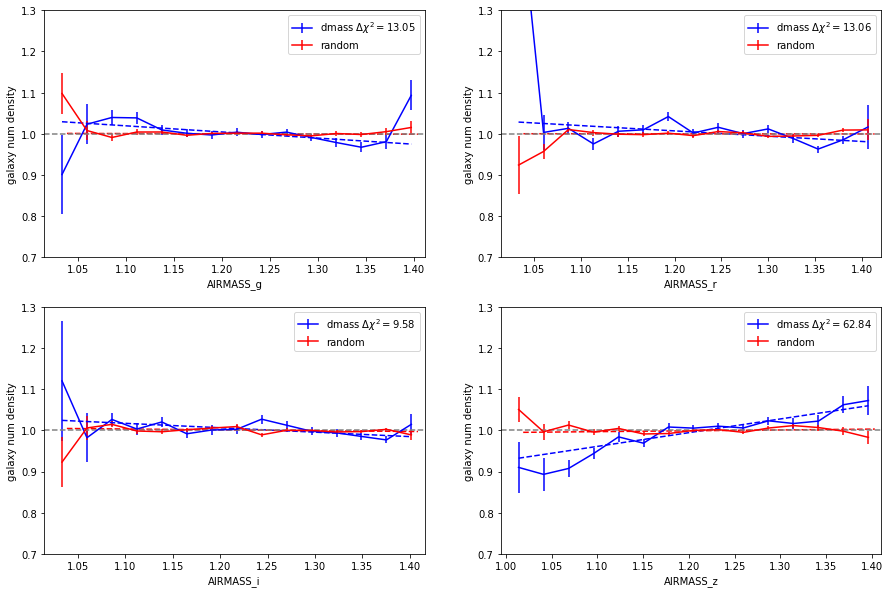

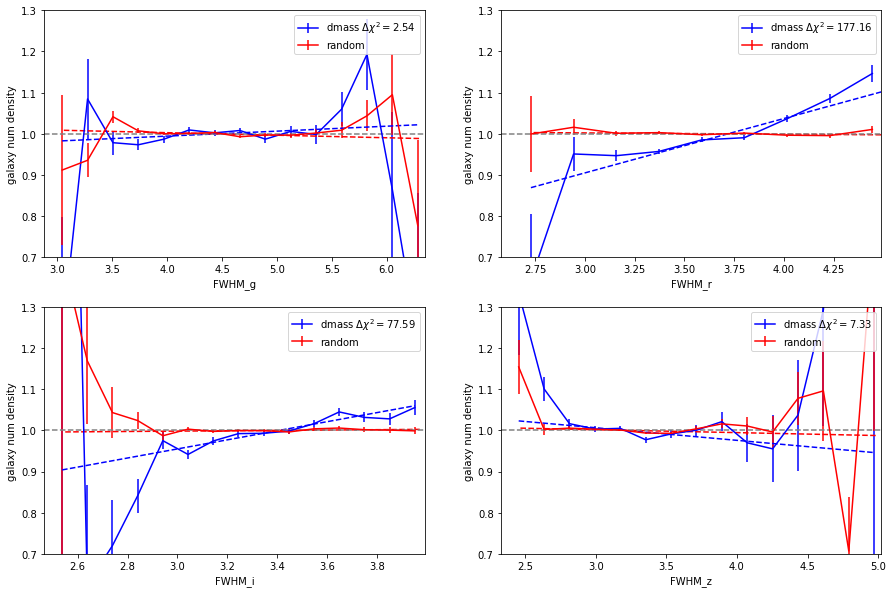

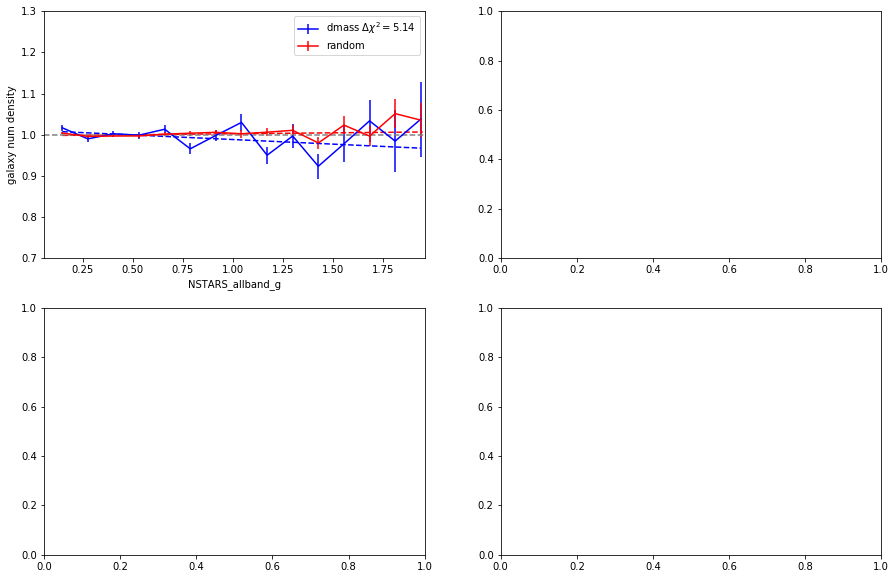

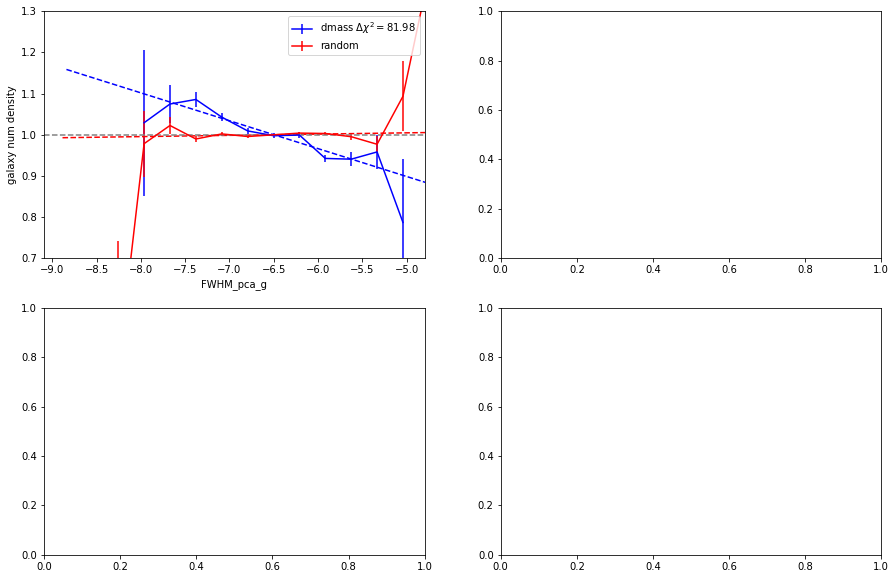

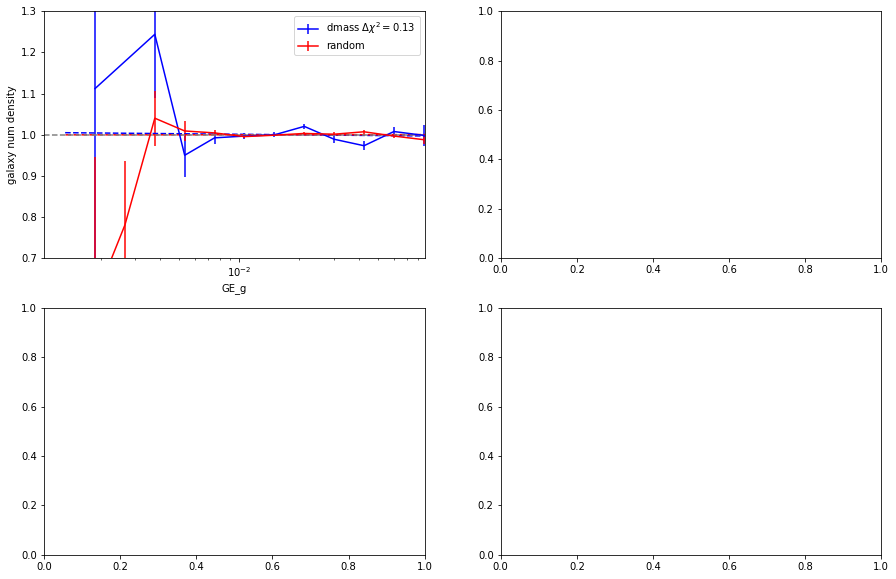

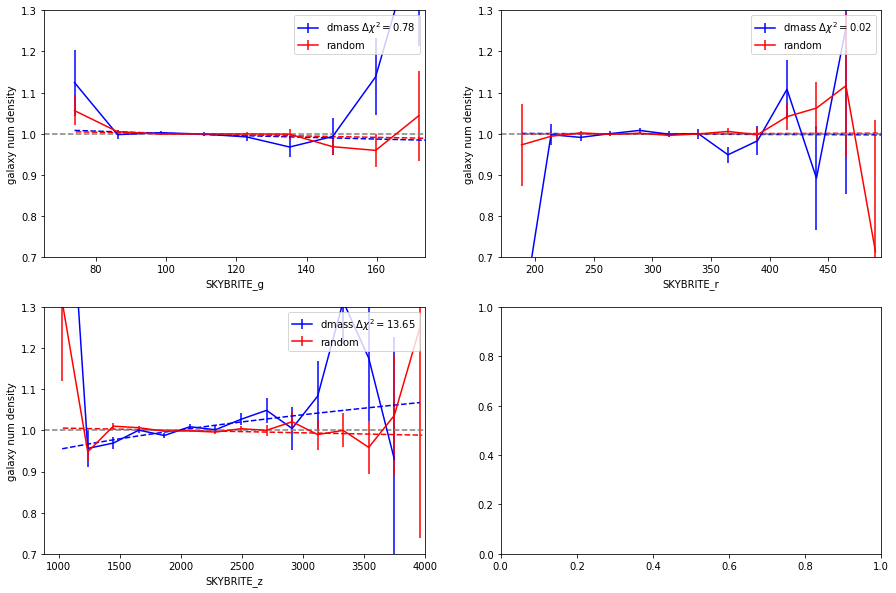

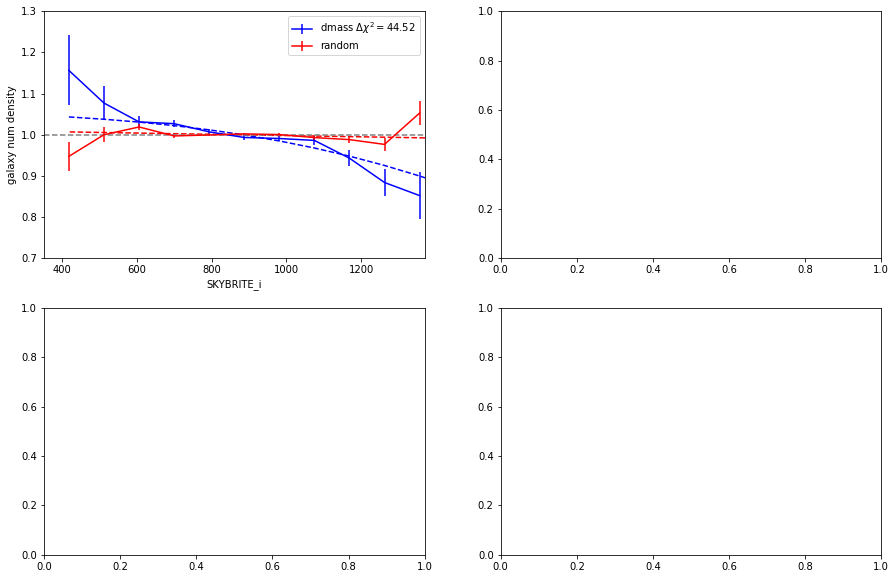

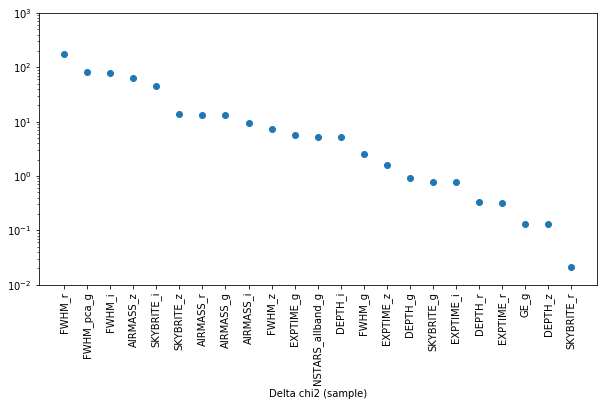

In [47]:
suffix = 'wg_ge_g'

filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['NSTARS_allband', 'FWHM_pca'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)


In [48]:
#cp ../data_txt/systematics/3rd/systematic*_wg_ge_g_fwhm_r.txt ../data_txt/systematics/pca/.

In [60]:
all_weight = weightDic['noweight'] * weightDic['GE_g']
suffix = 'wg_ge_g'
nextweight = 'FWHM_pca_g'

----------------------------------
initialize function  FWHM_pca_g
linear
106857
store weight  FWHM_pca_g
save weight to fits ../data_txt/systematics/pca//weights/wg_fwhm_pca_g_SPT.fits
suffix =  wg_ge_g_fwhm_pca_g
saving data to  ../data_txt/systematics/pca/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_EXPTIME_r_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_EXPTIME_i_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_EXPTIME_z_SPT_wg_ge_g_fwhm_pca_g.txt
saving data to  ../data_txt/systematics/pca/systematic_AI

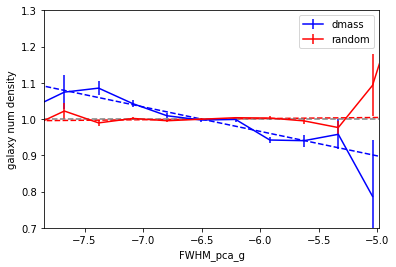

In [57]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  1219.2144431766992
chi2_mod. =  640.6205359841947
Delta chi2 (sample) = 578.5939071925045
output save to  ../data_txt/systematics/pca/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_pca_g.txt.model

chi2_null =  199.8741902664539
chi2_mod. =  34.03665950297629
Delta chi2 (sample) = 165.83753076347762
output save to  ../data_txt/systematics/pca/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_pca_g.txt.model

chi2_null =  105.35125891898318
chi2_mod. =  15.627579646040894
Delta chi2 (sample) = 89.72367927294228
output save to  ../data_txt/systematics/pca/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_pca_g.txt.model

chi2_null =  19169.747529032902
chi2_mod. =  3336.641071061127
Delta chi2 (sample) = 15833.106457971775
output save to  ../data_txt/systematics/pca/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_pca_g.txt.model

chi2_null =  115.44716701775934
chi2_mod. =  86.6242262144605
Delta chi2 (sample) = 28.822940803298835
output save to  ../data_txt/systematics/pca/systematic_EXPTIME_g_SPT_wg_ge_g_fwhm_pca_g.txt.mod

(['DEPTH_z',
  'SKYBRITE_z',
  'DEPTH_g',
  'EXPTIME_z',
  'DEPTH_r',
  'DEPTH_i',
  'EXPTIME_r',
  'FWHM_r',
  'NSTARS_allband_g',
  'GE_g',
  'EXPTIME_i',
  'EXPTIME_g',
  'AIRMASS_i',
  'SKYBRITE_i',
  'SKYBRITE_r',
  'FWHM_g',
  'AIRMASS_r',
  'FWHM_i',
  'AIRMASS_z',
  'AIRMASS_g',
  'FWHM_z',
  'FWHM_pca_g',
  'SKYBRITE_g'],
 [15833.106457971775,
  1571.3107470115274,
  578.5939071925045,
  408.9575106655726,
  165.83753076347762,
  89.72367927294228,
  89.21711746089548,
  84.9850584877917,
  58.334232002409834,
  44.70417957843014,
  28.836156446261718,
  28.822940803298835,
  20.44959765164475,
  18.701455033466935,
  16.701470254266944,
  14.921091582234421,
  14.048767801009149,
  13.582052659187408,
  10.729410078981914,
  3.835252442385439,
  0.4635044975364977,
  0.13600517197093254,
  0.0017202816827843748])

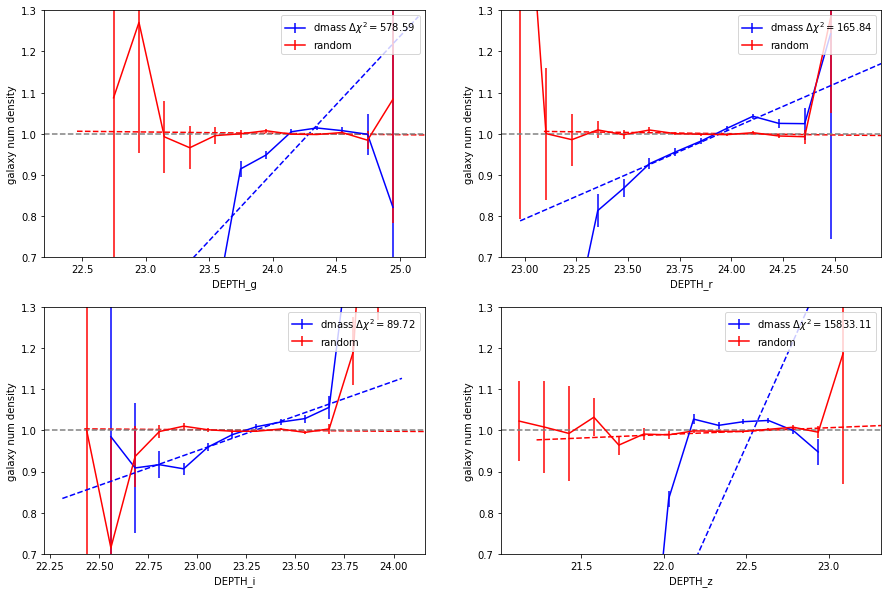

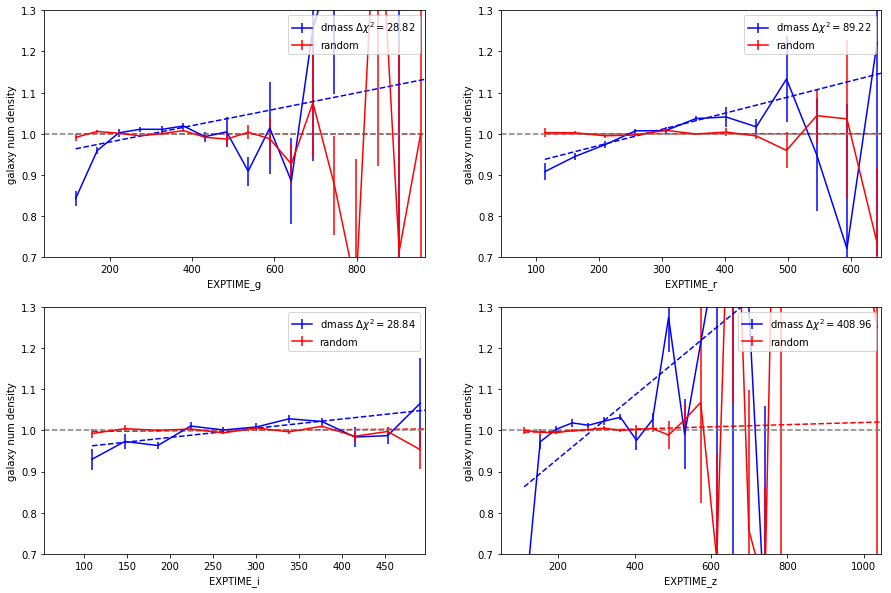

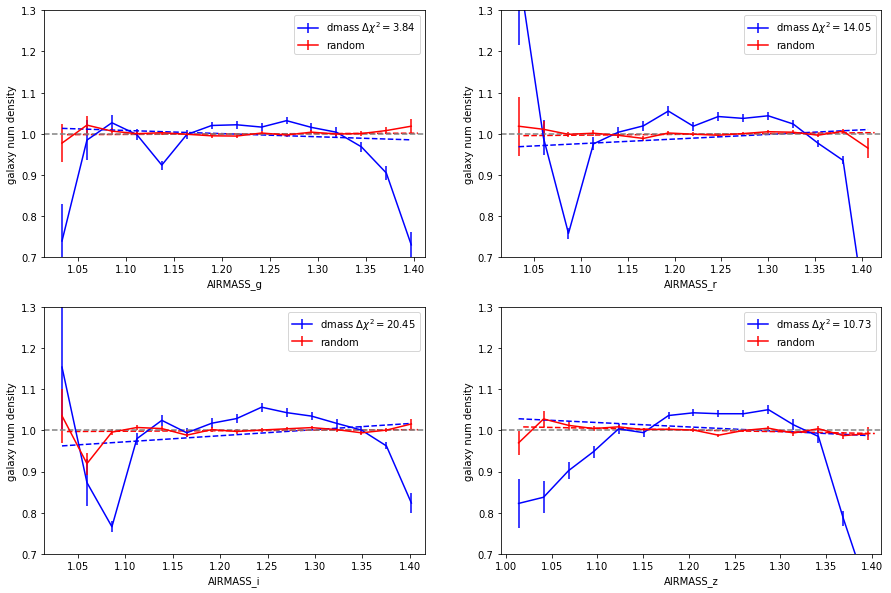

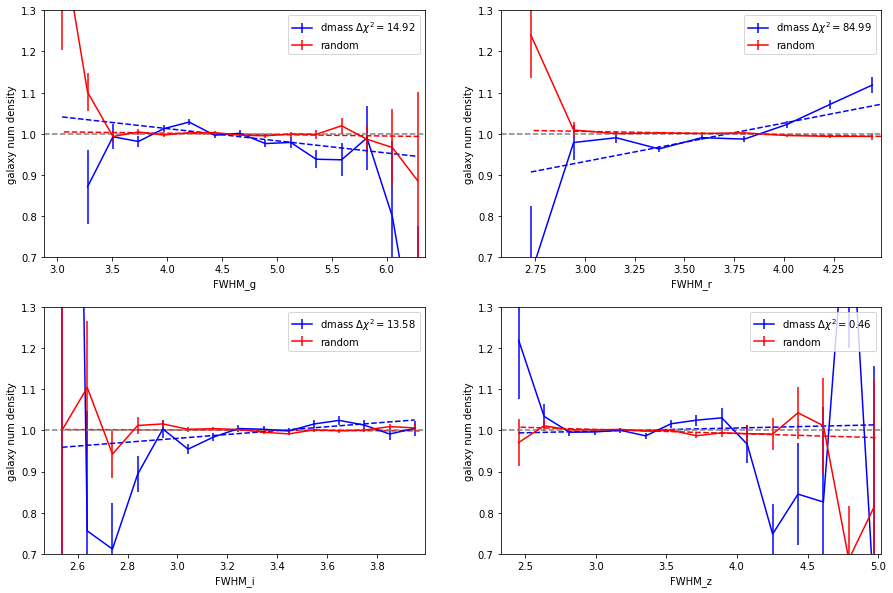

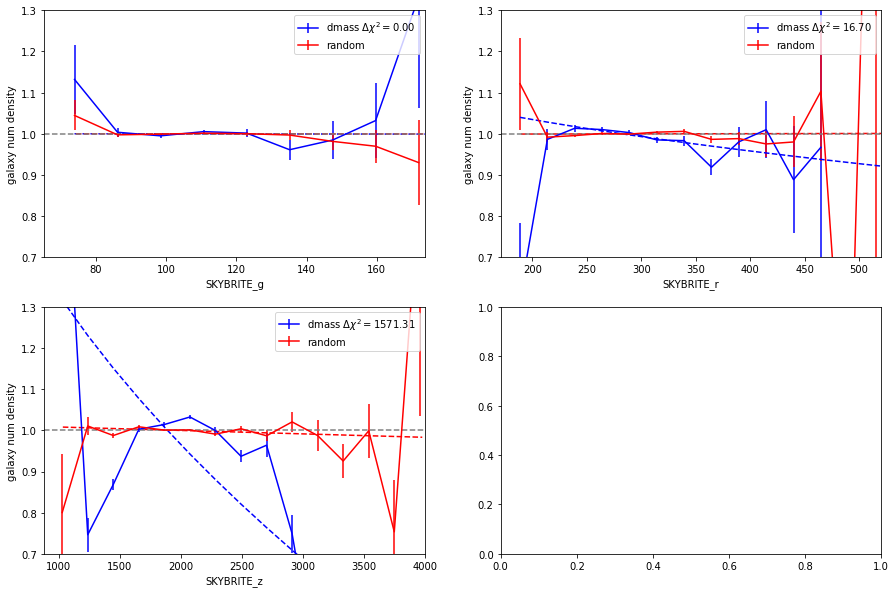

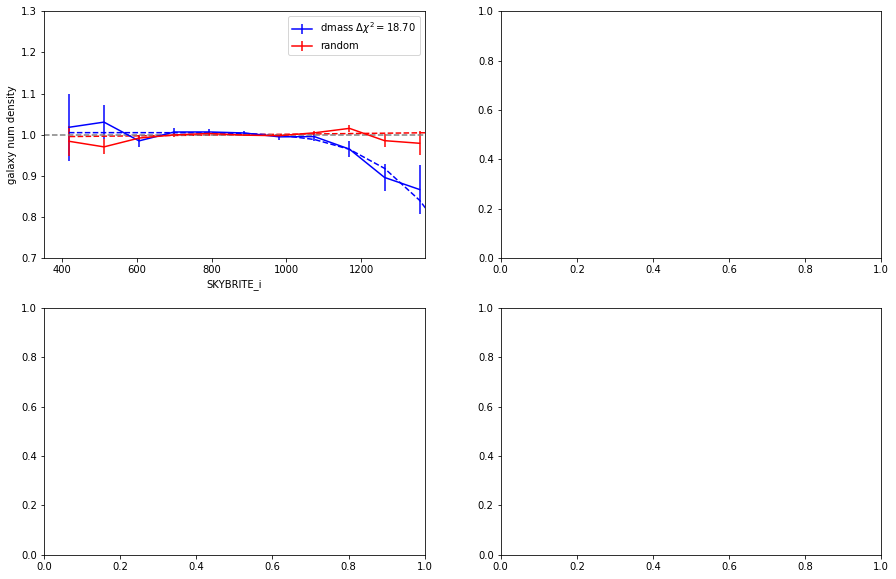

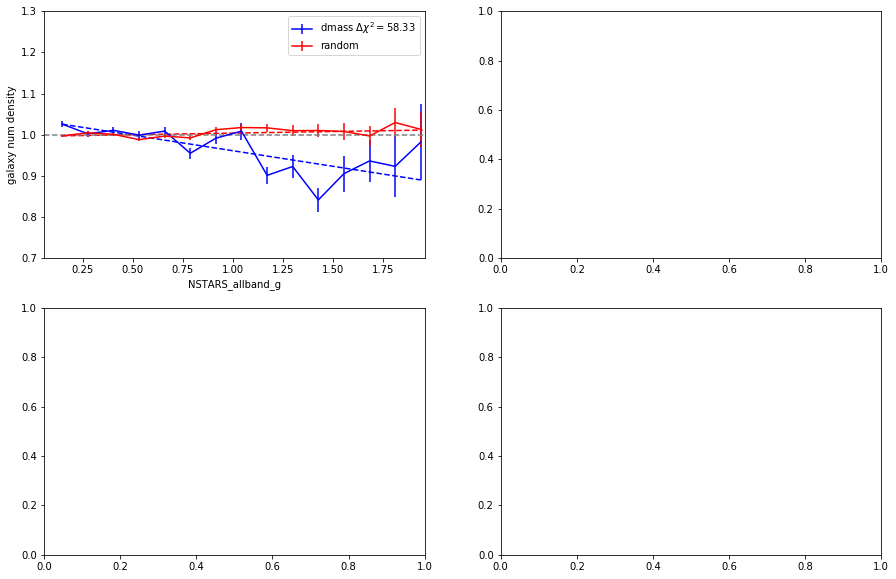

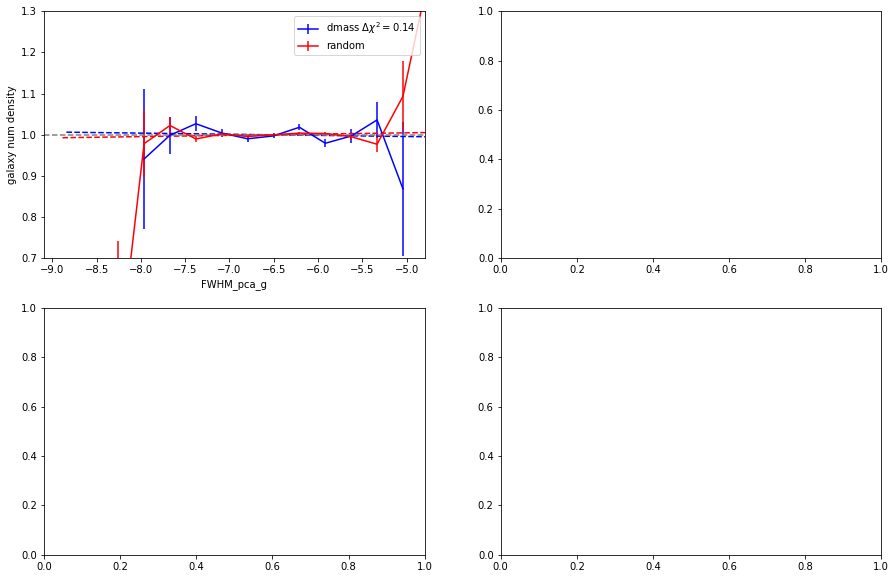

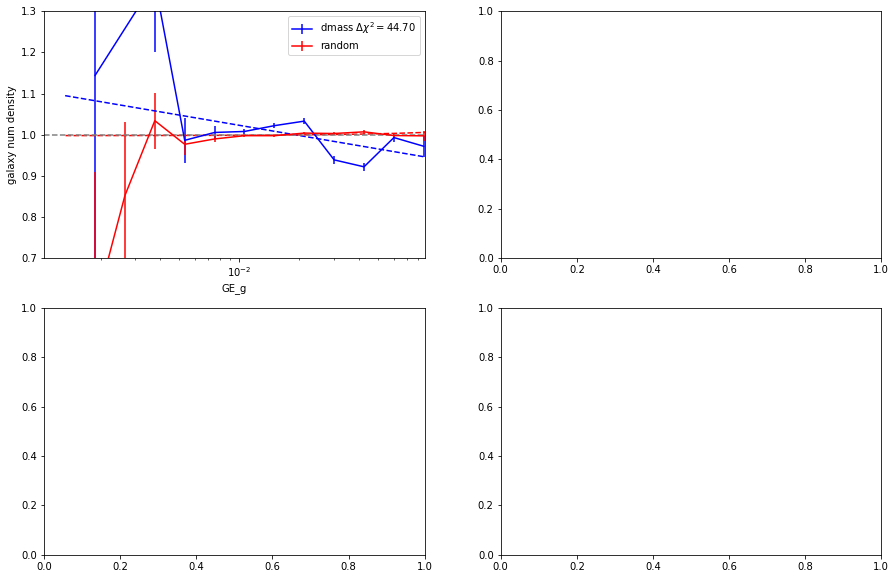

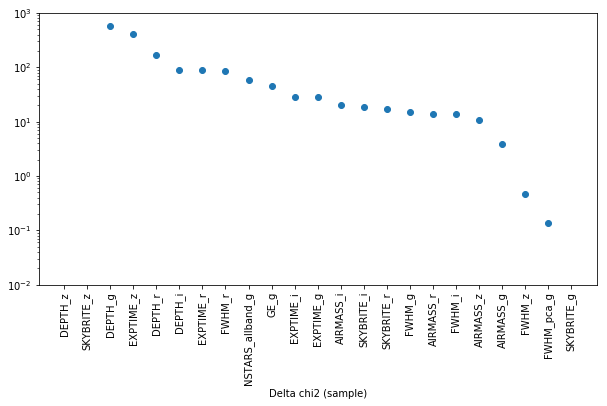

In [61]:
suffix = 'wg_ge_g_fwhm_pca_g'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband', 'FWHM_pca'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)




In [52]:
#cp ../data_txt/systematics/3rd/systematic*_wg_ge_g_fwhm_r_airmass_z.txt ../data_txt/systematics/pca/.

In [58]:
suffix

'wg_ge_g'

----------------------------------
initialize function  AIRMASS_z
linear
106857
store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/pca//weights/wg_airmass_z_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z


KeyboardInterrupt: 

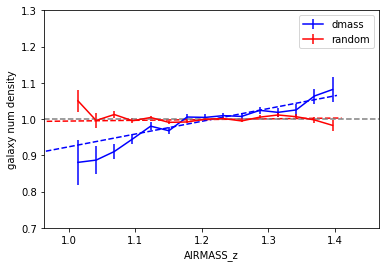

In [53]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r']
suffix = 'wg_ge_g_fwhm_r'
nextweight = 'AIRMASS_z'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = ['FWHM_pca'], filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

In [ ]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband', 'FWHM_pca'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)






In [292]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z']
suffix = 'wg_ge_g_fwhm_r_airmass_z'
nextweight = 'AIRMASS_i'

----------------------------------
initialize function  AIRMASS_i
linear
chi2_null =  82.3088495091914
chi2_mod. =  36.73023234698433
Delta chi2 (sample) = 45.578617162207074
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_AIRMASS_i_SPT_wg_ge_g_fwhm_r_airmass_z.txt.model

106857
store weight  AIRMASS_i
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_airmass_i_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_EX

0

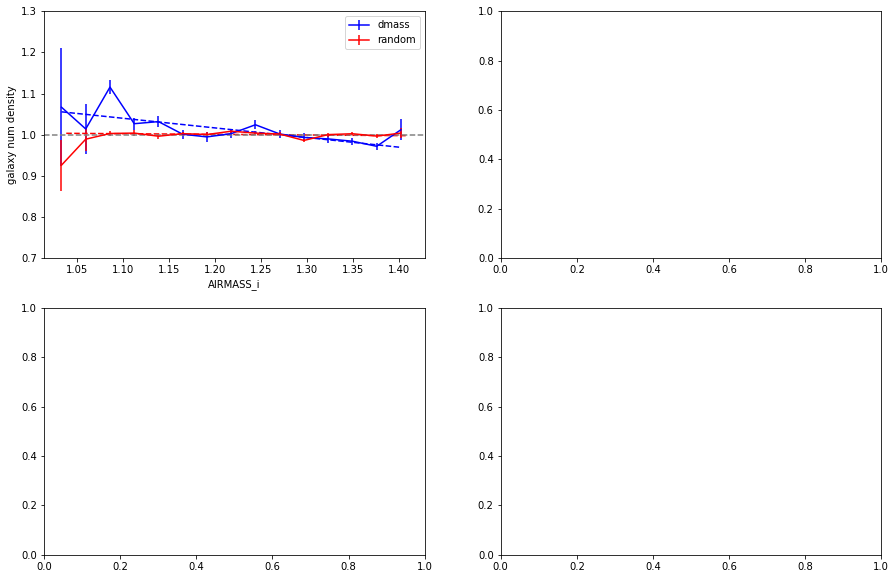

In [293]:
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  12.541841139707971
chi2_mod. =  10.998224635192017
Delta chi2 (sample) = 1.5436165045159544
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  15.199221769424215
chi2_mod. =  11.671276151006944
Delta chi2 (sample) = 3.52794561841727
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  7.52246706536738
chi2_mod. =  7.12021315332224
Delta chi2 (sample) = 0.4022539120451398
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  17.77773670370691
chi2_mod. =  17.72151967600534
Delta chi2 (sample) = 0.056217027701571
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt.model

chi2_null =  13.33709677980766
chi2_mod. =  8.375915074919897
Delta chi2 (sample) = 4.961

(['SKYBRITE_i',
  'FWHM_i',
  'SKYBRITE_r',
  'SKYBRITE_z',
  'AIRMASS_z',
  'AIRMASS_g',
  'EXPTIME_g',
  'FWHM_z',
  'FWHM_g',
  'DEPTH_r',
  'EXPTIME_r',
  'NSTARS_allband_g',
  'DEPTH_g',
  'EXPTIME_z',
  'AIRMASS_r',
  'EXPTIME_i',
  'GE_g',
  'DEPTH_i',
  'FWHM_r',
  'SKYBRITE_g',
  'DEPTH_z',
  'AIRMASS_i'],
 [17.033689812800002,
  9.709379016023288,
  9.202829375112064,
  7.383735410011482,
  5.695628898659805,
  4.962945082490474,
  4.961181704887762,
  4.301453646640887,
  3.6619671549104496,
  3.52794561841727,
  2.554062533515208,
  1.6188372500527102,
  1.5436165045159544,
  0.835844796597188,
  0.8001632543626442,
  0.7848120657760775,
  0.4998868607429223,
  0.4022539120451398,
  0.21716899599766393,
  0.12503656735303892,
  0.056217027701571,
  0.002523256328458956])

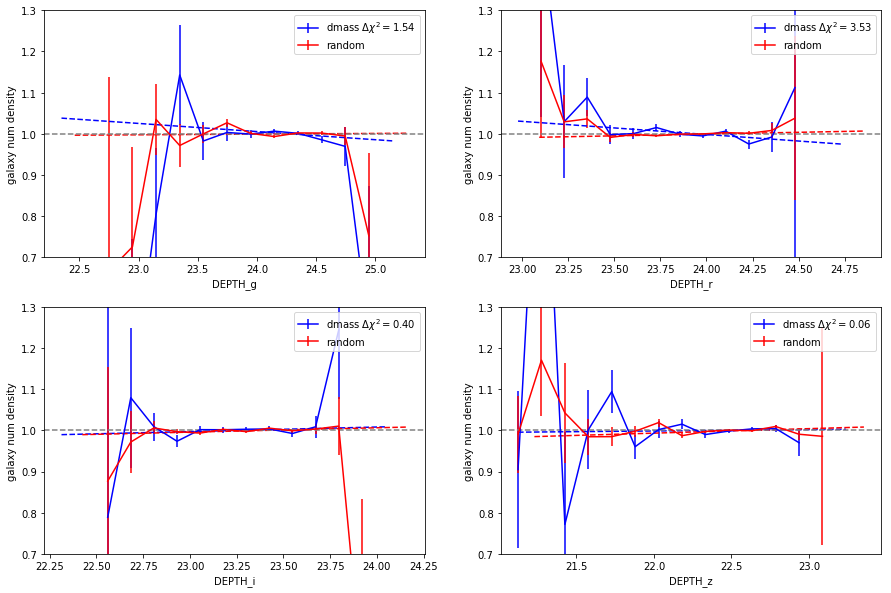

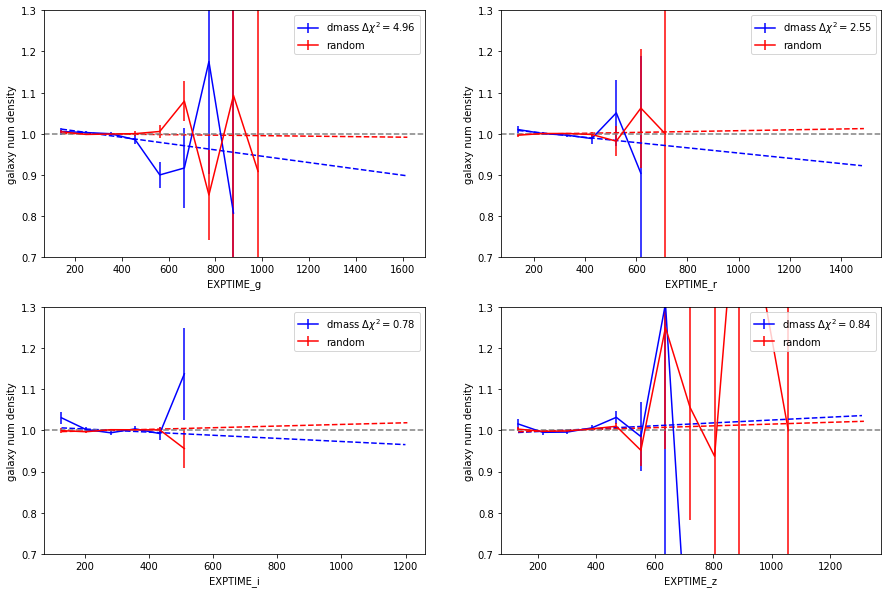

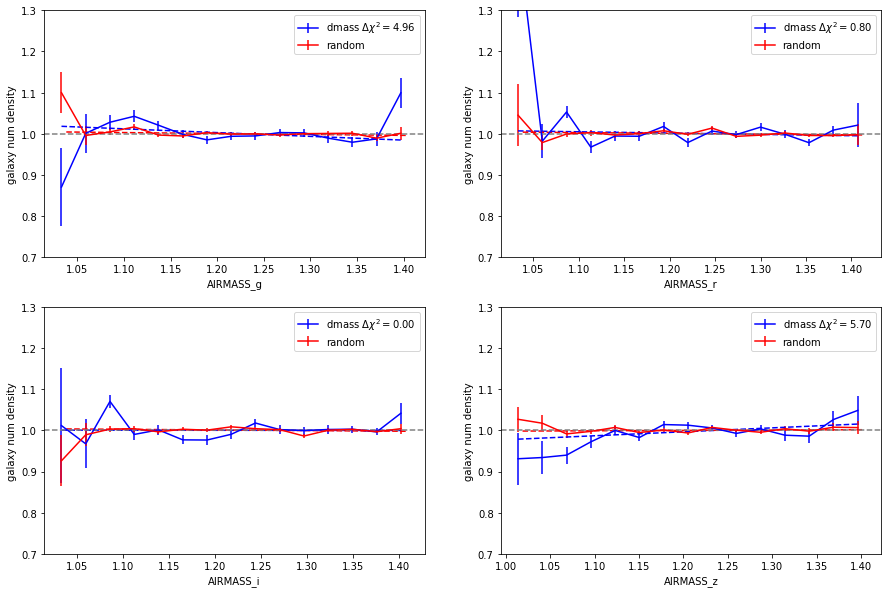

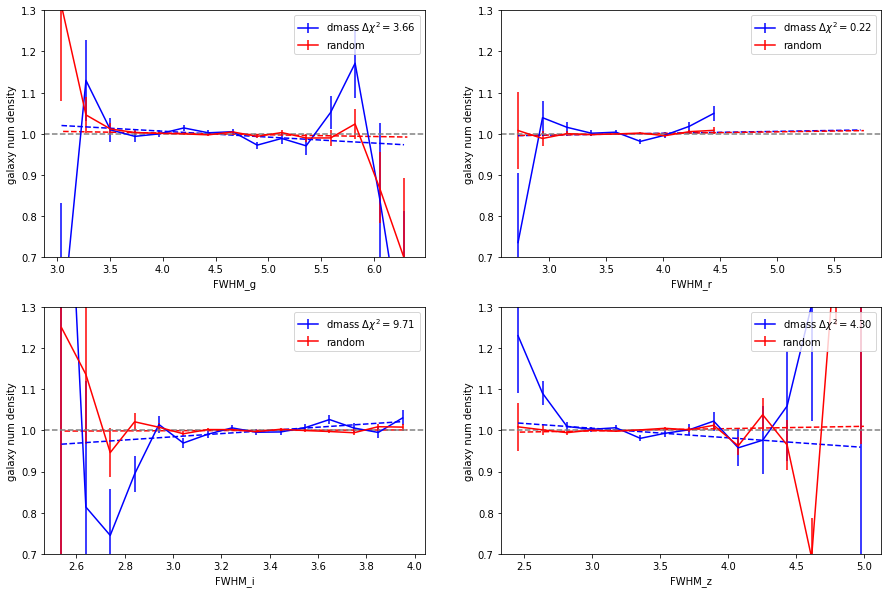

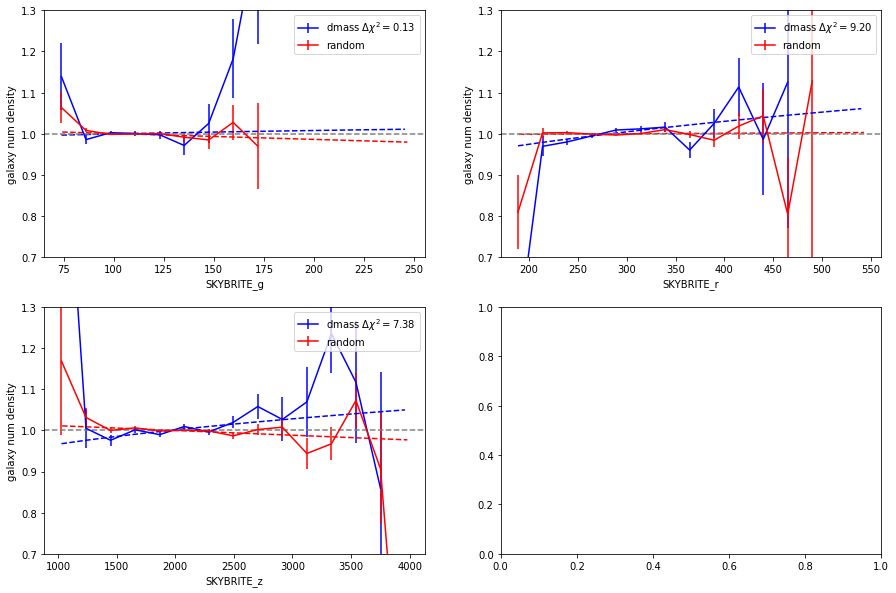

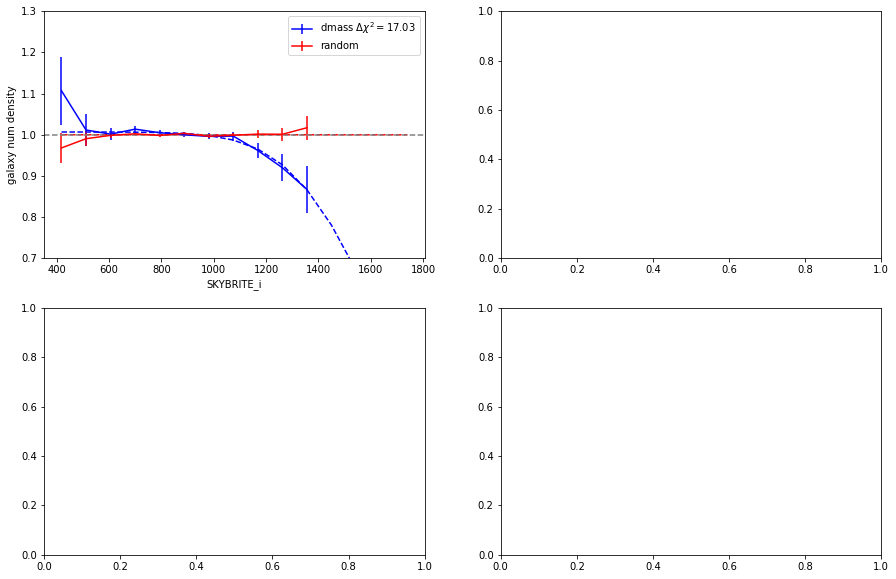

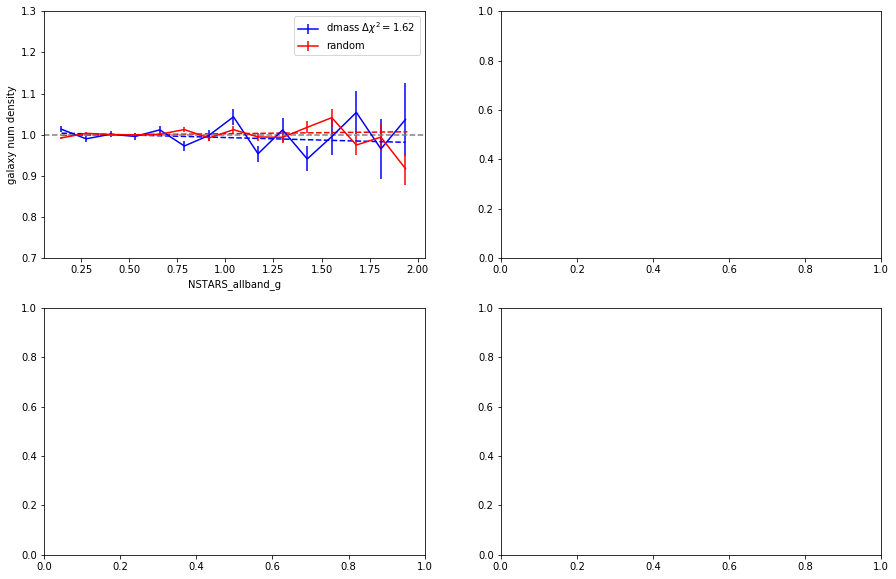

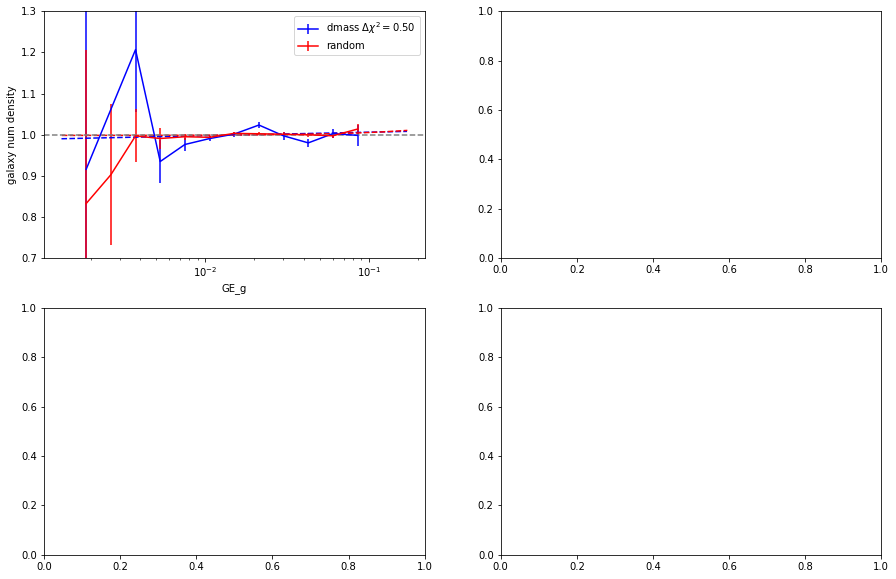

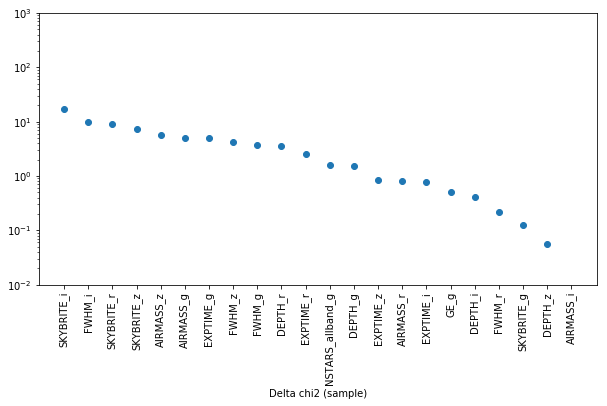

In [295]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)





----------------------------------
initialize function  SKYBRITE_i
errftn
chi2_null =  20.68117669170018
chi2_mod. =  3.6474868789001795
Delta chi2 (sample) = 17.033689812800002
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_SKYBRITE_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i.txt.model

106857
store weight  SKYBRITE_i
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_skybrite_i_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.tx

0

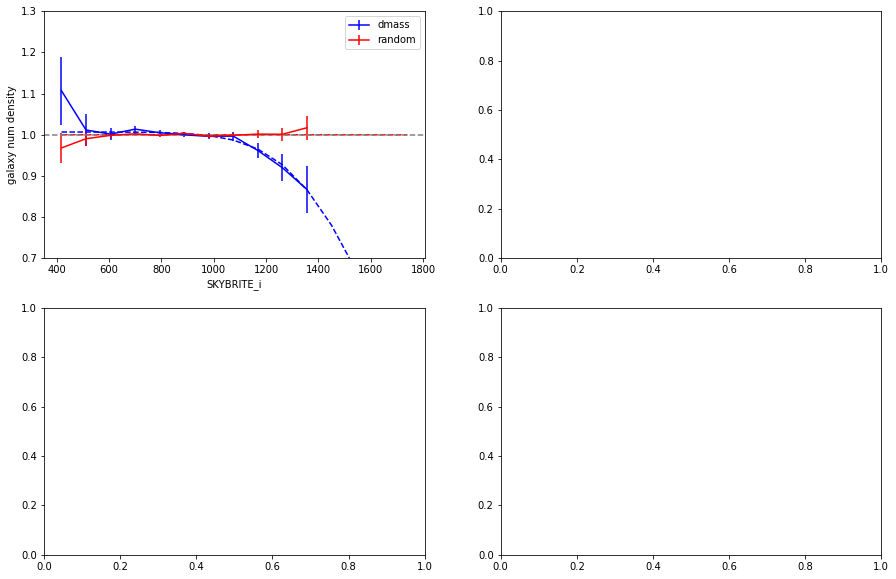

In [298]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] *\
* weightDic['AIRMASS_i']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i'
nextweight = 'SKYBRITE_i'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='errftn', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  15.9074532324049
chi2_mod. =  11.320592360790227
Delta chi2 (sample) = 4.586860871614672
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt.model

chi2_null =  19.97407407057429
chi2_mod. =  10.82285260248163
Delta chi2 (sample) = 9.15122146809266
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt.model

chi2_null =  6.265995161852064
chi2_mod. =  5.851327375964434
Delta chi2 (sample) = 0.4146677858876302
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt.model

chi2_null =  17.574837934328013
chi2_mod. =  17.111934862659204
Delta chi2 (sample) = 0.4629030716688085
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt.model

chi2_null =  18.150740973253995
chi2_mod. =  

(['AIRMASS_i',
  'AIRMASS_g',
  'AIRMASS_r',
  'FWHM_i',
  'SKYBRITE_r',
  'SKYBRITE_i',
  'EXPTIME_g',
  'DEPTH_r',
  'FWHM_z',
  'EXPTIME_r',
  'DEPTH_g',
  'GE_g',
  'EXPTIME_i',
  'SKYBRITE_z',
  'FWHM_g',
  'SKYBRITE_g',
  'FWHM_r',
  'EXPTIME_z',
  'DEPTH_z',
  'DEPTH_i',
  'AIRMASS_z',
  'NSTARS_allband_g'],
 [32.239924421809,
  30.616500115443188,
  25.67004292116215,
  15.583413886743553,
  14.27404187434077,
  14.141094544609597,
  9.833363735428199,
  9.15122146809266,
  7.073338530130904,
  6.441302696650529,
  4.586860871614672,
  3.1148099978678765,
  3.0210790394557465,
  2.8042555738880175,
  1.3640513358063338,
  0.7781232657654336,
  0.6265288229434276,
  0.5053710229784301,
  0.4629030716688085,
  0.4146677858876302,
  0.20664277791627939,
  0.18589194964456723])

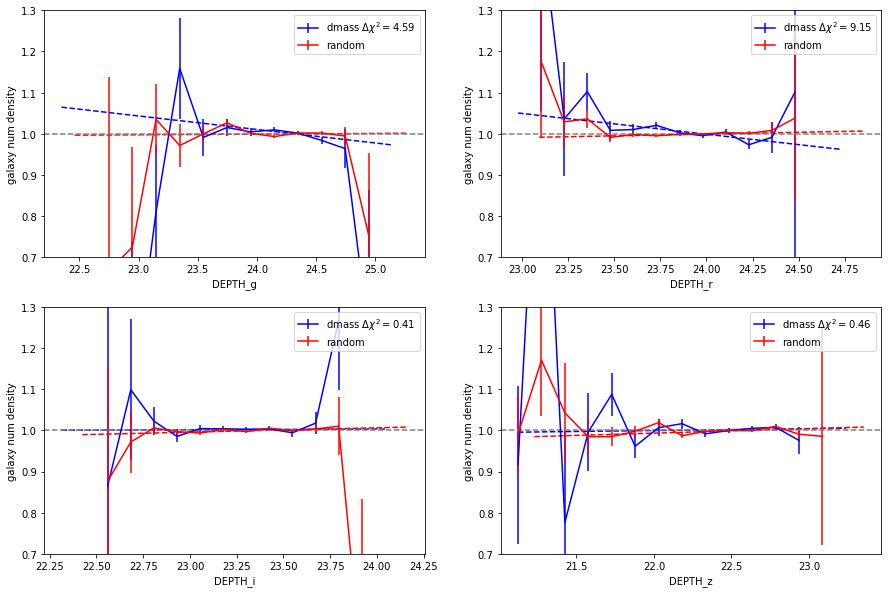

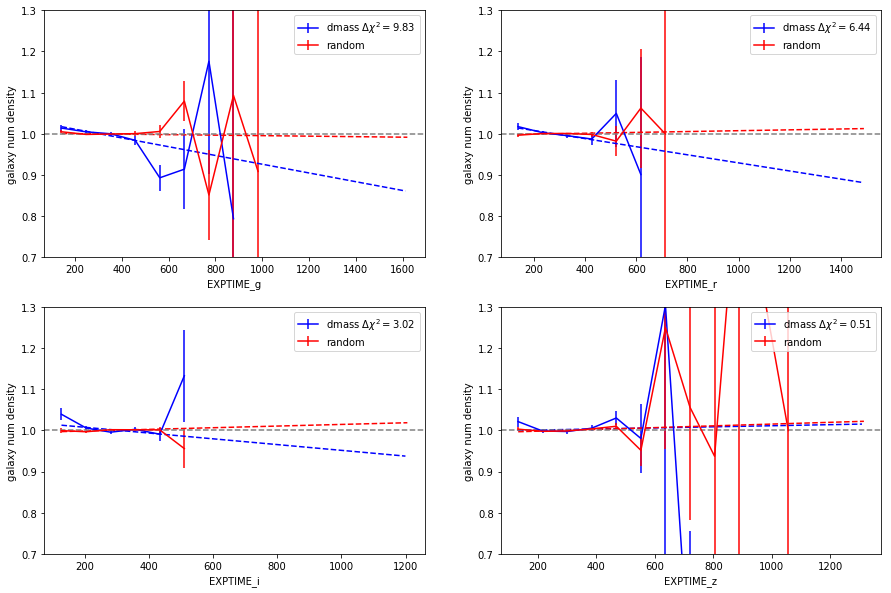

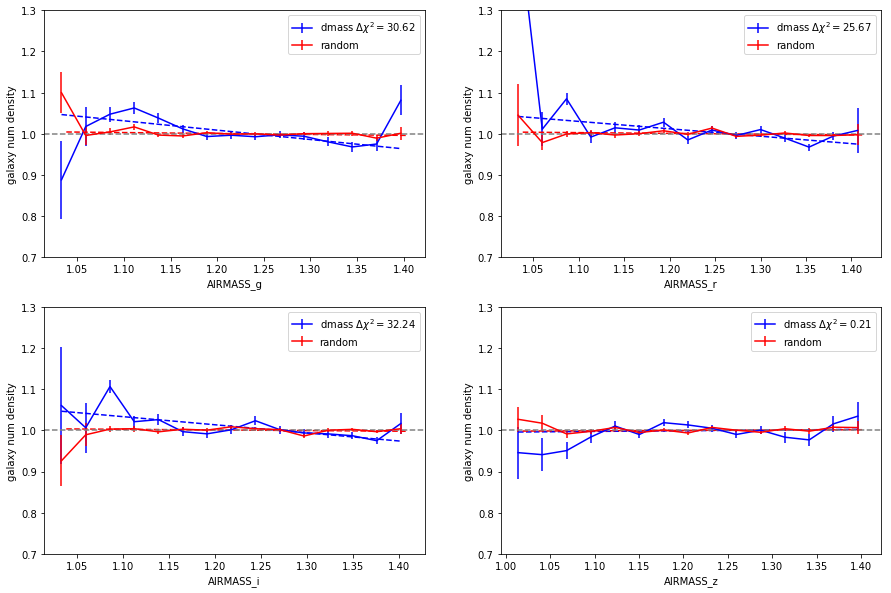

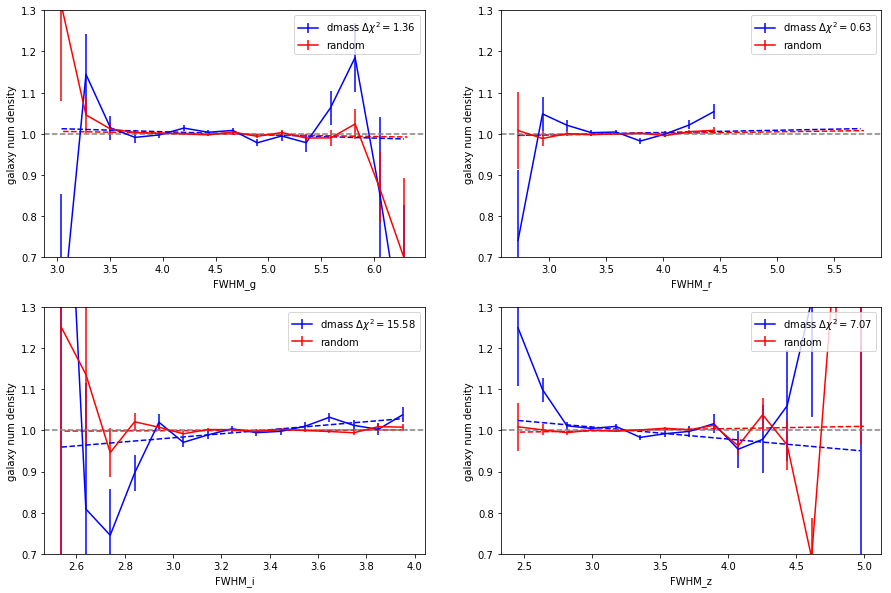

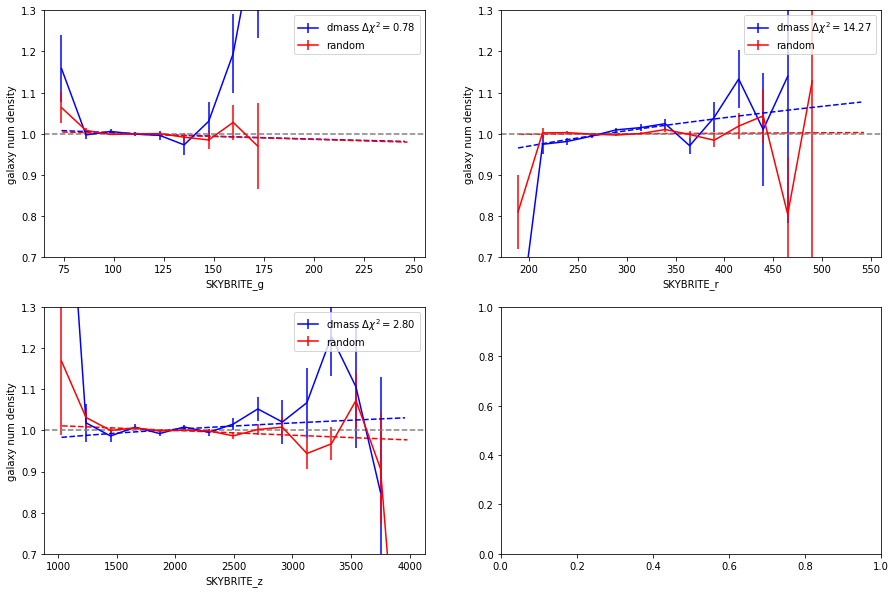

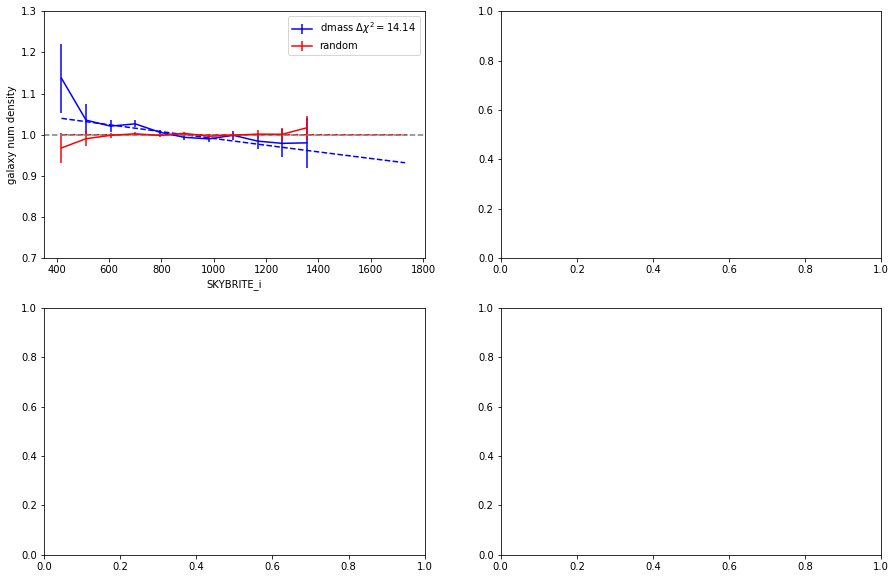

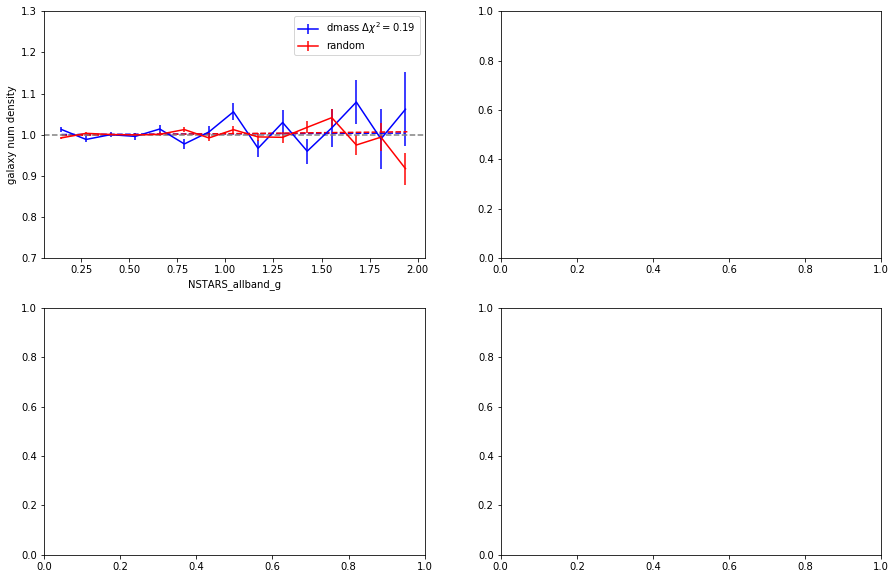

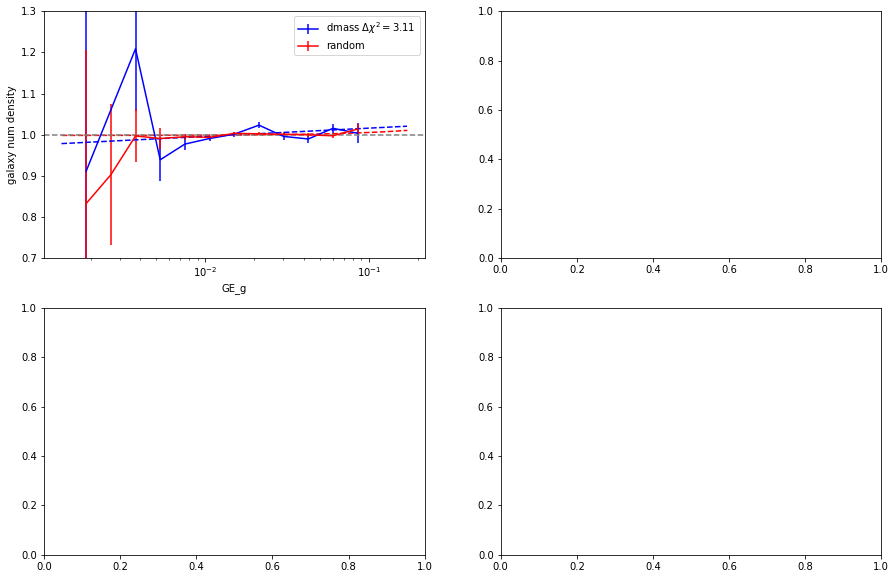

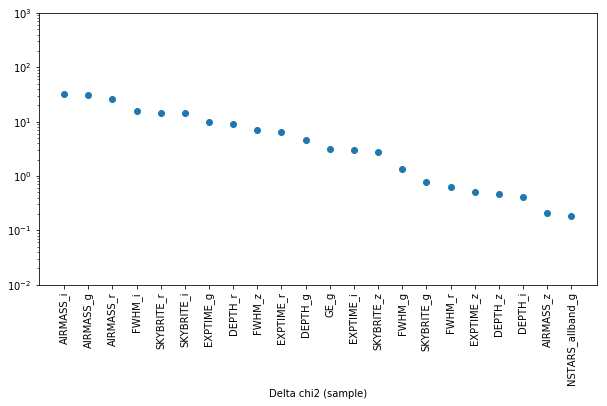

In [299]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)



----------------------------------
initialize function  AIRMASS_g
linear
chi2_null =  58.66713140683033
chi2_mod. =  28.05063129138714
Delta chi2 (sample) = 30.616500115443188
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_AIRMASS_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i.txt.model

106857
store weight  AIRMASS_g
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_airmass_g_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg

0

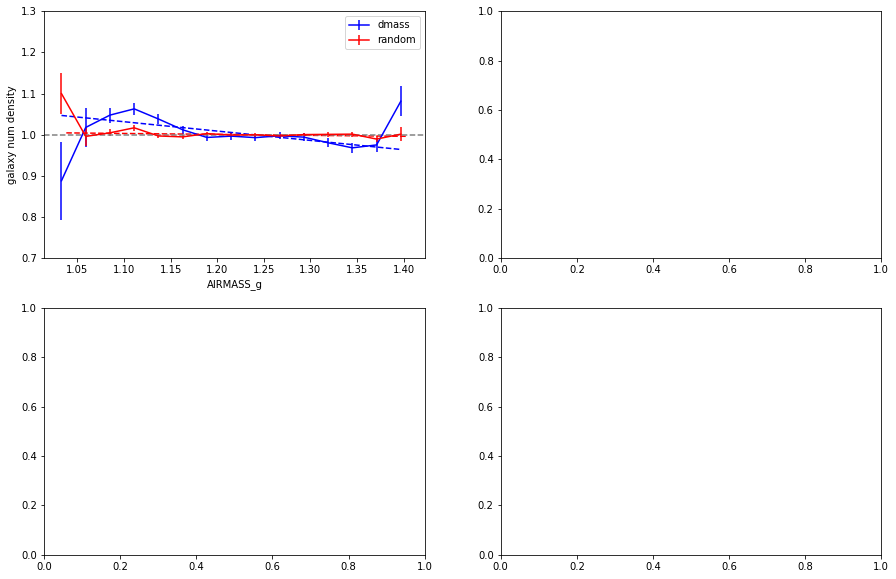

In [304]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] *\
* weightDic['AIRMASS_i'] * weightDic['SKYBRITE_i']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i'
nextweight = 'AIRMASS_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  16.376323334102437
chi2_mod. =  12.55056015100828
Delta chi2 (sample) = 3.825763183094157
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt.model

chi2_null =  15.292304571265818
chi2_mod. =  10.402305100877665
Delta chi2 (sample) = 4.889999470388153
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt.model

chi2_null =  5.535983866821507
chi2_mod. =  5.532232247377625
Delta chi2 (sample) = 0.003751619443882248
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt.model

chi2_null =  17.83123149307517
chi2_mod. =  17.83017889244008
Delta chi2 (sample) = 0.0010526006350879413
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt.model

(['SKYBRITE_r',
  'FWHM_i',
  'EXPTIME_g',
  'SKYBRITE_z',
  'FWHM_g',
  'AIRMASS_i',
  'DEPTH_r',
  'FWHM_z',
  'SKYBRITE_i',
  'DEPTH_g',
  'EXPTIME_r',
  'AIRMASS_z',
  'AIRMASS_r',
  'GE_g',
  'SKYBRITE_g',
  'EXPTIME_i',
  'NSTARS_allband_g',
  'EXPTIME_z',
  'FWHM_r',
  'DEPTH_i',
  'AIRMASS_g',
  'DEPTH_z'],
 [12.00976832592626,
  10.997328874672053,
  7.1394377115579815,
  6.979720686614822,
  5.970447403877294,
  5.96871335183117,
  4.889999470388153,
  4.08490902761255,
  3.984324290653955,
  3.825763183094157,
  3.399583361535959,
  3.2705574273396394,
  2.533756455130387,
  1.6627753725417946,
  1.2853125697095091,
  1.100351143116728,
  0.4117735380957299,
  0.3118276925501142,
  0.01597061376635267,
  0.003751619443882248,
  0.002800096582717515,
  0.0010526006350879413])

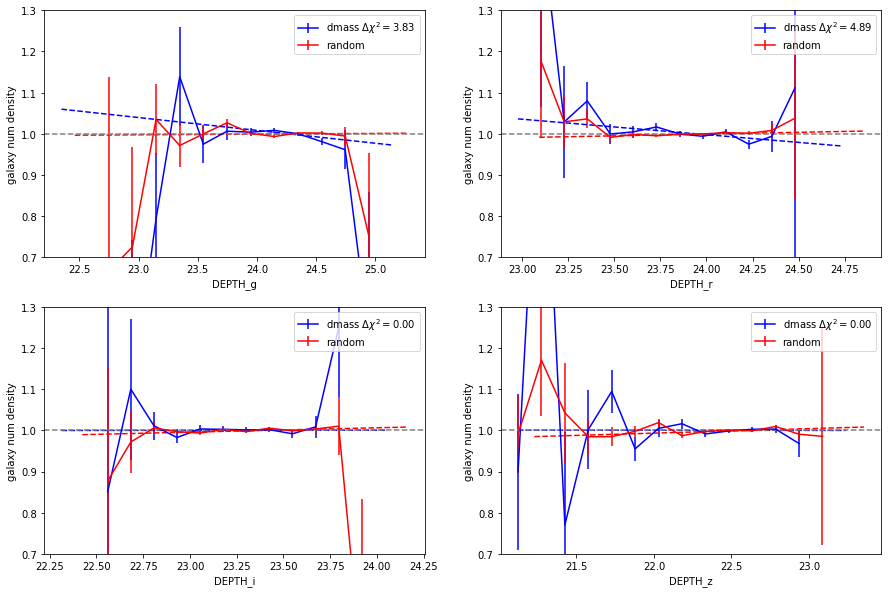

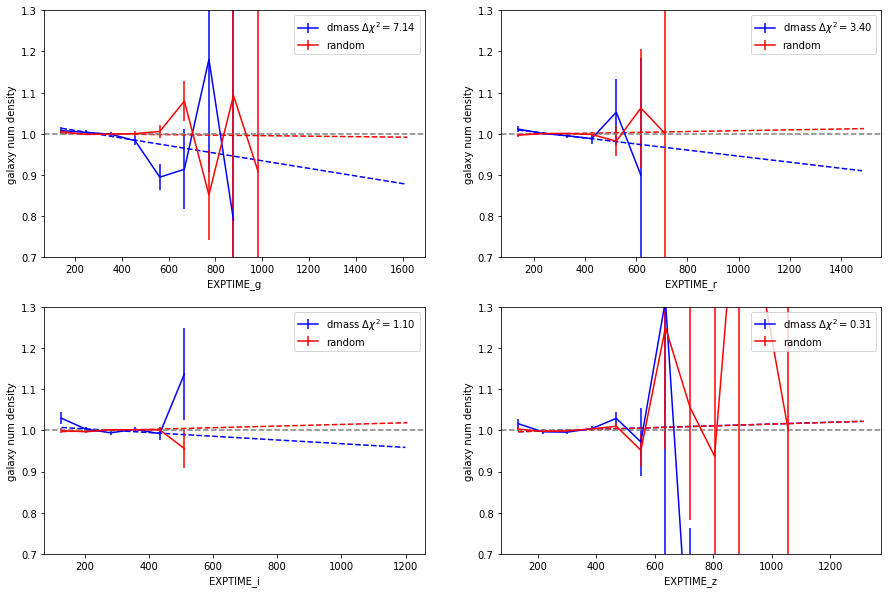

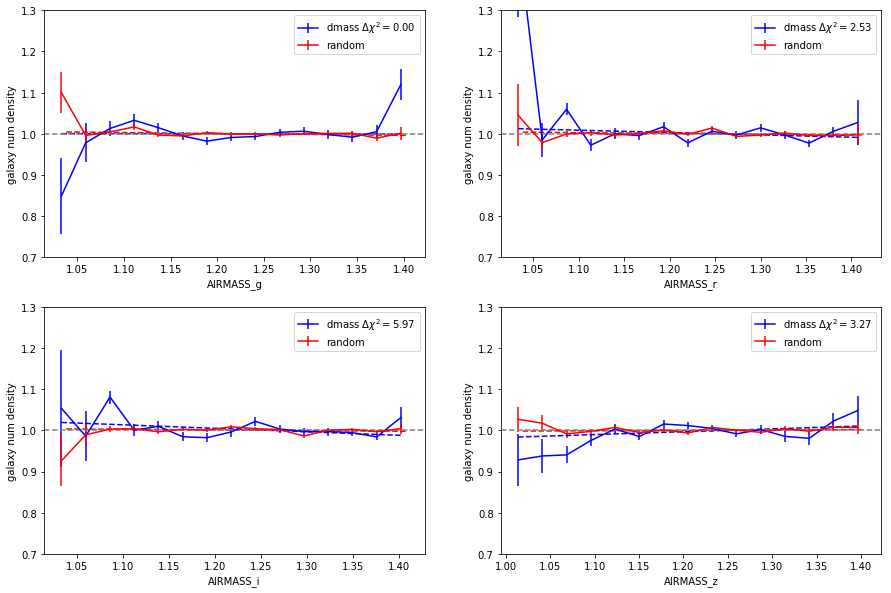

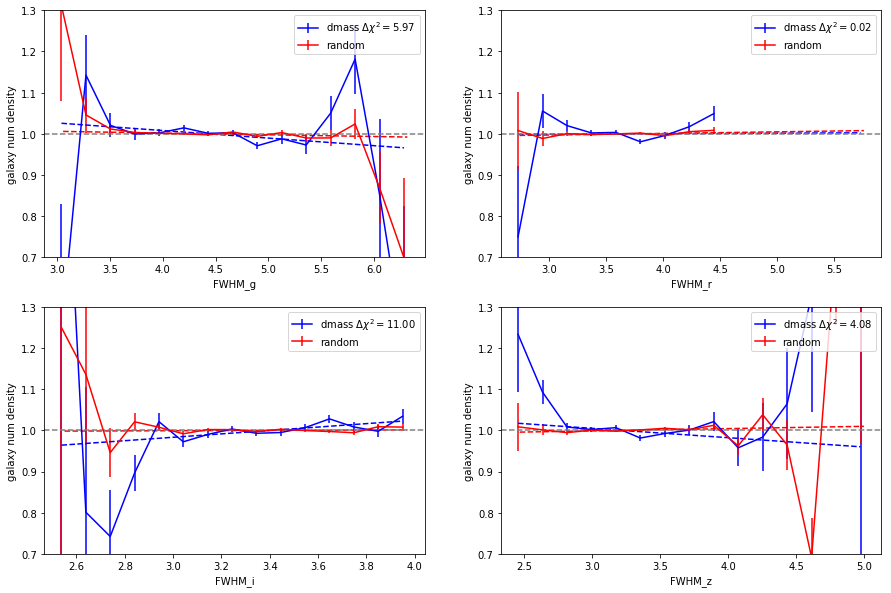

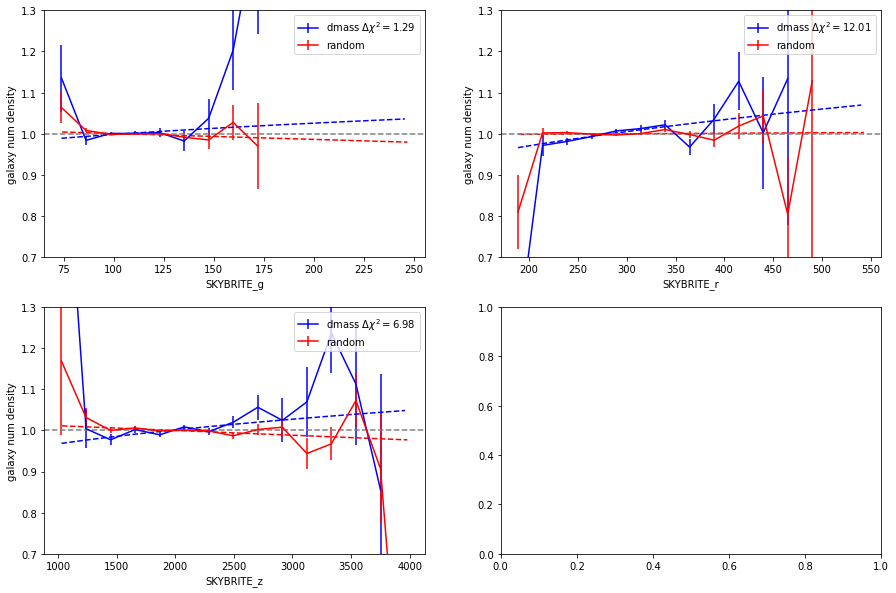

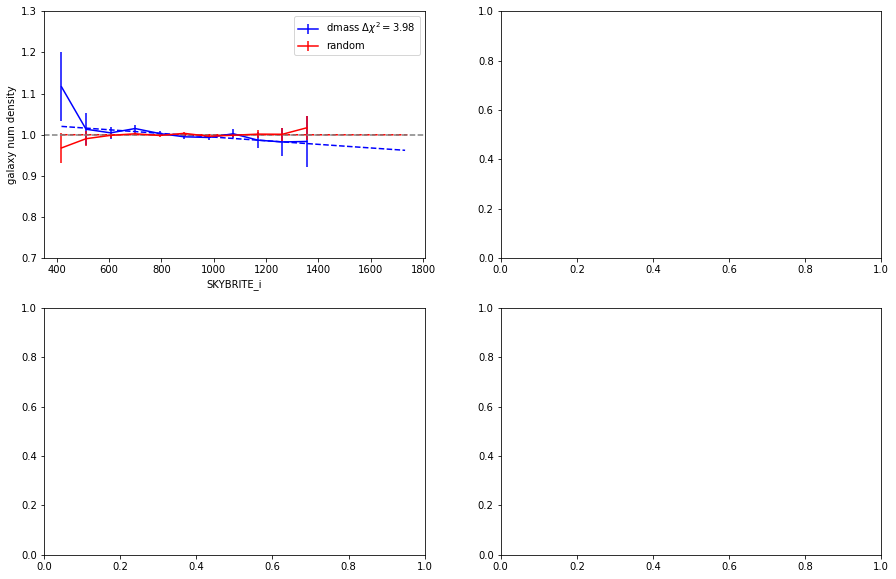

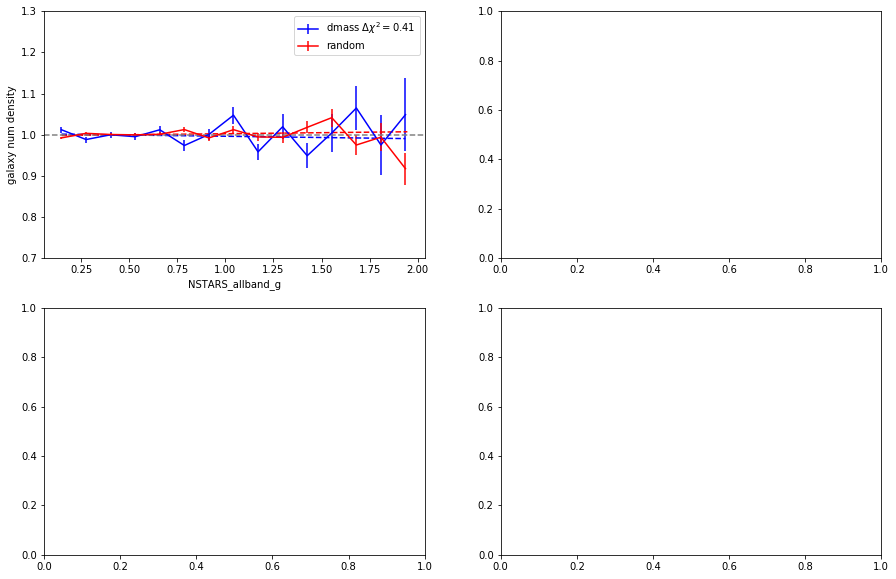

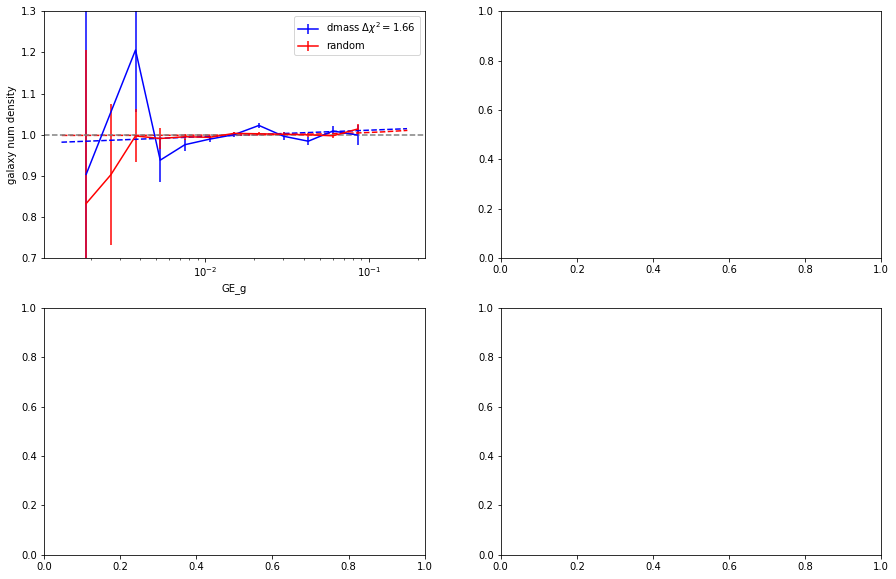

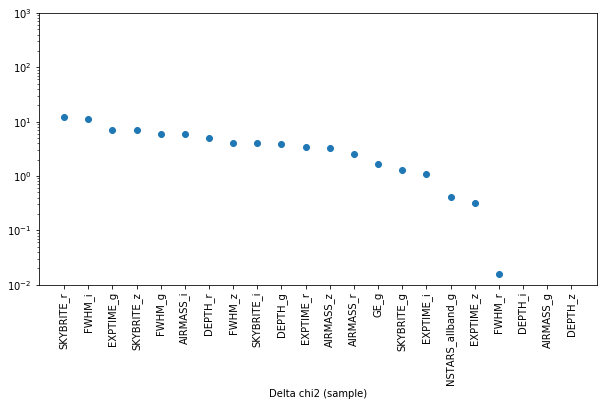

In [306]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)







----------------------------------
initialize function  SKYBRITE_r
sqrt
chi2_null =  32.87355404836019
chi2_mod. =  20.86378572243393
Delta chi2 (sample) = 12.00976832592626
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_SKYBRITE_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g.txt.model



KeyboardInterrupt: 

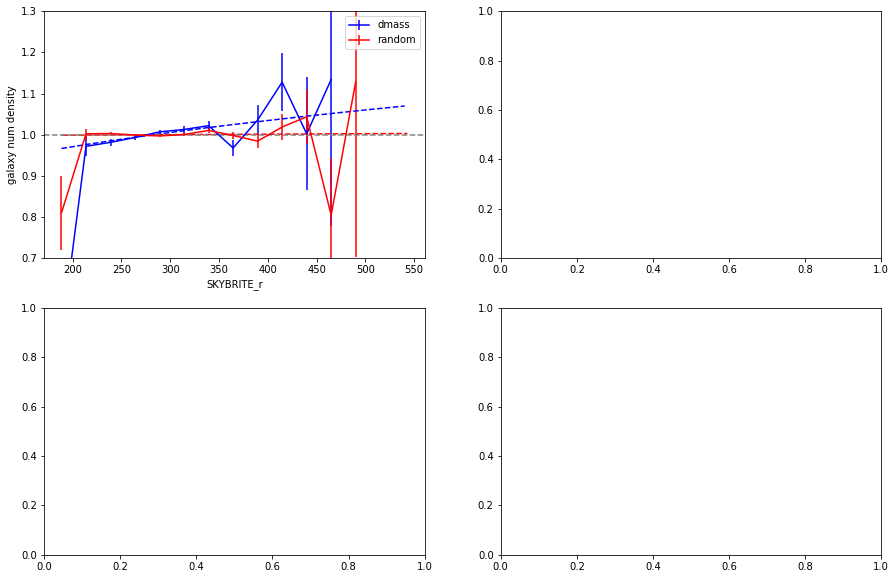

In [318]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] *\
* weightDic['AIRMASS_i'] * weightDic['SKYBRITE_i']*weightDic['AIRMASS_g']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g'
nextweight = 'SKYBRITE_r'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  14.855230985181592
chi2_mod. =  12.875199757970508
Delta chi2 (sample) = 1.980031227211084
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r.txt.model

chi2_null =  10.585107629957772
chi2_mod. =  9.921790091988722
Delta chi2 (sample) = 0.6633175379690499
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r.txt.model

chi2_null =  6.268797716407848
chi2_mod. =  5.531926810187288
Delta chi2 (sample) = 0.7368709062205596
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r.txt.model

chi2_null =  18.180368273475718
chi2_mod. =  17.975422946719668
Delta chi2 (sample) = 0.20494532675605015
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_

(['FWHM_i',
  'FWHM_g',
  'SKYBRITE_i',
  'EXPTIME_g',
  'AIRMASS_i',
  'FWHM_z',
  'SKYBRITE_z',
  'AIRMASS_z',
  'AIRMASS_r',
  'EXPTIME_r',
  'DEPTH_g',
  'GE_g',
  'DEPTH_i',
  'EXPTIME_z',
  'DEPTH_r',
  'NSTARS_allband_g',
  'EXPTIME_i',
  'FWHM_r',
  'DEPTH_z',
  'SKYBRITE_g',
  'SKYBRITE_r',
  'AIRMASS_g'],
 [10.592613910836121,
  8.032116585811579,
  7.808334876382168,
  5.779633085956881,
  5.724294999876868,
  4.897085502561286,
  4.326150169934127,
  3.6488945676385676,
  3.39761978948858,
  2.0449298406543353,
  1.980031227211084,
  1.511716665722556,
  0.7368709062205596,
  0.709057693664306,
  0.6633175379690499,
  0.4439381279772334,
  0.4071651678133925,
  0.3941680166966677,
  0.20494532675605015,
  0.06568989785011681,
  0.05421324021221707,
  0.011776276058675705])

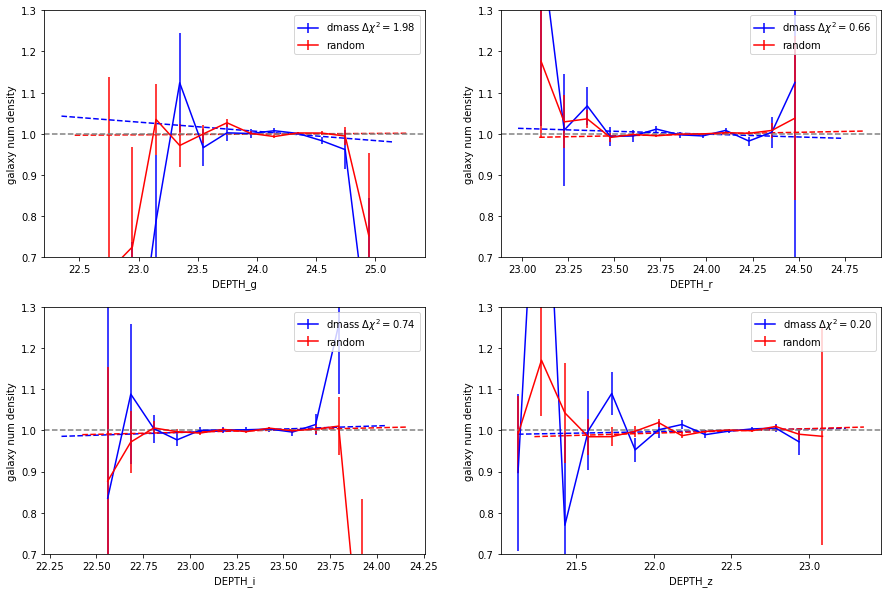

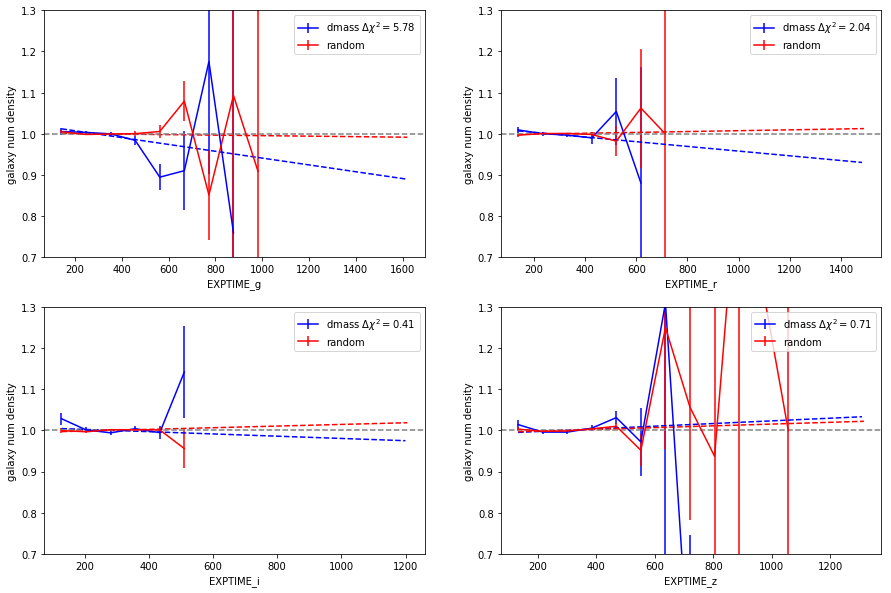

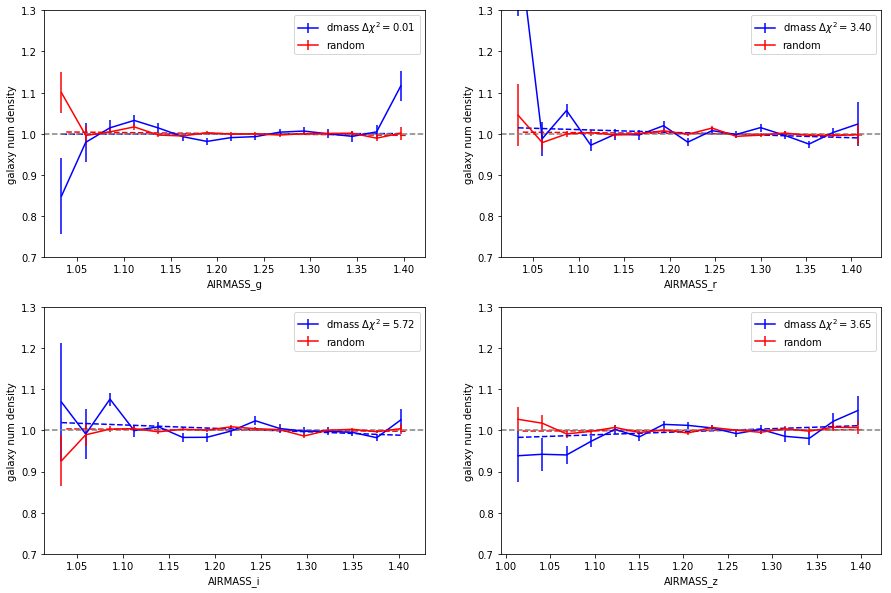

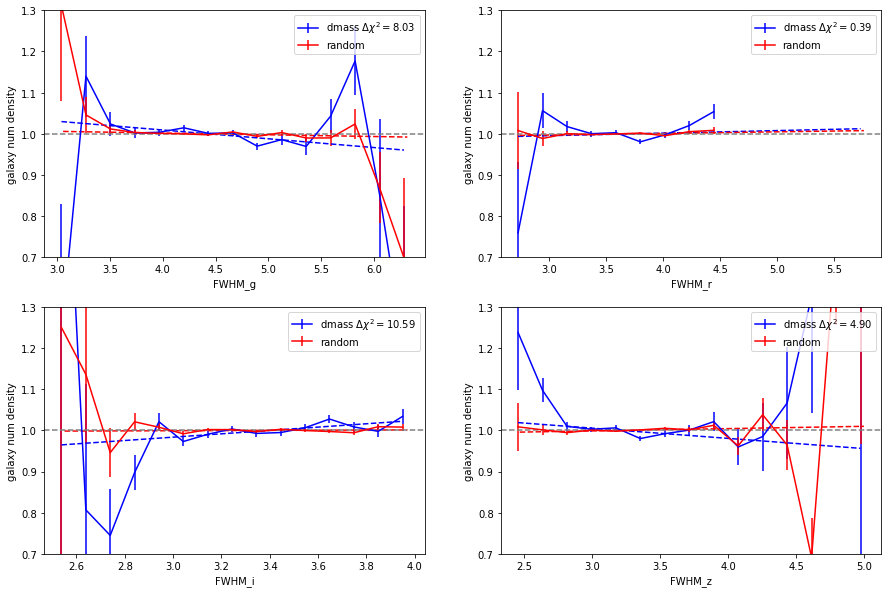

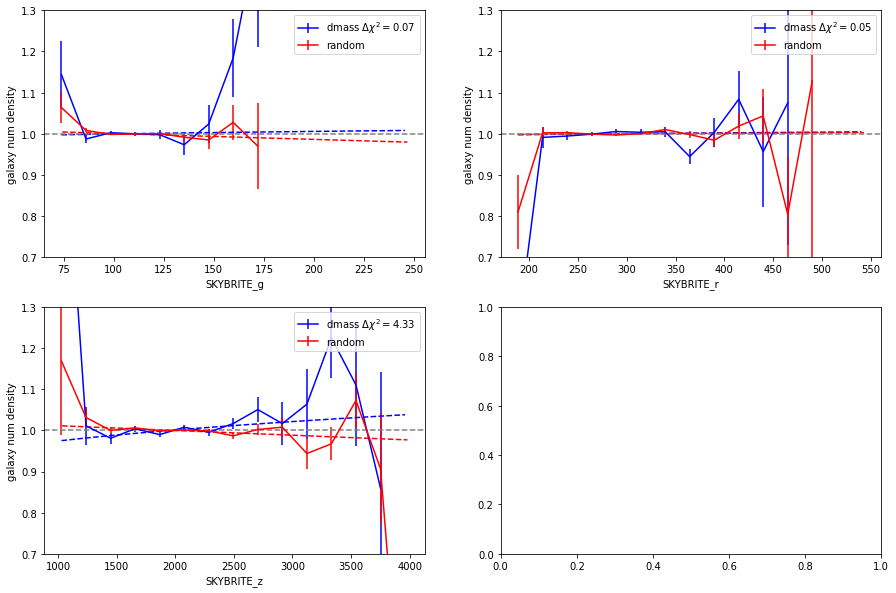

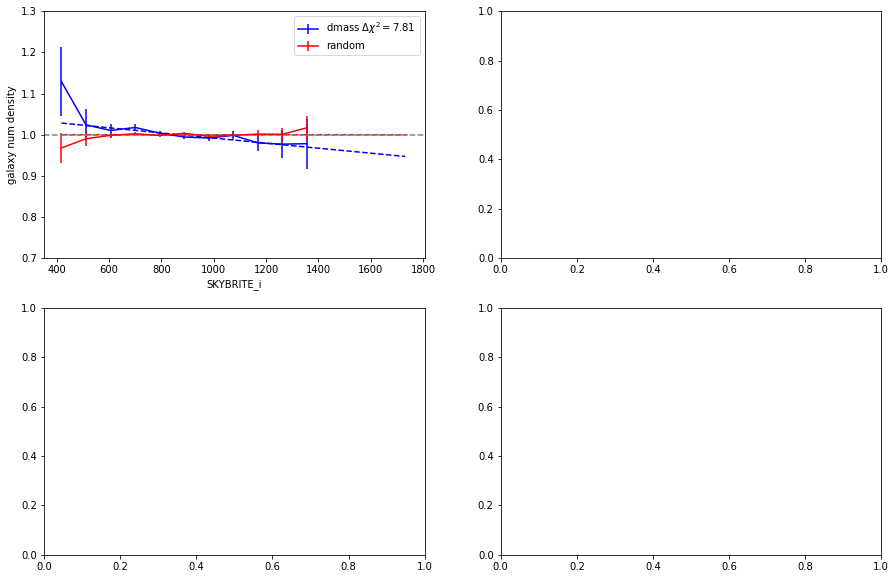

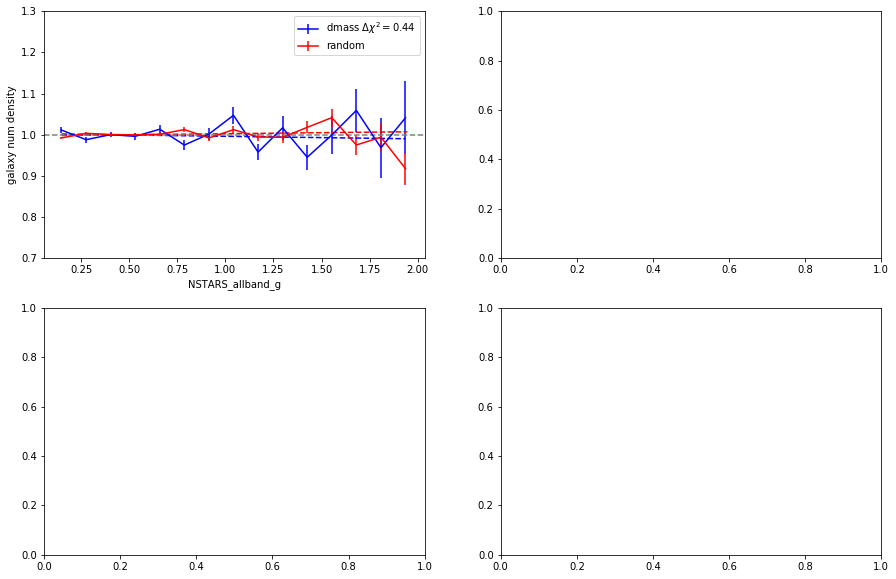

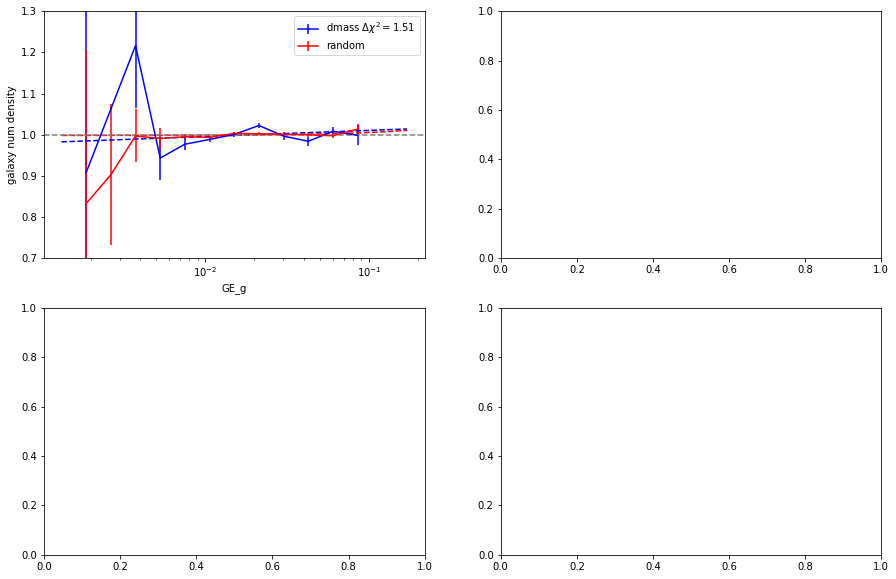

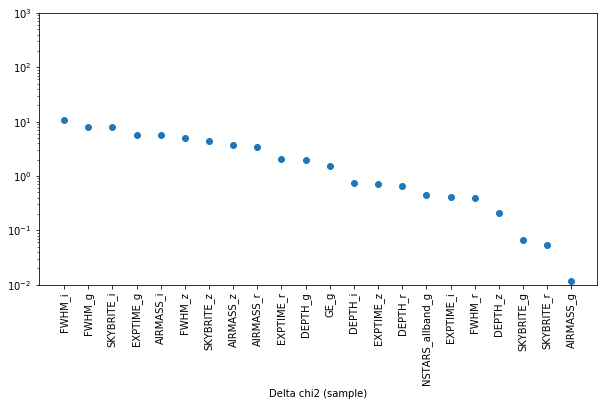

In [309]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)


----------------------------------
initialize function  FWHM_i
linear
chi2_null =  31.67977207013779
chi2_mod. =  21.08715815930167
Delta chi2 (sample) = 10.592613910836121
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_FWHM_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r.txt.model

106857
store weight  FWHM_i
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_fwhm_i_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt


0

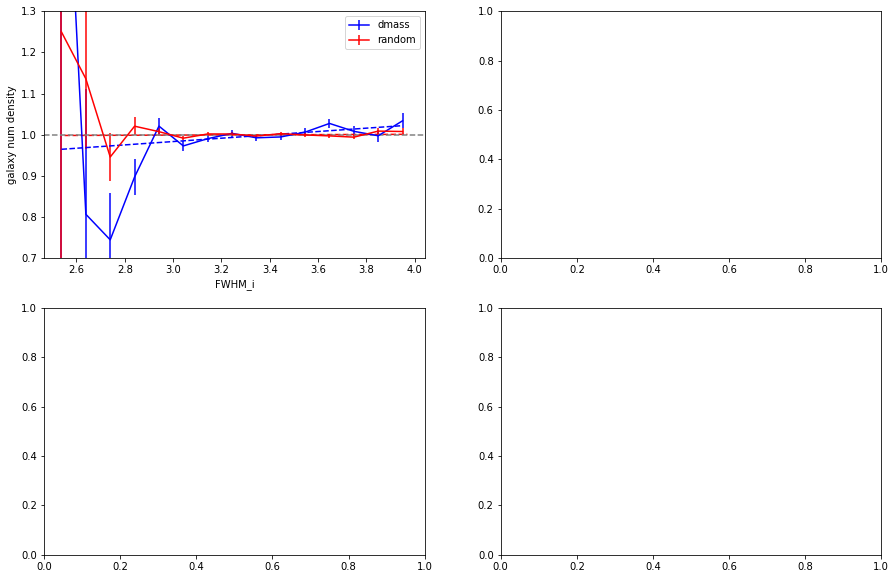

In [313]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] *\
* weightDic['AIRMASS_i'] * weightDic['SKYBRITE_i']*weightDic['AIRMASS_g']*weightDic['SKYBRITE_r']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r'
nextweight = 'FWHM_i'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  14.90461315922676
chi2_mod. =  12.706521785396449
Delta chi2 (sample) = 2.1980913738303105
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt.model

chi2_null =  10.717647077038
chi2_mod. =  9.900154725134005
Delta chi2 (sample) = 0.8174923519039954
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt.model

chi2_null =  5.597133432010104
chi2_mod. =  5.388287645572854
Delta chi2 (sample) = 0.20884578643724971
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt.model

chi2_null =  18.131429399815953
chi2_mod. =  17.954278082912513
Delta chi2 (sample) = 0.17715131690344066
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_z_SPT_wg_ge_g_fwhm_r

(['FWHM_g',
  'FWHM_z',
  'EXPTIME_g',
  'SKYBRITE_z',
  'SKYBRITE_i',
  'AIRMASS_z',
  'AIRMASS_i',
  'EXPTIME_r',
  'DEPTH_g',
  'AIRMASS_r',
  'GE_g',
  'DEPTH_r',
  'EXPTIME_z',
  'EXPTIME_i',
  'NSTARS_allband_g',
  'DEPTH_i',
  'FWHM_r',
  'AIRMASS_g',
  'DEPTH_z',
  'SKYBRITE_g',
  'SKYBRITE_r',
  'FWHM_i'],
 [9.955220583811393,
  6.145202182721128,
  5.809357992760267,
  4.578508242543425,
  4.482338483262851,
  3.8891695660459042,
  2.632976779047354,
  2.266975842485146,
  2.1980913738303105,
  1.9548754716959422,
  1.3877310230959417,
  0.8174923519039954,
  0.6751525929825011,
  0.475978845818231,
  0.3751583698153773,
  0.20884578643724971,
  0.20590116311571194,
  0.20471268436022427,
  0.17715131690344066,
  0.13012352702498475,
  0.03401330876847908,
  0.0014397759873183702])

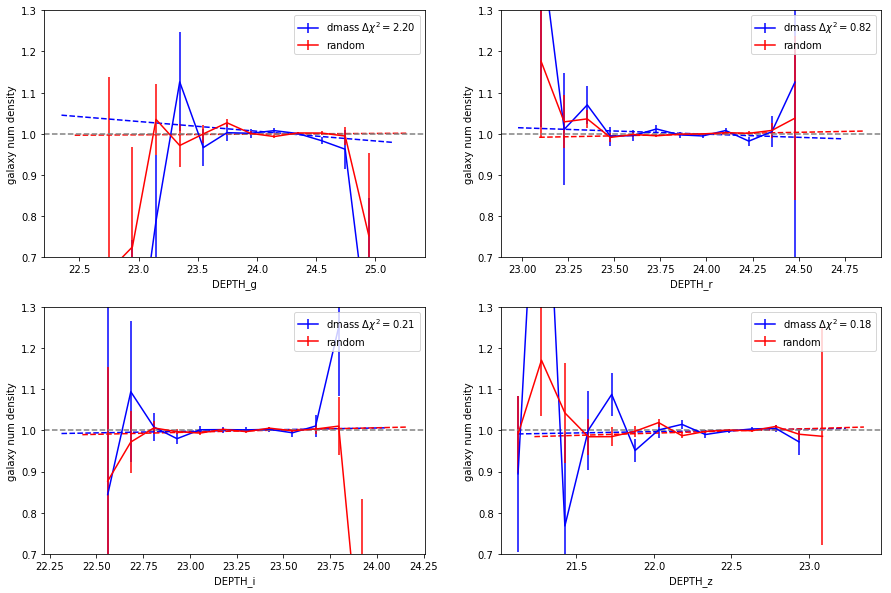

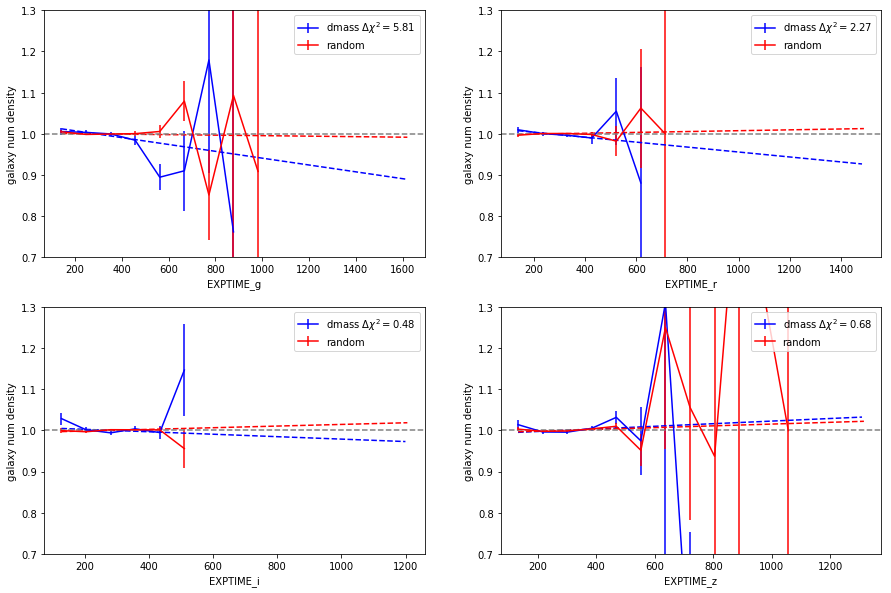

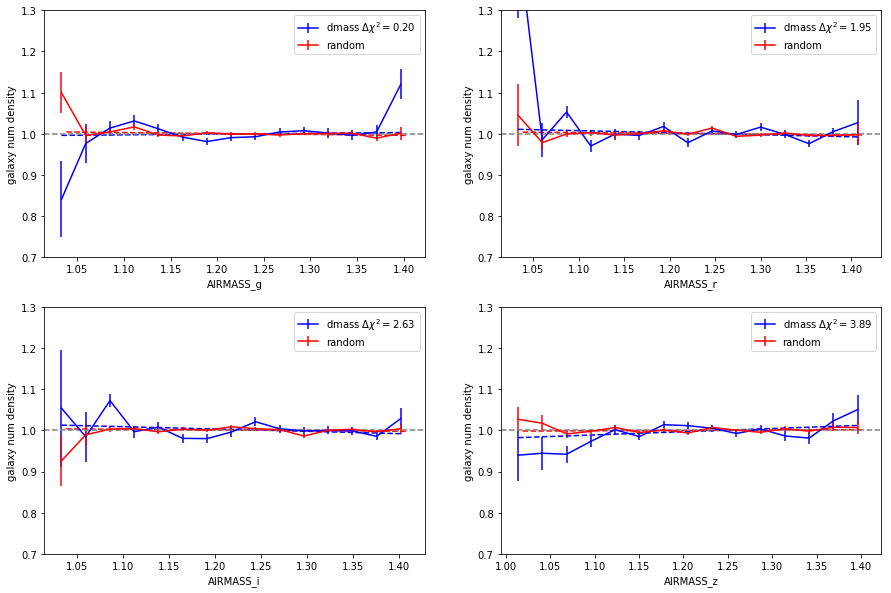

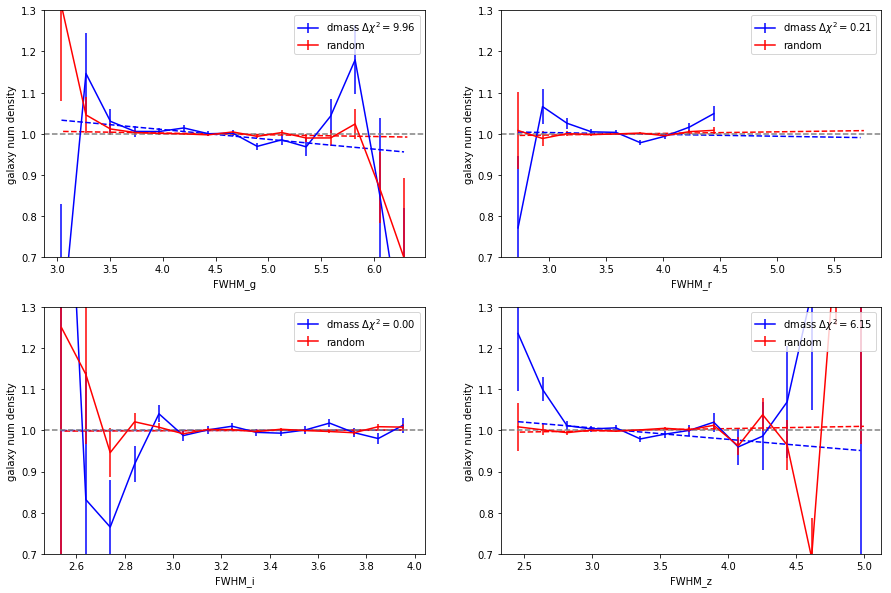

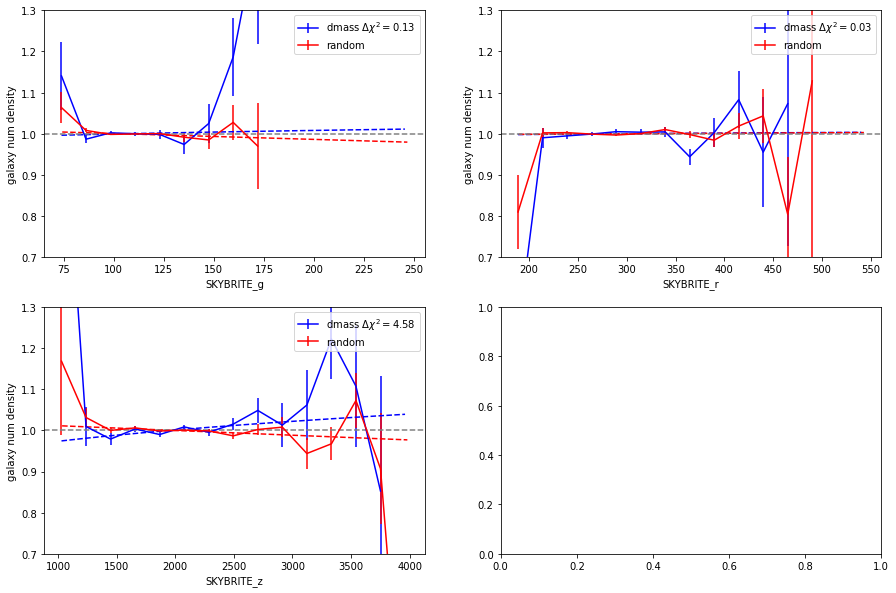

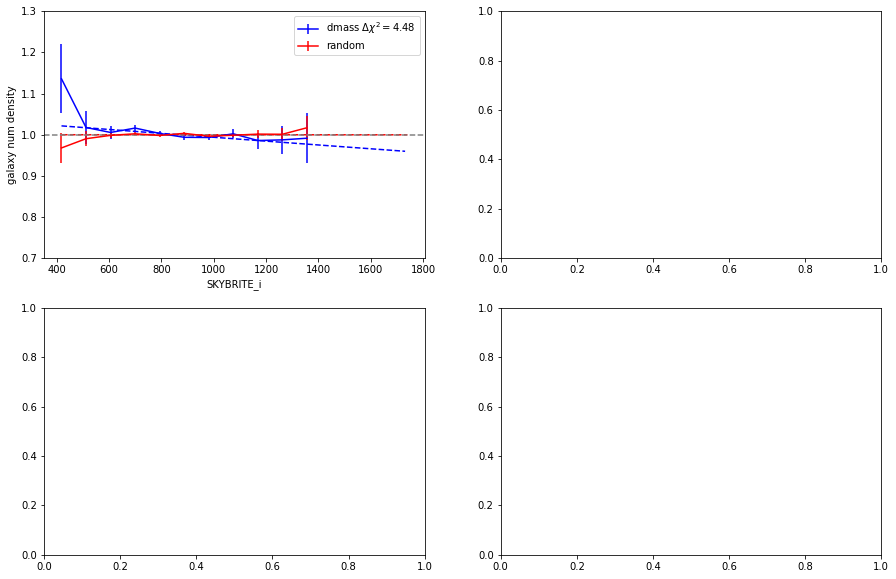

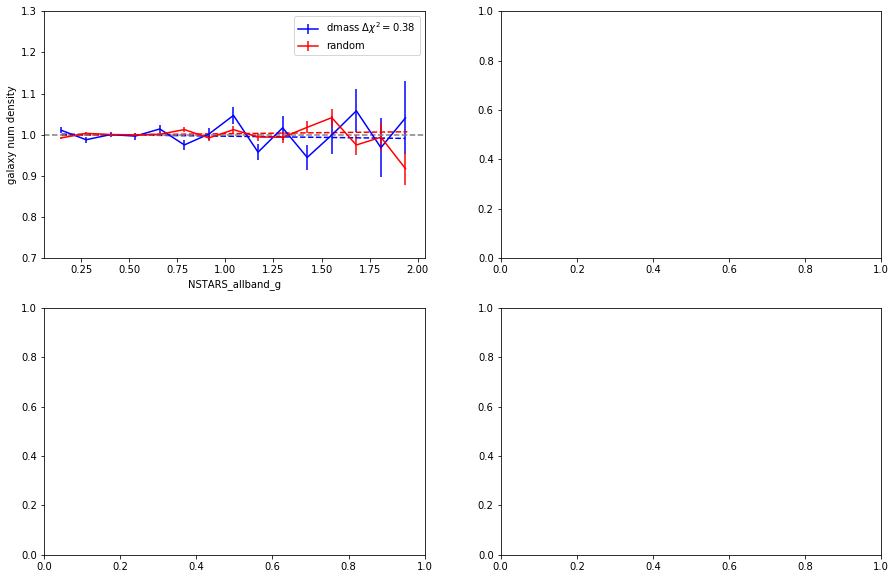

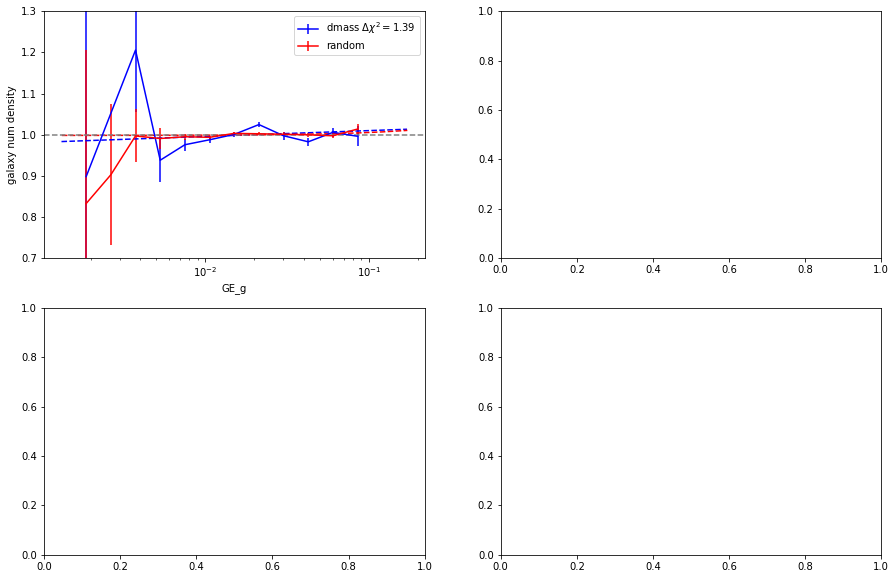

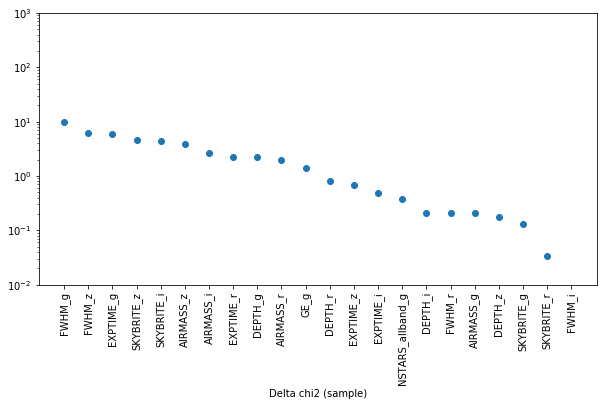

In [314]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)



----------------------------------
initialize function  FWHM_g
linear
chi2_null =  34.813786932415695
chi2_mod. =  24.858566348604302
Delta chi2 (sample) = 9.955220583811393
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_FWHM_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i.txt.model

106857
store weight  FWHM_g
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_fwhm_g_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_air

0

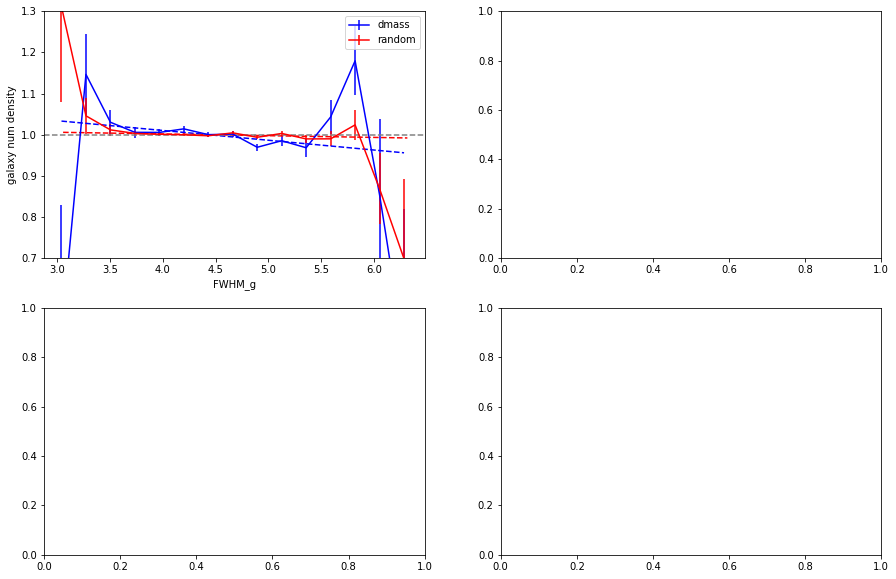

In [315]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] \
* weightDic['AIRMASS_i'] * weightDic['SKYBRITE_i']*weightDic['AIRMASS_g']*weightDic['SKYBRITE_r']*\
weightDic['FWHM_i']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i'
nextweight = 'FWHM_g'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='linear', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  11.777174313307558
chi2_mod. =  11.107156955605582
Delta chi2 (sample) = 0.6700173577019761
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt.model

chi2_null =  10.936606699547204
chi2_mod. =  10.431951943718385
Delta chi2 (sample) = 0.5046547558288186
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt.model

chi2_null =  6.144329152547966
chi2_mod. =  5.640696637683875
Delta chi2 (sample) = 0.5036325148640914
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt.model

chi2_null =  18.768617329356676
chi2_mod. =  18.424934008493068
Delta chi2 (sample) = 0.3436833208636081
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DE

(['AIRMASS_i',
  'AIRMASS_z',
  'SKYBRITE_z',
  'AIRMASS_g',
  'AIRMASS_r',
  'NSTARS_allband_g',
  'FWHM_z',
  'SKYBRITE_g',
  'EXPTIME_g',
  'FWHM_i',
  'FWHM_g',
  'EXPTIME_z',
  'EXPTIME_r',
  'DEPTH_g',
  'SKYBRITE_r',
  'DEPTH_r',
  'DEPTH_i',
  'EXPTIME_i',
  'FWHM_r',
  'GE_g',
  'DEPTH_z',
  'SKYBRITE_i'],
 [19.87778693245827,
  15.949139922869819,
  14.786474905902288,
  12.408539123103523,
  10.207239872333737,
  7.152243533784162,
  4.128576187168935,
  3.297119165651303,
  1.9652284011752847,
  1.8763839459476905,
  1.7979014273037208,
  1.6475142653861,
  1.2960013981660454,
  0.6700173577019761,
  0.6002530030131688,
  0.5046547558288186,
  0.5036325148640914,
  0.47532325767119676,
  0.4571059563488866,
  0.38972833686562325,
  0.3436833208636081,
  0.3062373933709095])

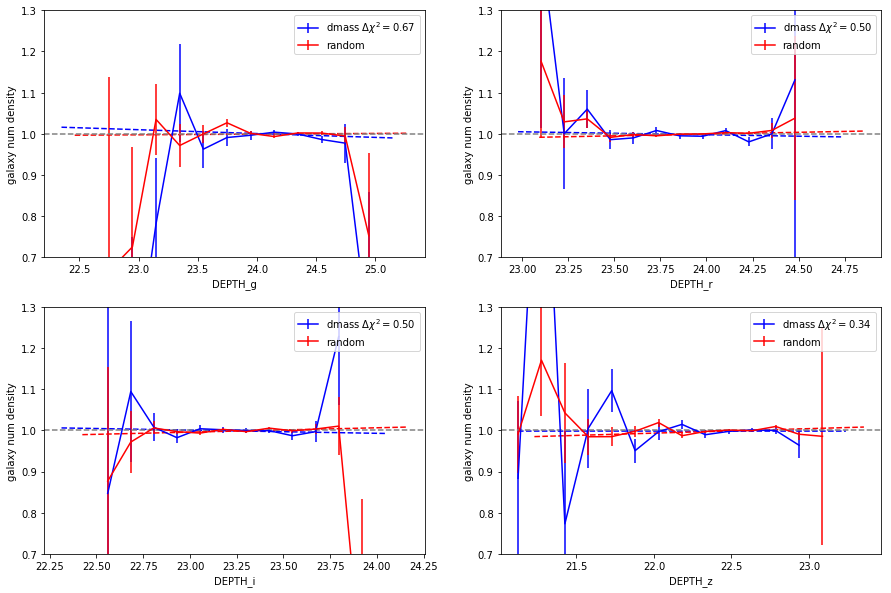

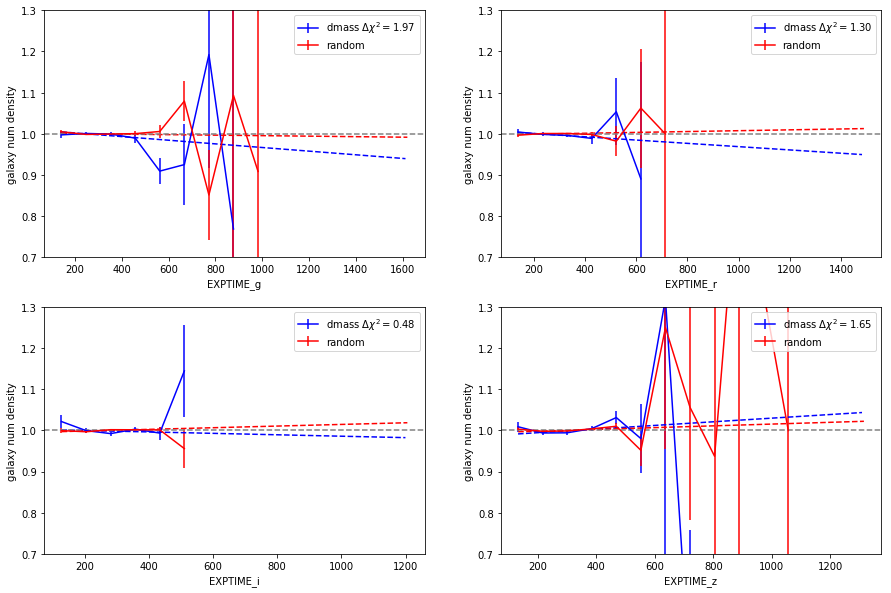

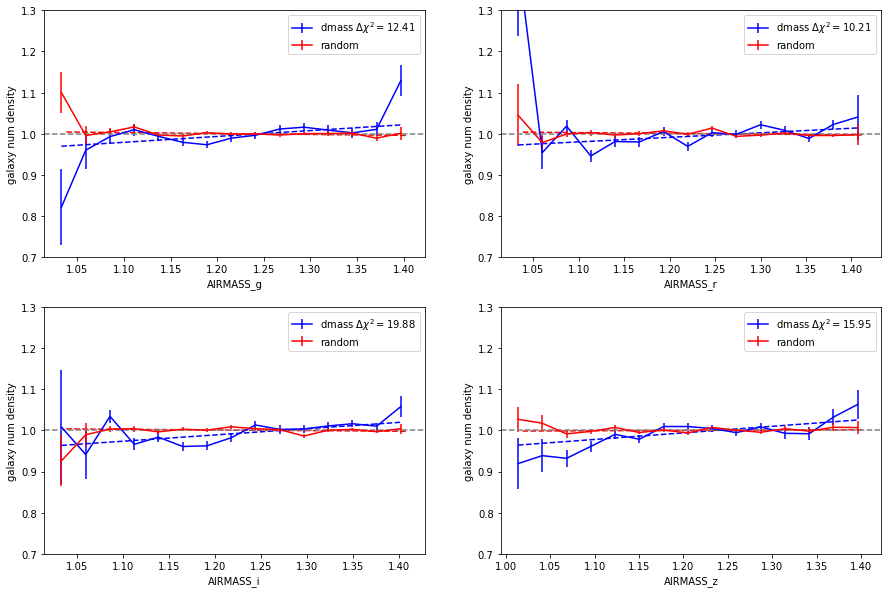

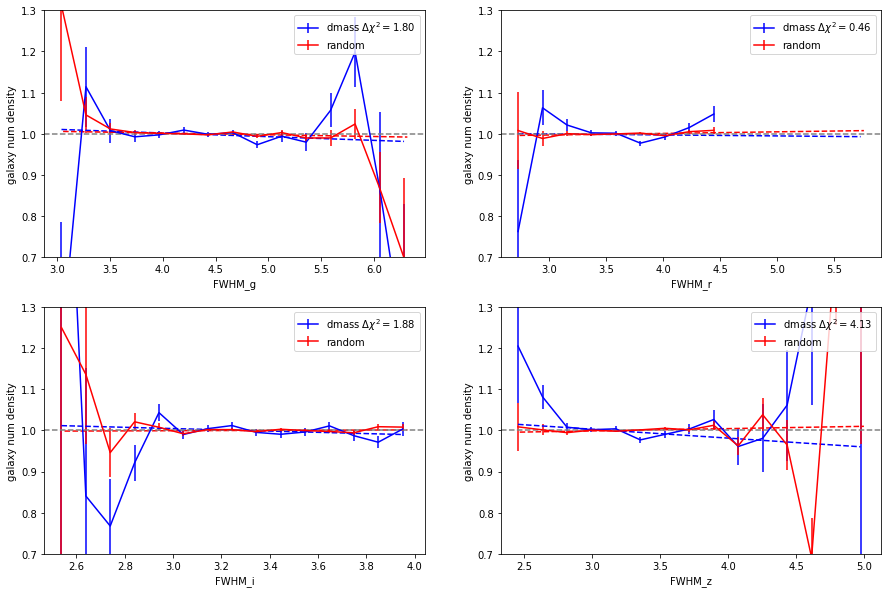

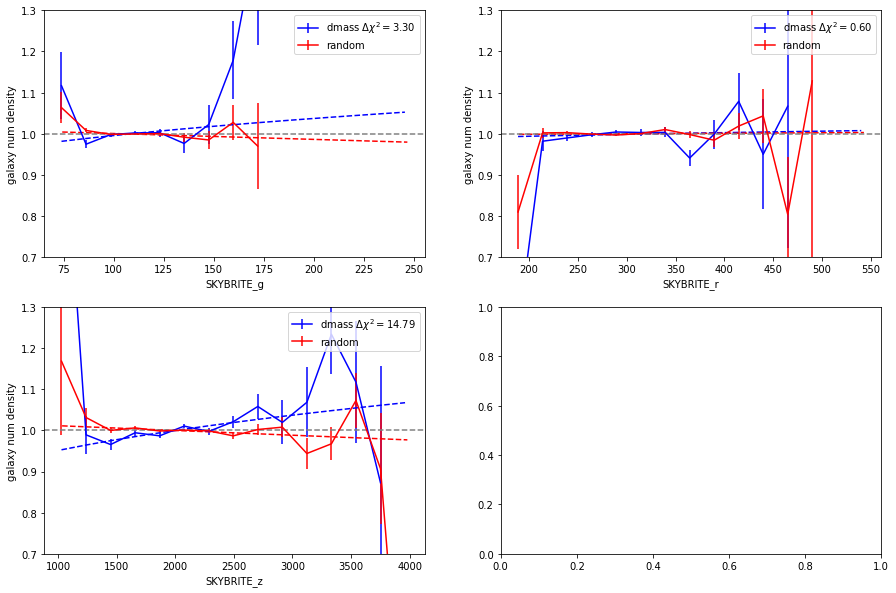

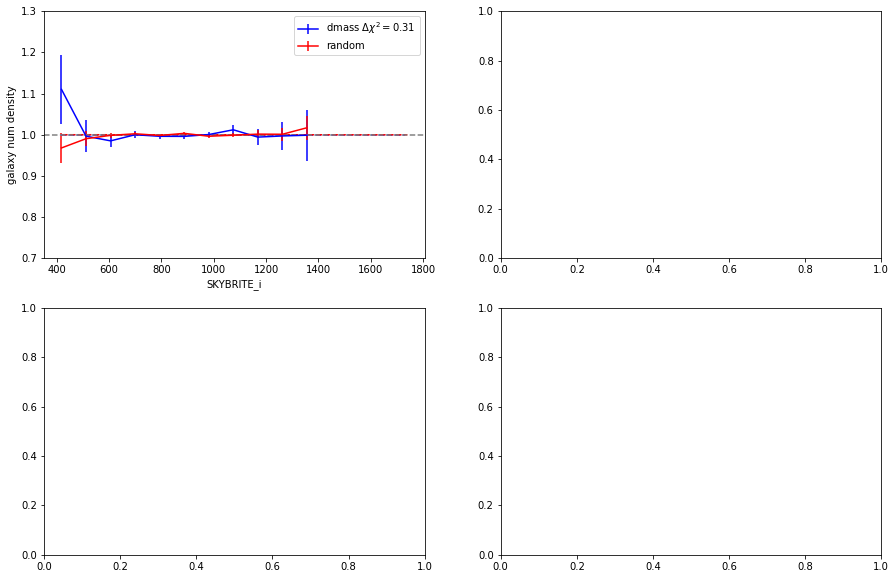

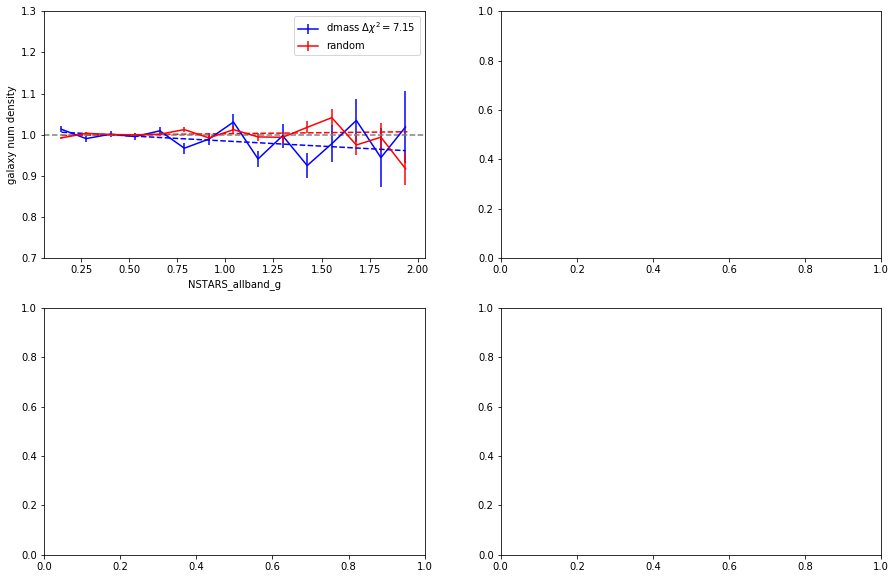

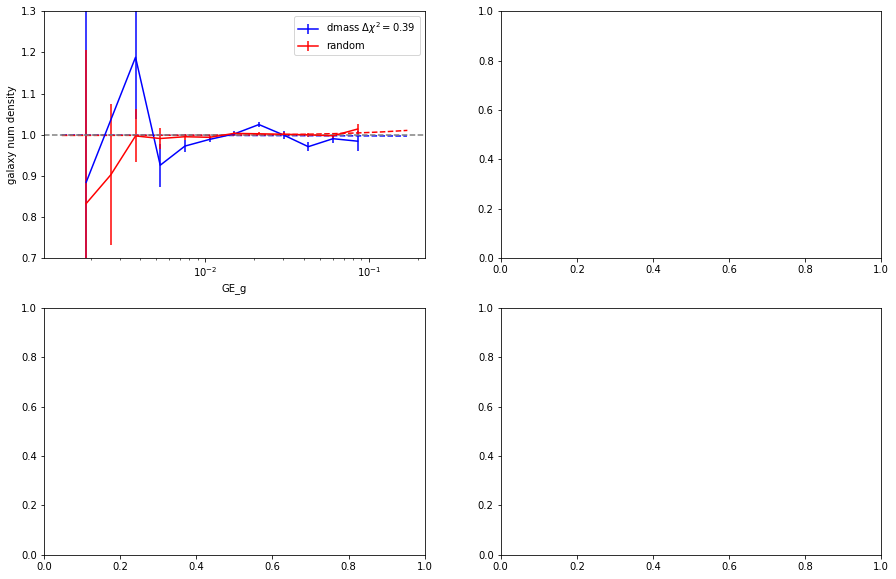

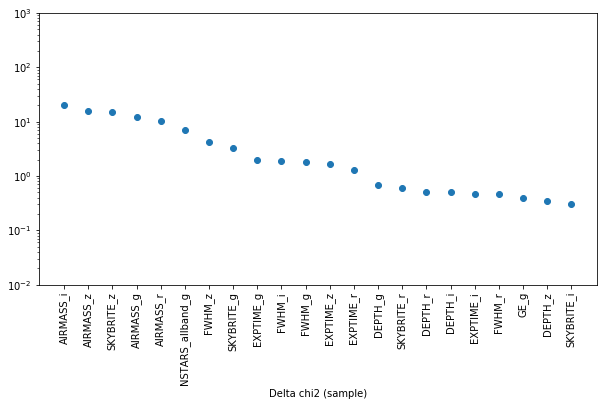

In [316]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)




In [317]:
inputdir

'../data_txt/systematics/exp_i_fwhm_r_ge/'

----------------------------------
initialize function  SKYBRITE_z
sqrt
chi2_null =  32.40219205527176
chi2_mod. =  17.615717149369473
Delta chi2 (sample) = 14.786474905902288
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_SKYBRITE_z_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g.txt.model

106857
store weight  SKYBRITE_z
save weight to fits ../data_txt/systematics/exp_i_fwhm_r_ge//weights/wg_skybrite_z_SPT.fits
suffix =  wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z.txt
saving data to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i

0

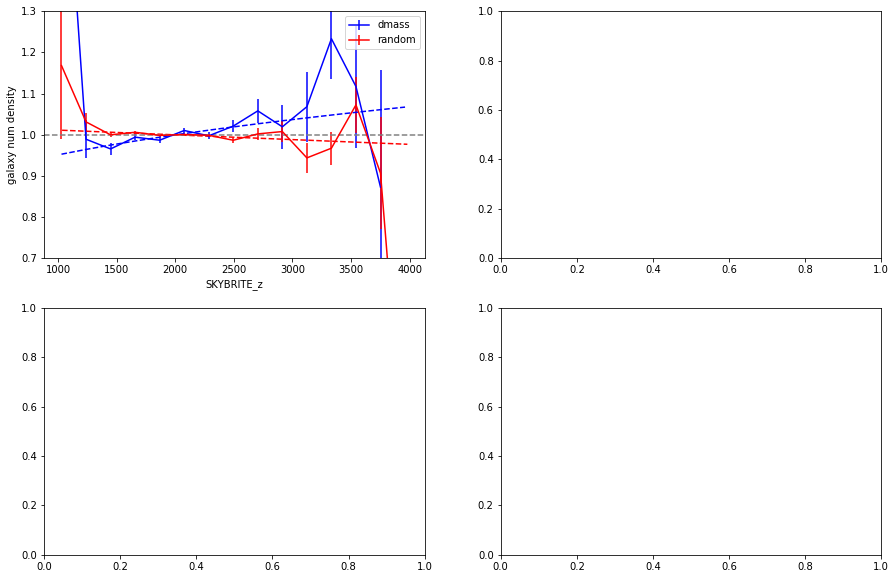

In [319]:
all_weight = weightDic['noweight'] * weightDic['GE_g'] * weightDic['FWHM_r'] * weightDic['AIRMASS_z'] \
* weightDic['AIRMASS_i'] * weightDic['SKYBRITE_i']*weightDic['AIRMASS_g']*weightDic['SKYBRITE_r']*\
weightDic['FWHM_i']*weightDic['FWHM_g']
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g'
nextweight = 'SKYBRITE_z'

sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight, 
                  cat1=dmass_masked, cat2=rand_masked, rand1 = rand2_masked, rand2=rand2_masked,
                  sysMap = sysMap, nside=4096, kind='SPT', function='sqrt', function2 = None,
                  properties = properties, filters=['g', 'r', 'i', 'z'],
                  path=inputdir, plot=True, weightDic=weightDic, FullArea=SPTMaparea )

chi2_null =  12.090183118321924
chi2_mod. =  11.806837235571098
Delta chi2 (sample) = 0.28334588275082595
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_g_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z.txt.model

chi2_null =  10.06680195327671
chi2_mod. =  10.046080590250787
Delta chi2 (sample) = 0.020721363025923978
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_r_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z.txt.model

chi2_null =  5.458040569780366
chi2_mod. =  5.425617051594943
Delta chi2 (sample) = 0.03242351818542222
output save to  ../data_txt/systematics/exp_i_fwhm_r_ge/systematic_DEPTH_i_SPT_wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z.txt.model

chi2_null =  19.49397372675522
chi2_mod. =  16.851605395728342
Delta chi2 (sample) = 2.64236833102688
output save to  ../data_txt/systemat

(['AIRMASS_i',
  'AIRMASS_z',
  'AIRMASS_g',
  'AIRMASS_r',
  'FWHM_z',
  'NSTARS_allband_g',
  'DEPTH_z',
  'EXPTIME_g',
  'EXPTIME_z',
  'FWHM_i',
  'SKYBRITE_g',
  'FWHM_g',
  'EXPTIME_r',
  'GE_g',
  'DEPTH_g',
  'SKYBRITE_i',
  'EXPTIME_i',
  'SKYBRITE_r',
  'SKYBRITE_z',
  'DEPTH_i',
  'DEPTH_r',
  'FWHM_r'],
 [11.368229759054458,
  8.368059954914123,
  7.552271098382668,
  4.318160325344458,
  3.3708476239070144,
  2.6447419885259187,
  2.64236833102688,
  1.8035304066361242,
  1.7774864877320464,
  1.402494520605721,
  1.093282634947613,
  1.084311104646062,
  0.7468746201225064,
  0.41569600348586633,
  0.28334588275082595,
  0.08856800005082288,
  0.034144479526205807,
  0.033462073186033336,
  0.03305510092379649,
  0.03242351818542222,
  0.020721363025923978,
  0.007188315581121429])

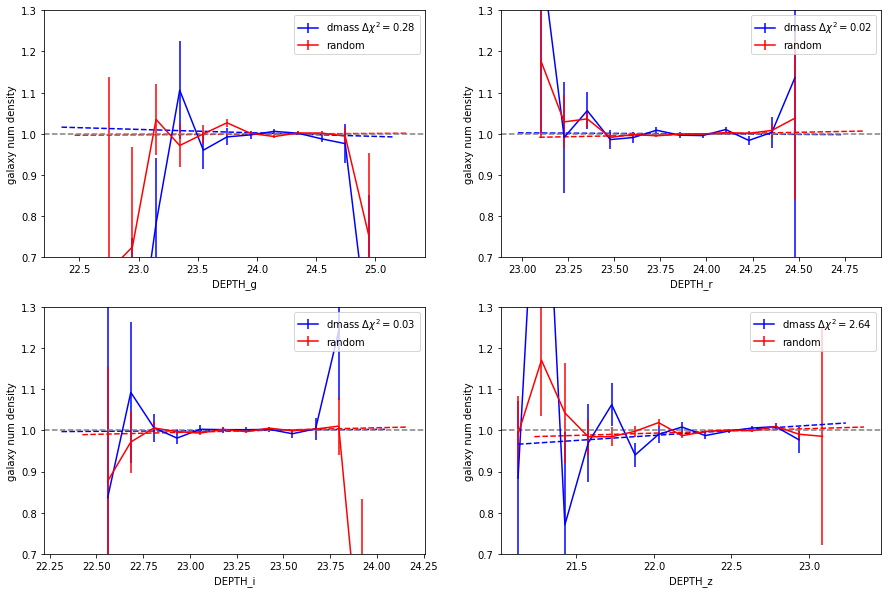

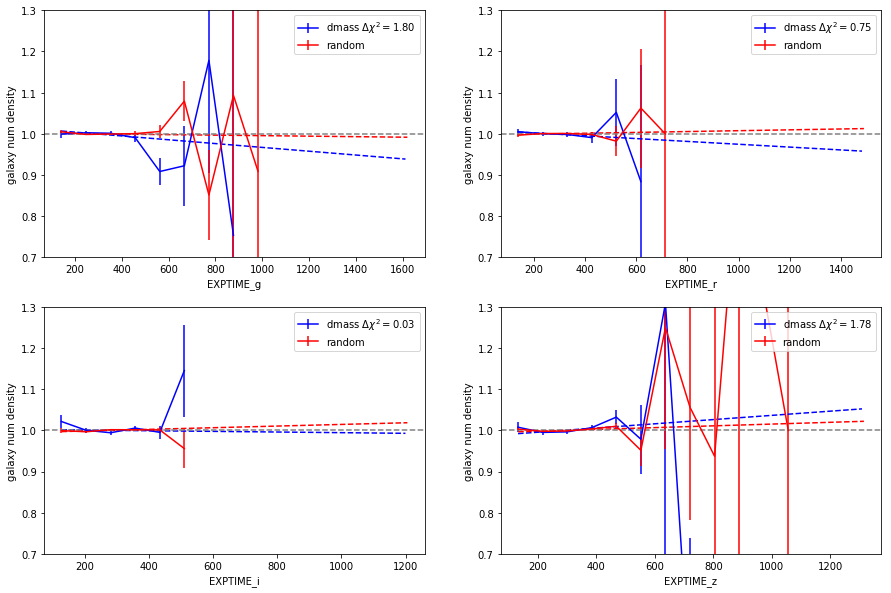

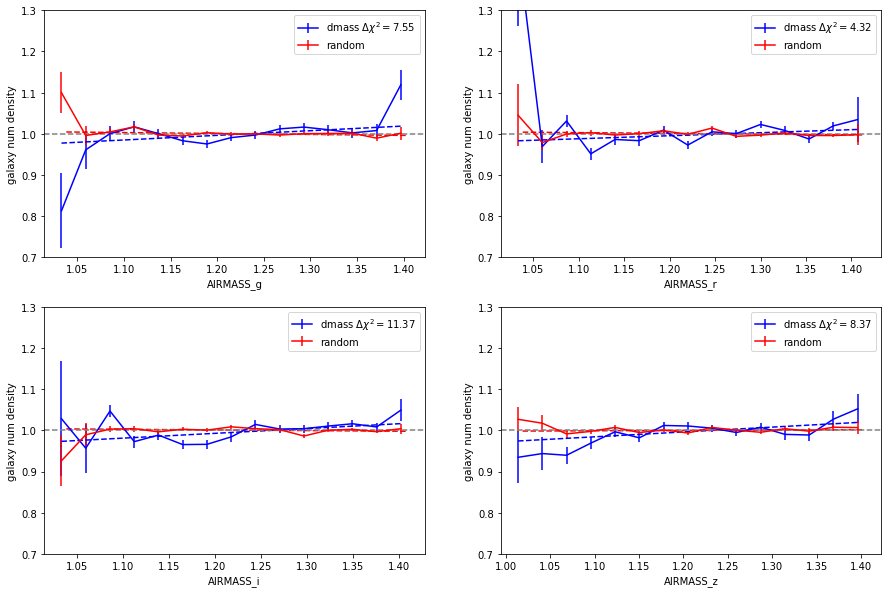

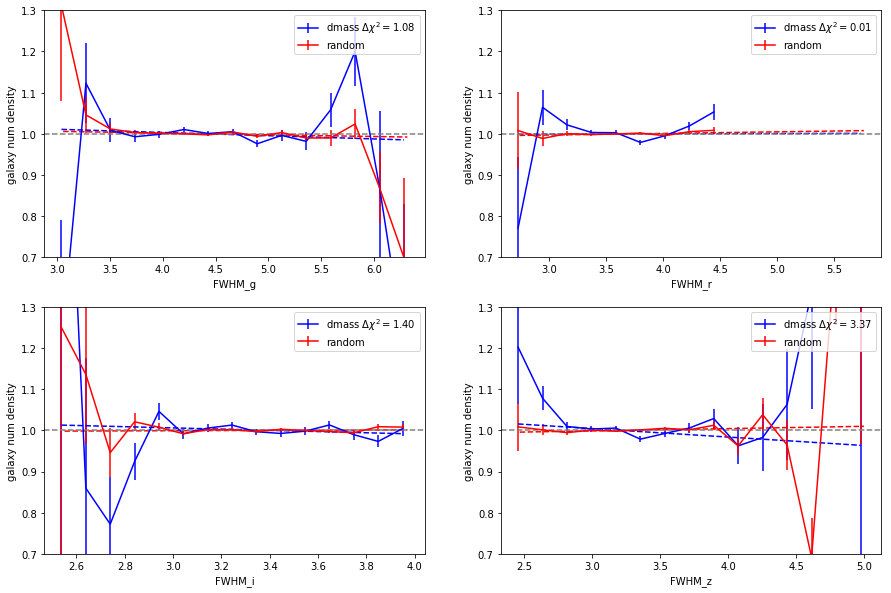

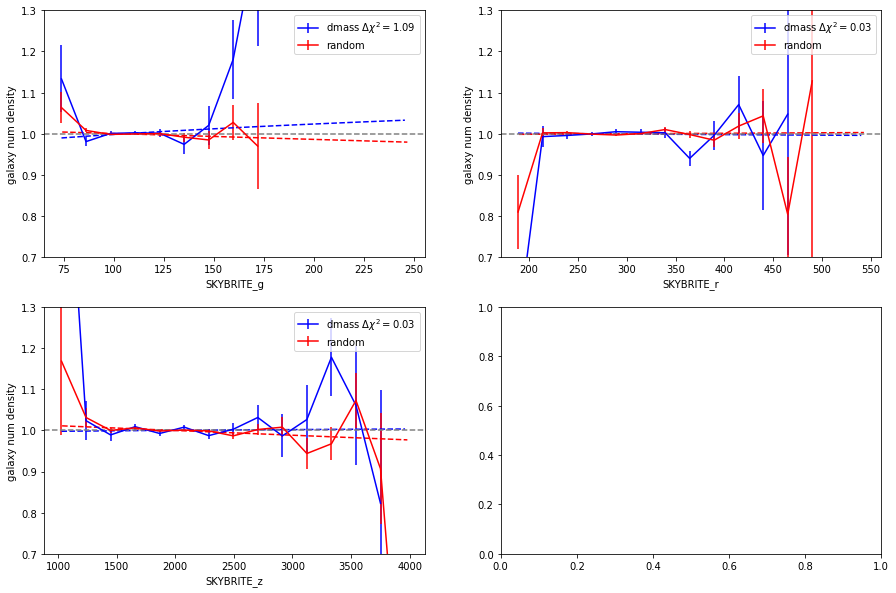

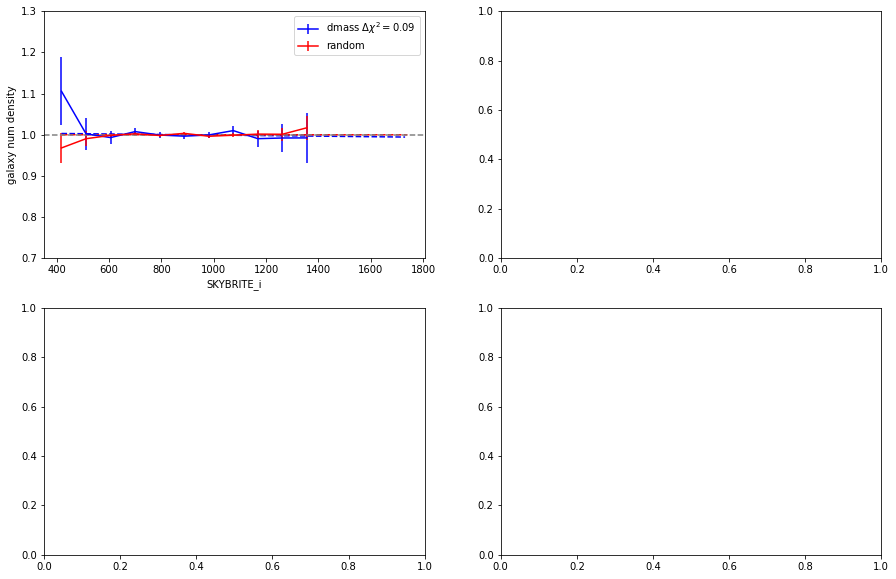

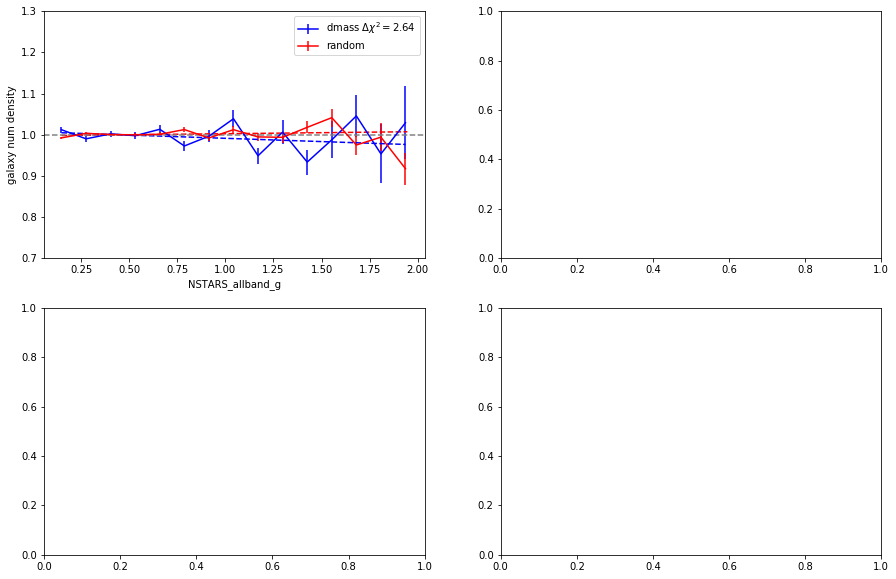

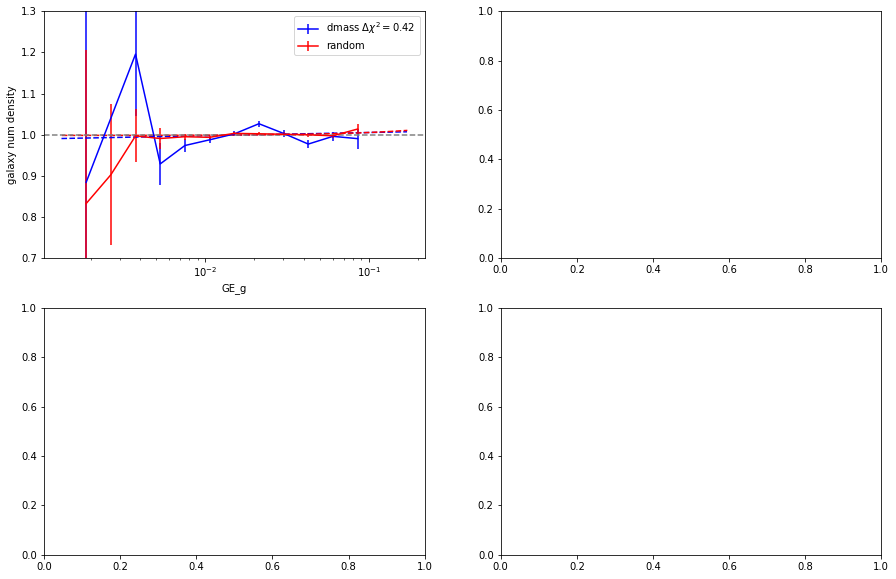

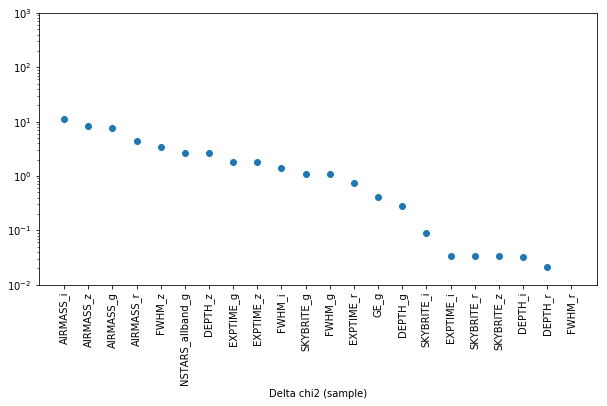

In [320]:
suffix = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z'
filters = ['g', 'r', 'i', 'z']

fitting_SP( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'FWHM'], filter=filters, kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter= ['g', 'r', 'z'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'sqrt',
                path = inputdir )

fitting_SP( property = ['SKYBRITE'], filter=['i'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'errftn',
            path = inputdir )

fitting_SP( property = ['NSTARS_allband'], filter=['g'], kind = 'SPT', 
           suffix=suffix, plot=True, function = 'linear',
                path = inputdir )

fitting_SP( property = ['GE'], filter=['g'], kind = 'SPT', suffix=suffix, plot=True, function = 'log',
                path = inputdir )



plotting_significance( property = properties, filter=['g', 'r', 'i','z'], kind = kind, 
                      suffix=suffix, 
                path = inputdir, deltachi2=True)





In [328]:
suffix

'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z'

[230.57732343563413, 166.95177687128572, 85.56095616380422, 78.57005719044274, 58.498050439396216, 52.26310662357321, 43.69925065144632, 23.964403397512875, 21.805957037265284, 18.241042978002476, 14.950241166510487, 5.670962309217895, 4.972212829773746, 2.5442512023209716, 1.8695471648117916, 1.6884343795088093, 0.852358603178601, 0.5409934428451599, 0.25198477936920227, 0.1703245297495286, 0.1627242496017942, 0.12659236624206116]
[11.368229759054458, 8.368059954914123, 7.552271098382668, 4.318160325344458, 3.3708476239070144, 2.6447419885259187, 2.64236833102688, 1.8035304066361242, 1.7774864877320464, 1.402494520605721, 1.093282634947613, 1.084311104646062, 0.7468746201225064, 0.41569600348586633, 0.28334588275082595, 0.08856800005082288, 0.034144479526205807, 0.033462073186033336, 0.03305510092379649, 0.03242351818542222, 0.020721363025923978, 0.007188315581121429]


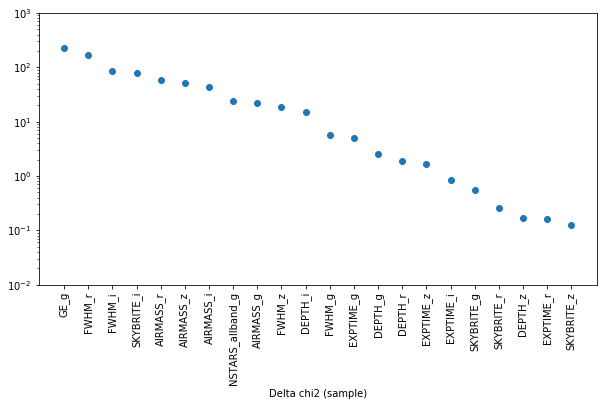

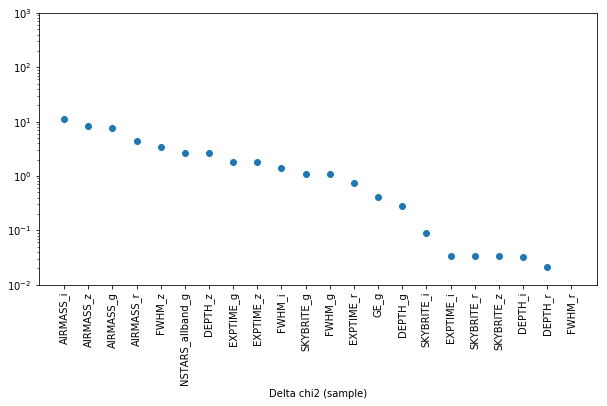

In [342]:
label_no_weight, values_no_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix='no_weight', 
                    path = inputdir, deltachi2=True)

suf = 'wg_ge_g_fwhm_r_airmass_z_airmass_i_skybrite_i_airmass_g_skybrite_r_fwhm_i_fwhm_g_skybrite_z'
label_full_weight, values_full_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suf, 
                    path = inputdir, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
#                    path = path, deltachi2=False)

0

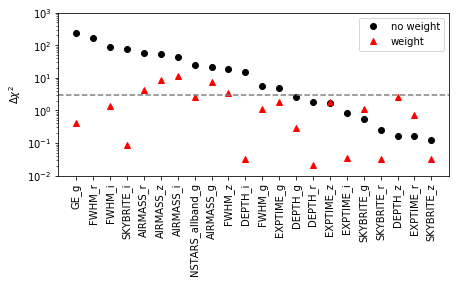

In [348]:

values_full_weight_reorder = []
for la in label_no_weight:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break

values_full_weight_reorder = np.array(values_full_weight_reorder)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_weight) ), values_no_weight,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_weight) ), values_full_weight_reorder, 'r^', label='weight'  )


#ax.plot( values_no_weight, np.arange( len(values_no_weight) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_weight) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_weight)))
ax.set_xticklabels(label_no_weight, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

In [ ]:
../data_txt/systematics/exp_i_fwhm_r_ge/weights/

In [310]:
fitsio.write('all_weight

array([1.06977443, 1.05078343, 0.94941918, ..., 1.02971727, 0.96157552,
       1.06577174])

array([1.04585829, 1.03566292, 0.95592671, ..., 1.02036872, 0.9511433 ,
       1.06647309])

In [374]:
y_pred.size

AttributeError: 'tuple' object has no attribute 'size'

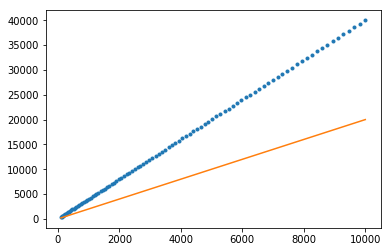

In [389]:
xdata = np.linspace(10,100,100)
ydata = 2 * xdata**2 + 3
yerr = np.random.normal( ydata, scale = 1, size = ydata.size)
x_pred, y_pred = fitting_linear( xdata**2, xdata**2, ydata, yerr)

fig, ax = plt.subplots()
ax.plot(xdata**2, ydata + yerr , '.')
ax.plot(x_pred, y_pred)

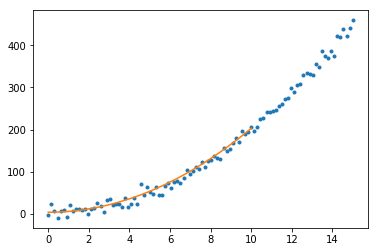

In [426]:
xpred = np.linspace(0, 10, 100)
xdata = np.linspace(0,15,100)
ydata = 2 * (xdata)**2 + 3
yerr = np.random.normal( 0, scale = 10, size = ydata.size)
ydata = ydata + yerr
_, y_pred = fitting_linear( xpred**2, xdata**2, ydata, yerr)

fig, ax = plt.subplots()
ax.plot(xdata, ydata , '.')
ax.plot(xpred, y_pred)

In [75]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def _fitting_linear( x_predict, xdata, ydata, yerr):
    import scipy
    powerlaw = lambda x, amp, index: amp * (x**index)
    logx = np.log10(xdata)
    logy = np.log10(ydata)
    logyerr = yerr / ydata

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    pinit = [1.0, -1.0]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(logx, logy, logyerr), full_output=1)

    pfinal = out[0]
    covar = out[1]

    #print pfinal
    #print covar


    index = pfinal[1]
    amp = 10.0**pfinal[0]
    
    #print index, amp
    
    indexErr = np.sqrt( covar[0][0] )
    ampErr = np.sqrt( covar[1][1] ) * amp
    
    y_predict = powerlaw(x_predict, amp, index)
    return x_predict, y_predict

In [24]:
#data_mask = Cbins < 5.0
#def linear_fitting( filename )
def fitting_errftn2( x_predict, xdata, ydata, yerr):
    import scipy
    #powerlaw = lambda x, amp, index: amp * (x**index)
    #logx = np.log10(xdata)
    #logy = np.log10(ydata)
    #logyerr = yerr / ydata

    # define our (line) fitting function
    #fitfunc = lambda p, x: p[0] + p[1] * x
    fitfunc = lambda p, x : p[0] * ( 1. + scipy.special.erf( (x-p[1])*1./p[2]  ))
    errfunc = lambda p, x, y, err: (y - fitfunc(p, x)) / err

    #pinit = [1.0, -1.0]
    pinit = [1.0, 1.0, 1.0]
    out = scipy.optimize.leastsq(errfunc, pinit,
                           args=(xdata, ydata, yerr), full_output=1)

    pfinal = out[0]
    covar = out[1]
    
    y_predict = fitfunc( pfinal, x_predict )
    return x_predict, y_predict

In [25]:
# call file

def _fitting_SP( property = None, filter=None, kind = None, suffix='', plot=False, function = None,
                path = '../data_txt/systematics/'):

   
    import scipy
    
    for p in property : 
        if plot : 
            fig, ax = plt.subplots(2,2,figsize = (15,10))
            ax = ax.ravel()
            i = 0
        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #print filename
            data = np.loadtxt(filename)
            bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
            zeromaskC, zeromaskR = ( Cdensity != 0.0 ), (Rdensity != 0.0 )
            Cbins, Cdensity, Cerr = bins[zeromaskC], Cdensity[zeromaskC], Cerr[zeromaskC]
            Rbins, Rdensity, Rerr = bins[zeromaskR], Rdensity[zeromaskR], Rerr[zeromaskR]                                                  
            
            C_bin_predict = np.zeros(bins.size)
            R_bin_predict = np.zeros(bins.size)
            #predict[~zeromaskC] = np.nan

            _, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
            if function == 'linear':
                _, C_predict = fitting_linear( bins, Cbins, Cdensity, Cerr)
                #_, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
                
            elif function == 'sqrt' : 
                _, C_predict = fitting_linear( np.sqrt(bins), np.sqrt(Cbins), Cdensity, Cerr)
            elif function == 'square' : 
                _, C_predict = fitting_linear( bins**2, Cbins**2, Cdensity, Cerr)    
            elif function == 'log' : 
                _, C_predict = fitting_linear( np.log10(bins), np.log10(Cbins), Cdensity, Cerr)  
                
            elif function == 'errftn' : 
                _, C_predict = fitting_errftn( bins, Cbins, Cdensity, Cerr)
                
                #_, R_predict = fitting_errftn( bins, Rbins, Rdensity, Rerr)                 
                
            else : print 'Please enter the kind of fitting function'
                
            Cchi2_model = np.sum((Cdensity - C_predict[zeromaskC])**2 *1./Cerr**2)
            Rchi2_model = np.sum((Rdensity - R_predict[zeromaskR])**2 *1./Rerr**2)
 
            Cchi2_null = np.sum((Cdensity - 1.0)**2 *1./Cerr**2)
            Rchi2_null = np.sum((Rdensity - 1.0)**2 *1./Rerr**2)
        
            Del_Cchi2 = Cchi2_null - Cchi2_model 
            Del_Rchi2 = Rchi2_null - Rchi2_model
            
            print 'chi2_null = ', Cchi2_null
            print 'chi2_mod. = ', Cchi2_model
            print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            
            
            #print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            #print 'Delta chi2 (random) =', Rchi2_null - Rchi2_model
            
            #If chisqr is larger than 68% of the mocks, label it as Delta chisqr(68).
            #Delta_chi2_68 = 0.68 * Del_Rchi2
            #significance = Del_Cchi2/Delta_chi2_68
            #print 'Delta_chi2_68 = ', Delta_chi2_68
            #print 'significance = ', significance
            
            #C_bin_predict[zeromaskC] = C_predict
            #C_bin_predict[~zeromaskC] = np.nan
            #R_bin_predict[zeromaskR] = R_predict
            #R_bin_predict[~zeromaskR] = np.nan

            
            DAT = np.column_stack((bins, C_predict, R_predict))
            header = 'Delta chi2 (sample) = '+ str(Del_Cchi2)+ '\nDelta chi2 (random) = '+str(Del_Rchi2) +\
            '\nbins, Sample, Random'
            
            np.savetxt(filename+'.model', DAT, header =header)
            print 'output save to ', filename+'.model\n'
            
            if plot : 
                ax[i].errorbar(Cbins, Cdensity, yerr=Cerr, fmt='b-', label='dmass' + ' $\Delta \chi^2={:0.2f}$'.format(Del_Cchi2))
                ax[i].errorbar(Rbins, Rdensity, yerr=Rerr, fmt='r-', label='random')
                ax[i].plot(bins, C_predict, 'b--', alpha=1.0)
                #ax[i].plot(Rbins*1.005, R_predict, 'r-', alpha = 0.3)
                ax[i].plot(bins*1.005, R_predict, 'r--', alpha = 1.0)
                ax[i].axhline(y=1.0, color='grey', ls = '--')
                ax[i].set_xlabel(p+'_'+f)
                ax[i].set_ylabel('galaxy num density')
                ax[i].set_ylim(0.7, 1.3)
                ax[i].legend(loc=1)
                if function == 'log' : ax[i].set_xscale('log')
                #if p == 'EXPTIME' : 
                ax[i].set_xlim(None, Rbins.max() * 1.01)
                i += 1
                
        if plot : 
            figname = path+'systematic_fitting_'+p+'_'+f+'_'+kind+'_'+suffix+'.png'
            fig.savefig(figname)

#Cdensity, Cbins, Cerr = Cdensity[zeromaskC], bins[zeromaskC], Cerr[zeromaskC]
#C_jkerr = C_jkerr[zeromaskC]
#Rdensity, Rbins, Rerr = Rdensity[zeromaskR],bins[zeromaskR], Rerr[zeromaskR]
#B_jkerr = B_jkerr[zeromaskB]

In [26]:
# call file

def _calculate_weight( property = None, filter=None, kind = None, suffix='', plot=False, function = None,
                path = '../data_txt/systematics/', catalog = None, sysMap= None, 
                weight=False, raTag ='RA', decTag='DEC', nside=4096):

   
    import scipy
    """
    
    for p in property : 
        if plot : 
            fig, ax = plt.subplots(2,2,figsize = (15,10))
            ax = ax.ravel()
            i = 0

            
        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #print filename
            data = np.loadtxt(filename)
            bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
            zeromaskC, zeromaskR = ( Cdensity != 0.0 ), (Rdensity != 0.0 )
            Cbins, Cdensity, Cerr = bins[zeromaskC], Cdensity[zeromaskC], Cerr[zeromaskC]
            Rbins, Rdensity, Rerr = bins[zeromaskR], Rdensity[zeromaskR], Rerr[zeromaskR]                                                  
            
            #C_bin_predict = np.zeros(bins.size)
            #R_bin_predict = np.zeros(bins.size)
            #predict[~zeromaskC] = np.nan

            _, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr )
            if function == 'linear':
                _, C_predict = fitting_linear( bins, Cbins, Cdensity, Cerr)
                #_, R_predict = fitting_linear( bins, Rbins, Rdensity, Rerr)
                
            elif function == 'sqrt' : 
                #Cbins = np.sqrt(Cbins)
                #Rbins = np.sqrt(Rbins)
                _, C_predict = fitting_linear( np.sqrt(bins), np.sqrt(Cbins), Cdensity, Cerr)

            elif function == 'square' : 
                _, C_predict = fitting_linear( bins**2, Cbins**2, Cdensity, Cerr)
                
            elif function == 'log' : 
                _, C_predict = fitting_linear( np.log10(bins), np.log10(Cbins), Cdensity, Cerr)  
                
            elif function == 'errftn' : 
                _, C_predict = fitting_errftn( bins, Cbins, Cdensity, Cerr)
               # _, R_predict = fitting_errftn( bins, Rbins, Rdensity, Rerr)                 
                
            else : print 'Please enter the kind of fitting function'
                
            Cchi2_model = np.sum((Cdensity - C_predict[zeromaskC])**2 *1./Cerr**2)
            Rchi2_model = np.sum((Rdensity - R_predict[zeromaskR])**2 *1./Rerr**2)
 
            Cchi2_null = np.sum((Cdensity - 1.0)**2 *1./Cerr**2)
            Rchi2_null = np.sum((Rdensity - 1.0)**2 *1./Rerr**2)
        
            Del_Cchi2 = Cchi2_null - Cchi2_model 
            Del_Rchi2 = Rchi2_null - Rchi2_model
            print 'chi2_null = ', Cchi2_null
            print 'chi2_mod. = ', Cchi2_model
            print 'Delta chi2 (sample) =', Cchi2_null - Cchi2_model 
            #print 'Delta chi2 (random) =', Rchi2_null - Rchi2_model
            
            #If chisqr is larger than 68% of the mocks, label it as Delta chisqr(68).
            #Delta_chi2_68 = 0.68 * Del_Rchi2
            #significance = Del_Cchi2/Delta_chi2_68
            #print 'Delta_chi2_68 = ', Delta_chi2_68
            #print 'significance = ', significance
            
            DAT = np.column_stack((bins, C_predict, R_predict))
            header = 'Delta chi2 (sample) = '+ str(Del_Cchi2)+ '\nDelta chi2 (random) = '+str(Del_Rchi2) +\
            '\nbins, Sample, Random'
            
            np.savetxt(filename+'.model', DAT, header =header)
            print 'output save to ', filename+'.model\n'
            """
            
    
    #wg_dic = {}
    #if weight : 

        
    for p in property :
        if p == 'GE' : nside = 512
        elif p == 'NSTARS_allband' : nside = 1024
        else : nside = 4096
            
        if plot:
            fig, ax = plt.subplots(2,2,figsize = (15,10))
            ax = ax.ravel()
            i = 0
        
        for f in filter : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt'
            #print filename
            data = np.loadtxt(filename)
            bins, Cdensity, Cerr, Cf_area, Rdensity, Rerr, Rf_area = [data[:,j] for j in range(data[0].size)]
            zeromaskC, zeromaskR = ( Cdensity != 0.0 ), (Rdensity != 0.0 )
            Cbins, Cdensity, Cerr = bins[zeromaskC], Cdensity[zeromaskC], Cerr[zeromaskC]
            Rbins, Rdensity, Rerr = bins[zeromaskR], Rdensity[zeromaskR], Rerr[zeromaskR]                                                  
            
            #C_bin_predict = np.zeros(bins.size)
            #R_bin_predict = np.zeros(bins.size)
            #predict[~zeromaskC] = np.nan
            
            mapname = 'sys_'+p+'_'+f+'_'+kind #+'_masked'
            catHpInd = hpRaDecToHEALPixel(catalog[raTag], catalog[decTag], nside=nside, nest= False)
            #signal = sysMap[mapname]['SIGNAL'][catHpInd]

            min = np.min(sysMap[mapname]['SIGNAL'])
            max = np.max(sysMap[mapname]['SIGNAL'])
            bin_num = 100

            if function == 'log' : log = True
            else : log = False

            bin_center, binned_cat, keeps = divide_bins( sysMap[mapname], Tag = 'SIGNAL', \
                                                        min = min, max = max, bin_num = bin_num, log=log )


            _, R_predict = fitting_linear( bin_center, Rbins, Rdensity, Rerr )
            
            if function == 'linear':
                _, C_predict = fitting_linear( bin_center, Cbins, Cdensity, Cerr)

            elif function == 'sqrt' : 
                _, C_predict = fitting_linear( np.sqrt(bin_center), np.sqrt(Cbins), Cdensity, Cerr)

            elif function == 'square' : 
                _, C_predict = fitting_linear( bin_center**2, Cbins**2, Cdensity, Cerr)

            elif function == 'log' : 
                _, C_predict = fitting_linear( np.log10(bin_center), np.log10(Cbins), Cdensity, Cerr)  

            elif function == 'errftn' : 
                _, C_predict = fitting_errftn( bin_center, Cbins, Cdensity, Cerr)                

            else : 
                print 'Please enter the kind of fitting function'
                return 0


            if plot : 
                ax[i].errorbar(Cbins, Cdensity, yerr=Cerr, fmt='b-', label='dmass')
                ax[i].errorbar(Rbins, Rdensity, yerr=Rerr, fmt='r-', label='random')
                ax[i].plot(bin_center, C_predict, 'b--', alpha=1.0)
                #ax[i].plot(Rbins*1.005, R_predict, 'r-', alpha = 0.3)
                ax[i].plot(bin_center*1.005, R_predict, 'r--', alpha = 1.0)
                ax[i].axhline(y=1.0, color='grey', ls = '--')
                ax[i].set_xlabel(p+'_'+f)
                ax[i].set_ylabel('galaxy num density')
                ax[i].set_ylim(0.7, 1.3)
                ax[i].legend(loc=1)
                ax[i].set_xlim(None, Rbins.max()*1.01 )
                if function == 'log' : ax[i].set_xscale('log')
                i += 1

            wg = np.zeros( catalog.size, dtype=float)
            for i, sysMap_i in enumerate(binned_cat):
                HpIdxInSys_mask = np.in1d(catHpInd, sysMap_i['PIXEL'])
                wg[HpIdxInSys_mask] = 1./C_predict[i]
                #print np.sum(HpIdxInSys_mask), 1./C_predict[i], sysMap_i['PIXEL'].size
                            
        return wg
#Cdensity, Cbins, Cerr = Cdensity[zeromaskC], bins[zeromaskC], Cerr[zeromaskC]
#C_jkerr = C_jkerr[zeromaskC]
#Rdensity, Rbins, Rerr = Rdensity[zeromaskR],bins[zeromaskR], Rerr[zeromaskR]
#B_jkerr = B_jkerr[zeromaskB]

In [27]:
def _plotting_significance( property = None, filter=None, kind = None, suffix='', 
                path = '../data_txt/systematics/', deltachi2 = False):

   
    import scipy
    
    key = 'significance'
    if deltachi2 : key = 'Delta chi2 (sample)'
    label = []
    siglist = []
    
    for p in property : 
        if p in ['NSTARS_allband', 'GE'] : filt_effec = filter[0]
        else : filt_effec = filter
        for f in filt_effec : 
            filename = path+'systematic_'+p+'_'+f+'_'+kind+'_'+suffix+'.txt.model'
            file = open(filename, 'r')
            data = file.readlines()
            for s in data : 
                if key in s.split('#')[1] : 
                    sig = s.split('=')[1]
                    siglist.append( float(sig) )
                    label.append( p+'_'+f )
                    #print  p+'_'+f , sig
                    break
       
    arg = np.argsort(np.array(siglist), kind='quicksort')[::-1]
    #print arg
    #siglist = siglist[arg]
    #label = label[arg]
    siglist = [siglist[a] for a in arg]
    label = [label[a] for a in arg]
    print siglist
    fig, ax = plt.subplots(figsize = (10,5))
    ax.plot( np.arange( len(siglist) ), siglist,   'o'  )
    #ax.axvline(x = 2, ls = '--', color='k')
    #ax.axvline(x = 3, ls = '--', color='k')
    ax.set_ylim(0.01,1000)
    ax.set_xlabel(key)
    ax.set_xticks( np.arange( len(siglist) ) )
    ax.set_xticklabels(label, rotation = 90)
    ax.set_yscale('log')
    fig.savefig(path+'chisquare_'+p+'_'+f+'_'+kind+'_'+suffix+'.png')
    return label, siglist
         

[71.7882547843243, 45.44740208707442, 27.161597641597282, 26.887097796462918, 21.366070594478604, 18.893653891493344, 10.732743463445132, 8.4234263435036, 7.560039360821456, 4.410625078921322, 4.213893695846611, 3.756774006666019, 2.7466151055695676, 1.9621951212190218, 0.9317811437941934, 0.9105905474557439, 0.7071815569598598, 0.2845452569694018, 0.2164815970567986, 0.05198834828646426]


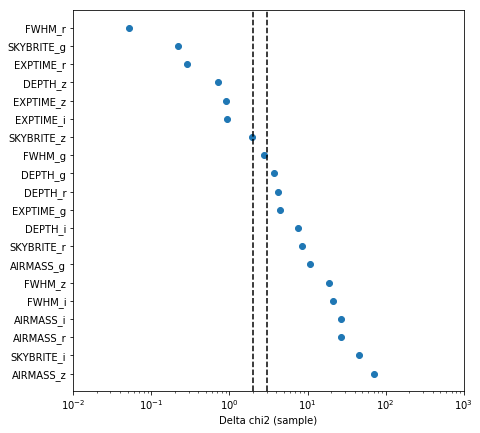

In [397]:
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
nextweight = plotting_significance( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM'], filter=['g', 'r', 'i','z'], kind = kind, suffix=suffix, 
                path = path, deltachi2=True)

[36563.34381610522, 2944.1392174597736, 1396.8738595800435, 381.44034832465877, 252.69212700482385, 193.78986408503744, 106.19826799804885, 56.69813627233241, 55.5790658490122, 34.39353103977977, 14.503320407122645, 2.6255345429000787, 1.809610743273977, 0.833875819243781, 0.7603379436470278, 0.7530078895063359, 0.5544899916095869, 0.24088621326915882, 0.2094433609066743, 0.0653812379099245]


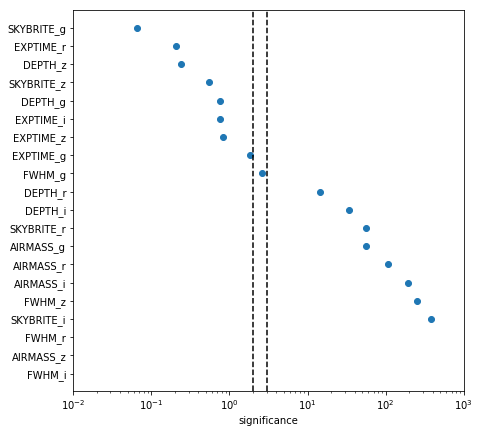

In [355]:
suffix = '1'
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
plotting_significance( property = ['DEPTH', 'EXPTIME', 'AIRMASS', 'SKYBRITE', 'FWHM'], filter=['g', 'r', 'i','z'], kind = kind, suffix=suffix, 
                path = path, deltachi2=False)

# FWHM r

In [73]:
def _init( nextweight ):
  
    nextw = nextweight.split('_')
    
    if len(nextw) == 2 : nextprop = nextw[0]
    else : nextprop = nextw[0]+'_'+nextw[1]
    nextfil = nextw[-1]
    #nextprop, nextfil = nextweight.split('_')
    print '----------------------------------'
    print 'initialize function ', nextweight
    #function = 'linear'
    #if nextprop == 'EXPTIME' : function = 'sqrt'
    #elif nextprop == 'SKYBRITE' : function = 'sqrt'
        
    #else : function = 'linear'
        
        
    return nextprop, nextfil

In [74]:
def _sys_iteration( nextweight=None, suffix=None, all_weight = None, 
                  cat1=None, cat2=None, rand1 = None, rand2=None,
                  sysMap = None, nside=4096, kind='SPT', function=None, function2=None,
                  properties = None, filters = ['g', 'r', 'i', 'z'], 
                  path=None, plot=True, weightDic=None, FullArea=None ):
    
    nextprop, nextfil= init(nextweight)    
    print function
    wg = calculate_weight( property = [nextprop], filter=[nextfil], kind = kind, suffix=suffix, plot=plot, 
                              function = function,
                    path =path, catalog = cat1, sysMap= sysMap, 
                    weight=True, raTag ='RA', decTag='DEC', nside=nside)
    print wg.size
    print 'store weight ', nextweight
    fitsname = path+'/weights/wg_'+nextweight.lower()+'_'+kind+'.fits'
    print 'save weight to fits', fitsname
    fitsio.write( fitsname, wg, clobber=True )
    weightDic[nextweight] = wg
    
    
    if suffix == 'no_weight': suffix = 'wg_'+nextweight.lower()
    else : suffix = suffix+'_'+nextweight.lower()
    print 'suffix = ', suffix
    all_weight = np.multiply( all_weight, weightDic[nextweight] )

    sys_ngal(cat1 = cat1, cat2=cat2, rand1 = rand1, rand2 = rand2, sysmap = sysMap, 
             FullArea = FullArea, properties = properties, kind=kind, nbins = 15,
             pixelmask = None, reweight = all_weight, 
             suffix=suffix, outdir=path)

    return 0

    #fitting_SP( property = properties, filter=filters, kind = kind, suffix=suffix, plot=plot, path=path
    #          , function = function2)
    
    
    #nextweight_new, deltachi2_new = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
    #                path = path, deltachi2=True)
    
    
    #j = 0
    #for i in range(len(nextweight_new)):
    #    if nextweight == nextweight_new[j]: j += 1
    #    else : break
    
    #nextweight = nextweight_new[-1]
    #deltachi2 = deltachi2_new[-1]
    
    #return nextweight, suffix, all_weight, deltachi2
    
    #return weightDic


In [30]:
properties = ['DEPTH', 'EXPTIME', 'SKYBRITE', 'AIRMASS', 'FWHM']
filters = ['g', 'r', 'i', 'z']
path = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
weightDic = {}
weightDic['noweight'] = np.ones(dmass.size)
all_weight = weightDic['noweight']
suffix = '1'
nextweight = 'AIRMASS_z'

In [ ]:
max_iter = 200
i = 0
for i in range(max_iter):
    print ''
    print 'ITERATION-',i
    print ''
    nextweight, suffix, all_weight, deltachi2 = \
    sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )
    if deltachi2 < 3: break
    i += 1


ITERATION- 0

----------------------------------
initialize function  AIRMASS_z
chi2_null =  98.9055335364578
chi2_mod. =  38.57876952027861
Delta chi2 (sample) = 60.32676401617918
Delta_chi2_68 =  0.020490459030748413
significance =  2944.1392174597736
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_z_SPT_1.txt.model

store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_z_SPT.fits
suffix =  wg_airmass_z


../systematics.py:433: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:433: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z.txt


../systematics.py:429: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/system


ITERATION- 1

----------------------------------
initialize function  FWHM_r
chi2_null =  218.08285544633054
chi2_mod. =  40.96944731782668
Delta chi2 (sample) = 177.11340812850386
Delta_chi2_68 =  0.022826803330823042
significance =  7759.01056147216
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z.txt.model

store weight  FWHM_r
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_fwhm_r_SPT.fits
suffix =  wg_airmass_z_fwhm_r
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/sys


ITERATION- 2

----------------------------------
initialize function  AIRMASS_i
chi2_null =  122.73797324001359
chi2_mod. =  41.23377683197453
Delta chi2 (sample) = 81.50419640803906
Delta_chi2_68 =  0.06315896287010823
significance =  1290.4612853706822
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_i_SPT_wg_airmass_z_fwhm_r.txt.model

store weight  AIRMASS_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt
saving data to  ../data

chi2_null =  40.22511021933208
chi2_mod. =  32.08702774243939
Delta chi2 (sample) = 8.138082476892691
Delta_chi2_68 =  0.012126844318778042
significance =  671.0799828023786
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  38.285599348560716
chi2_mod. =  38.01941846633787
Delta chi2 (sample) = 0.26618088222284797
Delta_chi2_68 =  0.022826803330823042
significance =  11.660891731757456
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  34.01293096496684
chi2_mod. =  26.118880669444817
Delta chi2 (sample) = 7.894050295522025
Delta_chi2_68 =  0.18727283716622276
significance =  42.152671017181696
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

chi2_null =  44.20756138656334
chi2_mod. =  37.

/n/home00/lee.5922/.local/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)



ITERATION- 3

----------------------------------
initialize function  SKYBRITE_i
chi2_null =  45.13475801017013
chi2_mod. =  27.47258267728147
Delta chi2 (sample) = 17.662175332888662
Delta_chi2_68 =  0.015958204450242874
significance =  1106.7771056548818
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_SKYBRITE_i_SPT_wg_airmass_z_fwhm_r_airmass_i.txt.model

store weight  SKYBRITE_i
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_skybrite_i_SPT.fits
suffix =  wg_airmass_z_fwhm_r_airmass_i_skybrite_i
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmas

chi2_null =  43.966202522312656
chi2_mod. =  32.541851854953826
Delta chi2 (sample) = 11.42435066735883
Delta_chi2_68 =  0.012126844318778042
significance =  942.0711907440403
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  40.83543799994977
chi2_mod. =  39.810038261035146
Delta chi2 (sample) = 1.025399738914622
Delta_chi2_68 =  0.022826803330823042
significance =  44.92086447908474
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_r_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  31.314689162806328
chi2_mod. =  27.428136595590775
Delta chi2 (sample) = 3.8865525672155528
Delta_chi2_68 =  0.18727283716622276
significance =  20.753423860214504
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_FWHM_i_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i.txt.model

chi2_null =  

KeyboardInterrupt: 

----------------------------------
initialize function  AIRMASS_z
chi2_null =  98.9055335364578
chi2_mod. =  38.57876952027861
Delta chi2 (sample) = 60.32676401617918
Delta_chi2_68 =  0.020490459030748413
significance =  2944.1392174597736
output save to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_AIRMASS_z_SPT_1.txt.model

store weight  AIRMASS_z
save weight to fits ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins//weights/wg_airmass_z_SPT.fits
suffix =  wg_airmass_z


../systematics.py:433: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:433: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_DEPTH_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_g_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_r_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_i_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_EXPTIME_z_SPT_wg_airmass_z.txt
saving data to  ../data_txt/systematics/

FWHM_r wg_airmass_z


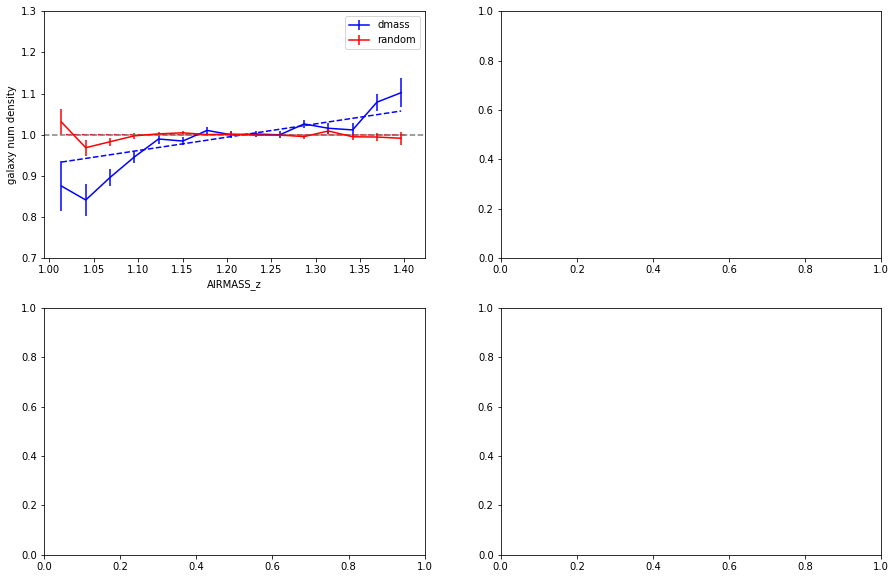

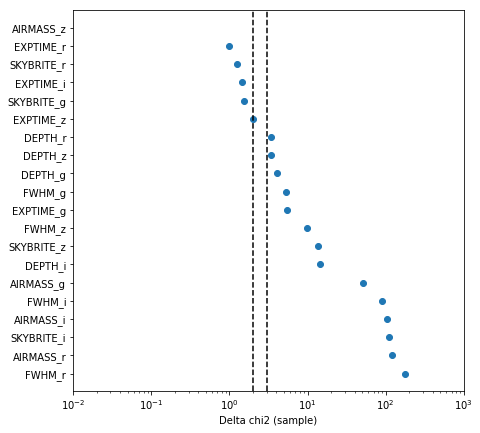

In [26]:
nextweight, suffix, all_weight, deltachi2 = \
sys_iteration( nextweight=nextweight, suffix=suffix, all_weight = all_weight )
print nextweight, suffix

[166.61261783638167, 78.82242082677308, 76.81567677316121, 60.32676401617918, 50.458779943773806, 38.03879300021996, 19.538383038902047, 16.74504983688334, 13.770614202904497, 2.330702221569174, 2.107534081318377, 2.000382505970588, 1.5961878596218426, 0.8959901844430433, 0.4896240905627831, 0.2762933864983079, 0.19236483608333899, 0.10672276030948069, 0.06957391169861182, 0.011178113169997062]


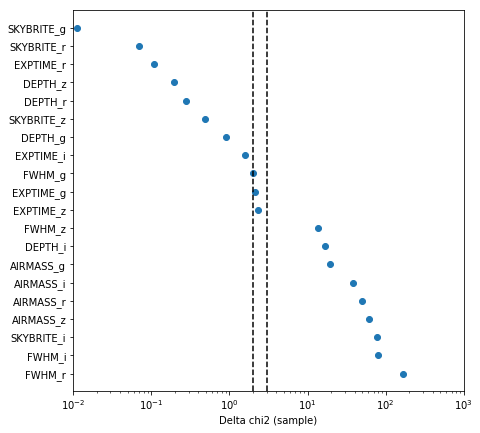

In [82]:
label_no_mask, values_no_mask = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
                    path = path, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
#                    path = path, deltachi2=False)

[12.923182118542943, 2.794487614437827, 2.3878507029379037, 2.162573170681867, 1.7290554653467538, 1.235948925624207, 0.6582609019191423, 0.6284916467204447, 0.5638028640019819, 0.46347755314985406, 0.3792750014213766, 0.29673763231871675, 0.2520900524092937, 0.2476702039348453, 0.10543980569897116, 0.10179421833318436, 0.08796989151293388, 0.0713385220519065, 0.04286687125953037, 0.021227444649742466]


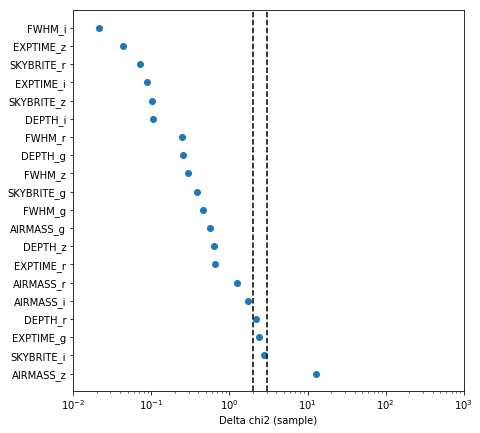

In [83]:
label_full_weight, values_full_weight = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
                    path = path, deltachi2=True)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
#                    path = path, deltachi2=False)

In [86]:
arg = np.argsort(label_no_mask, kind='quicksort')[::-1]
arg2 = np.argsort(label_full_weight, kind='quicksort')[::-1]

In [95]:
values_no_mask_reorder = np.array(values_no_mask)[arg]

0

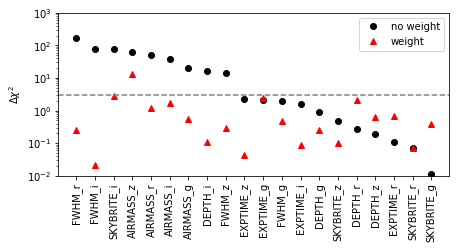

In [146]:

values_full_weight_reorder = []
for la in label_no_mask:
    for j in range(len(label_full_weight)):
        if la == label_full_weight[j]: 
            values_full_weight_reorder.append(values_full_weight[j])
            break

values_full_weight_reorder = np.array(values_full_weight_reorder)

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(values_no_mask) ), values_no_mask,  'ko' , label='no weight'  )
ax.plot( np.arange( len(values_no_mask) ), values_full_weight_reorder, 'r^', label='weight'  )


#ax.plot( values_no_mask, np.arange( len(values_no_mask) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_mask) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,1000)
ax.set_ylabel(r'$\Delta \chi^2$')
ax.set_xticks( np.arange(len(values_no_mask)))
ax.set_xticklabels(label_no_mask, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

[36563.34381610522, 2944.1392174597736, 1396.8738595800435, 381.44034832465877, 252.69212700482385, 193.78986408503744, 106.19826799804885, 56.69813627233241, 55.5790658490122, 34.39353103977977, 14.503320407122645, 2.6255345429000787, 1.809610743273977, 0.833875819243781, 0.7603379436470278, 0.7530078895063359, 0.5544899916095869, 0.24088621326915882, 0.2094433609066743, 0.0653812379099245]


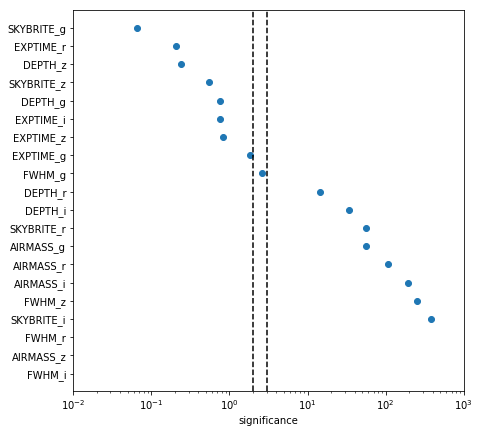

In [233]:
sig_label_no_mask, sig_values_no_mask = plotting_significance( property = properties, filter=filters, kind = kind, suffix='1', 
                    path = path, deltachi2=False)
#_ = plotting_significance( property = properties, filter=filters, kind = kind, suffix=suffix, 
#                    path = path, deltachi2=False)

0

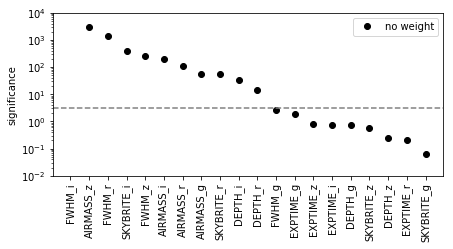

In [235]:

fig, ax = plt.subplots(figsize = (7,3))

ax.plot( np.arange( len(sig_values_no_mask) ), sig_values_no_mask,  'ko' , label='no weight'  )
#ax.plot( np.arange( len(values_no_mask) ), values_full_weight_reorder, 'r^', label='weight'  )
#ax.plot( values_no_mask, np.arange( len(values_no_mask) ),  'ko'  )
#ax.plot( values_full_weight_reorder, np.arange( len(values_no_mask) ),  'ro'  )
#ax.axhline(y = 1, ls = '--', color='grey')
ax.axhline(y = 3, ls = '--', color='grey')
ax.set_ylim(0.01,10000)
ax.set_ylabel('significance')
ax.set_xticks( np.arange(len(sig_label_no_mask)))
ax.set_xticklabels(sig_label_no_mask, rotation = 90)
ax.set_yscale('log')
ax.legend(loc='best')
0

In [68]:
#suffix = 'wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i'

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_DEPTH_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_EXPTIME_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_SKYBRITE_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_AIRMASS_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/systematic_FWHM_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybri

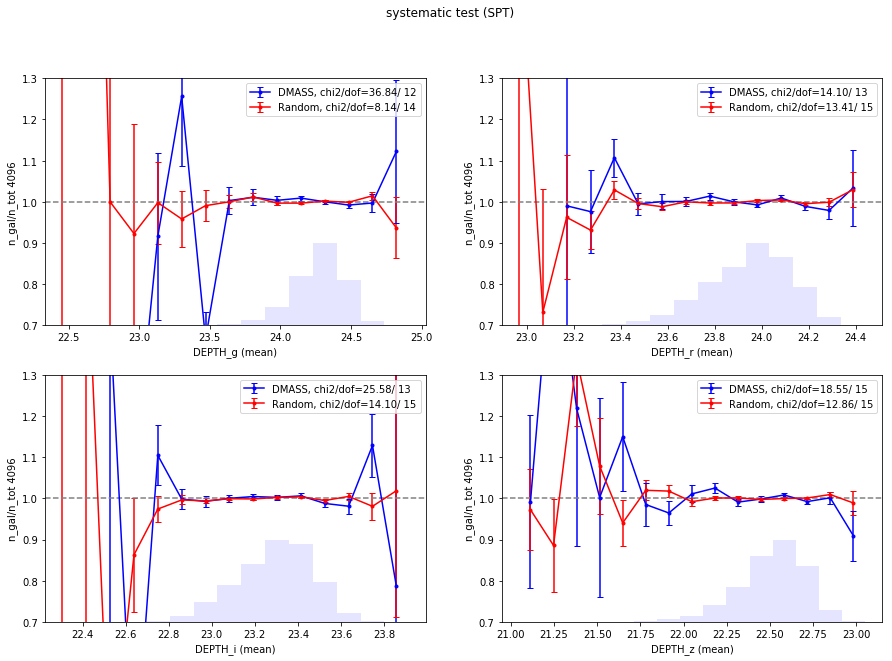

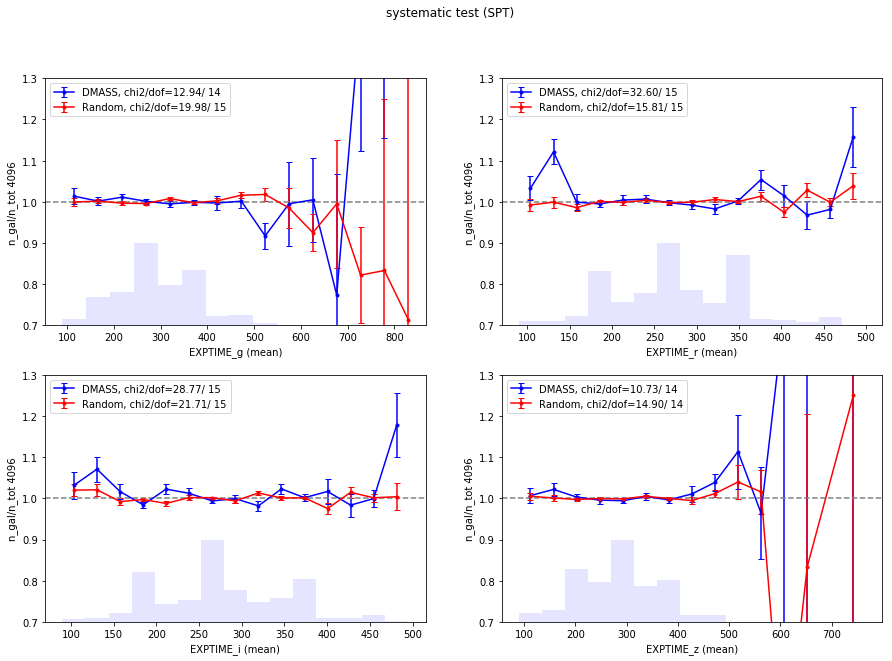

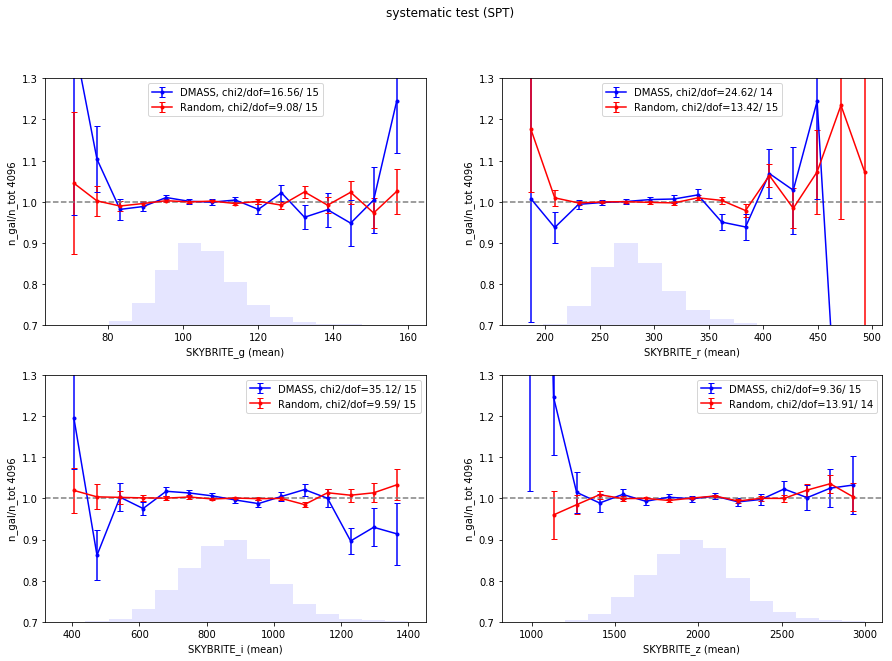

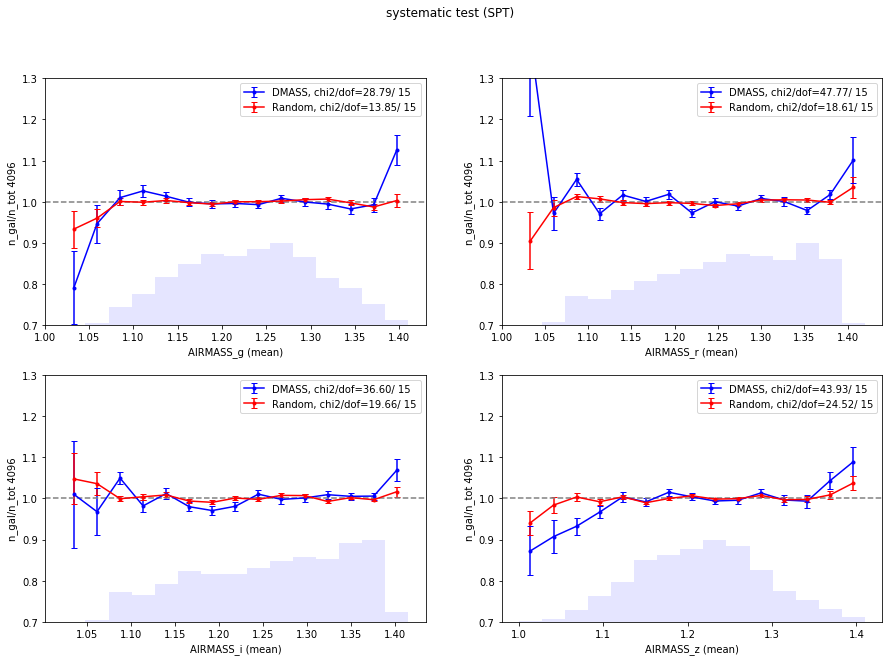

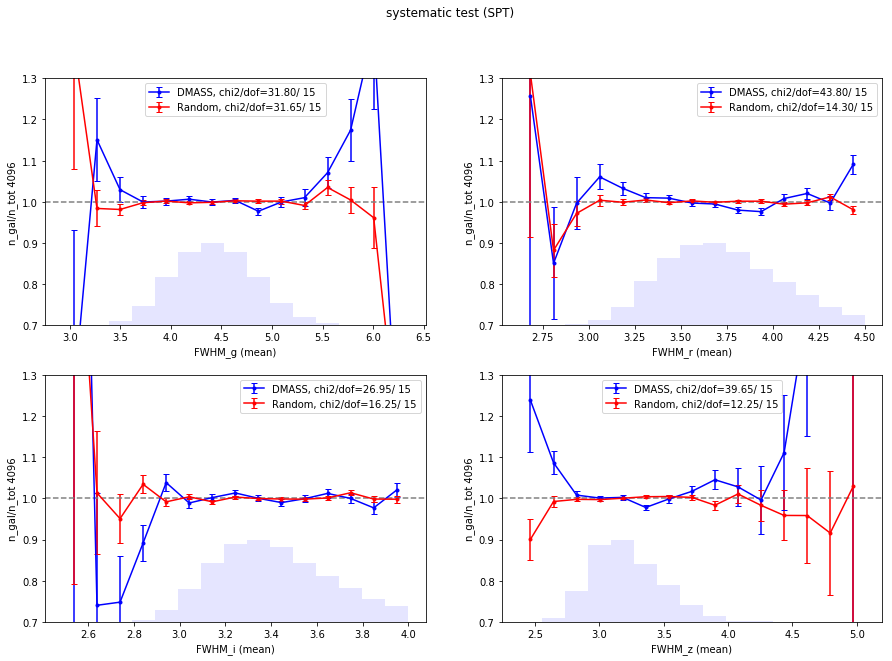

In [148]:
from systematics_module.contCorrection import doVisualization_ngal
inputdir = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/'
figoutdir = '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/'

for p in properties: 
    doVisualization_ngal(property = p, nside = 4096, kind = kind, suffix=suffix, \
                         inputdir=inputdir, outdir=figoutdir)

In [209]:
sysMap_stellar = calling_sysMap( properties=['NSTARS_allband'], kind='SPT', nside = 1024 )


PATH =  /n/des/lee.5922/data/systematic_maps/Y1A1NEW_COADD_SPT/nside4096_oversamp4/
y1a1_gold_1.0.2_stars_nside1024.fits
NSIDE = 1024
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
DOWNGRADE =  1024


../systematics.py:442: RuntimeWarning: invalid value encountered in divide
  Ngal_avg = Ngal *1./Nrand
../systematics.py:446: RuntimeWarning: divide by zero encountered in divide
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density
../systematics.py:446: RuntimeWarning: invalid value encountered in multiply
  err = 1./np.sqrt(Ngal * w_FKP) * norm_galaxy_density


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_GE_g_SPT_1.txt


In [33]:
sysMap_ge['sys_GE_g_SPT']['SIGNAL'].max()

127.84459061084017

(array([1.484905e+06, 4.121000e+03, 6.500000e+02, 1.490000e+02,
        3.700000e+01, 2.700000e+01, 1.300000e+01, 9.000000e+00,
        7.000000e+00, 2.000000e+00]),
 array([1.09871816e-03, 1.27854479e+01, 2.55697971e+01, 3.83541463e+01,
        5.11384955e+01, 6.39228447e+01, 7.67071939e+01, 8.94915430e+01,
        1.02275892e+02, 1.15060241e+02, 1.27844591e+02]),
 <a list of 10 Patch objects>)

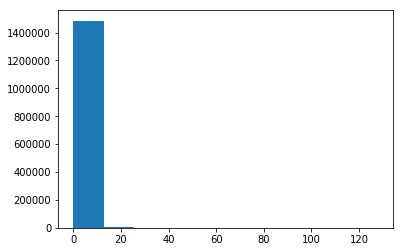

In [38]:
fig, ax = plt.subplots()
bins = np.linspace(sysMap_ge['sys_GE_g_SPT']['SIGNAL'].min(), 1,100  )
ax.hist( sysMap_ge['sys_GE_g_SPT']['SIGNAL'] )

In [ ]:
#fwhm_mask_st82 = (sysMap_st82['sys_FWHM_r_STRIPE82']['SIGNAL'] < 4.5) 
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_stellar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins = 30, pixelmask = None,
         reweight= None, nside = 1024,
         suffix='1', outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

In [215]:
#fwhm_mask_st82 = (sysMap_st82['sys_FWHM_r_STRIPE82']['SIGNAL'] < 4.5) 
sys_ngal(cat1 = dmass, cat2=rand, rand1 = rand2, rand2 = rand2, sysmap = sysMap_stellar, 
         FullArea = SPTMaparea, properties = ['NSTARS_allband'], kind='SPT', nbins = 30, pixelmask = None,
         reweight= all_weight, nside = 1024,
         suffix=suffix, outdir= '../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/')

saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_NSTARS_allband_g_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.txt


saving data to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/systematic_NSTARS_allband_g_SPT_1.txt


saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_NSTARS_allband_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png


0

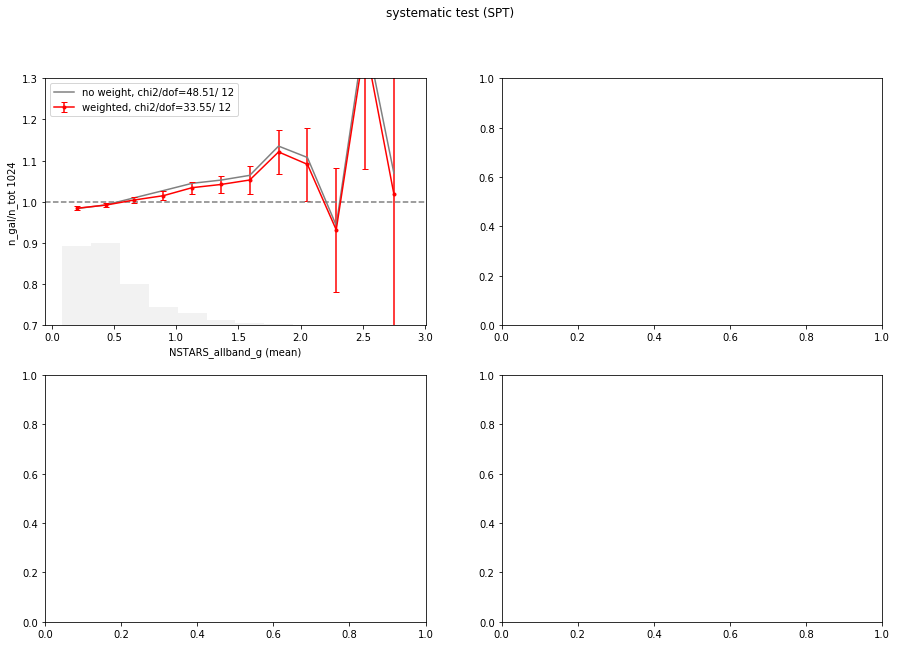

In [217]:
plot_sysweight(property = 'NSTARS_allband', nside = 1024, kind = 'SPT', 
           suffix1='1', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_DEPTH_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_EXPTIME_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_SKYBRITE_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_AIRMASS_SPT_wg_airmass_z_fwhm_r_airmass_i_skybrite_i_skybrite_g_fwhm_g_fwhm_z_skybrite_r_fwhm_i_exptime_z.png
saving fig to  ../data_txt/systematics/exp_ri_fwhm_r_skybrite_giz_mask_15bins/figure/comparison_systematic_FWHM_SPT_wg_airmass_z_fwhm

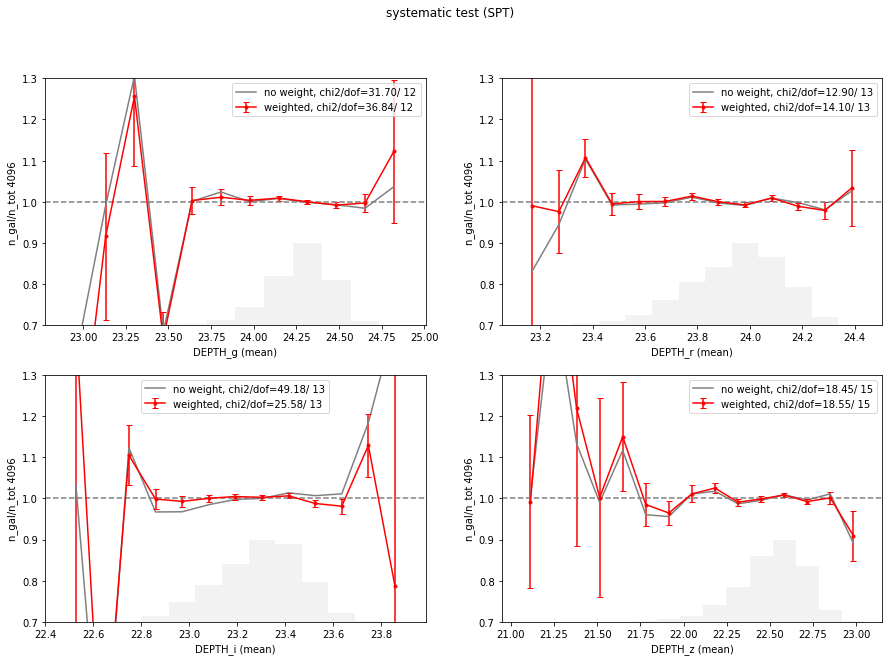

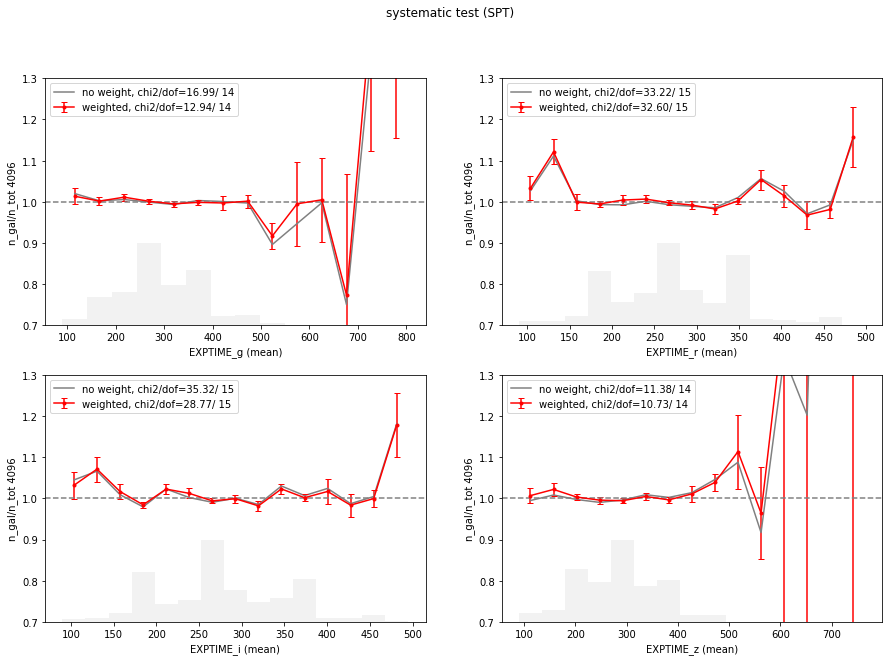

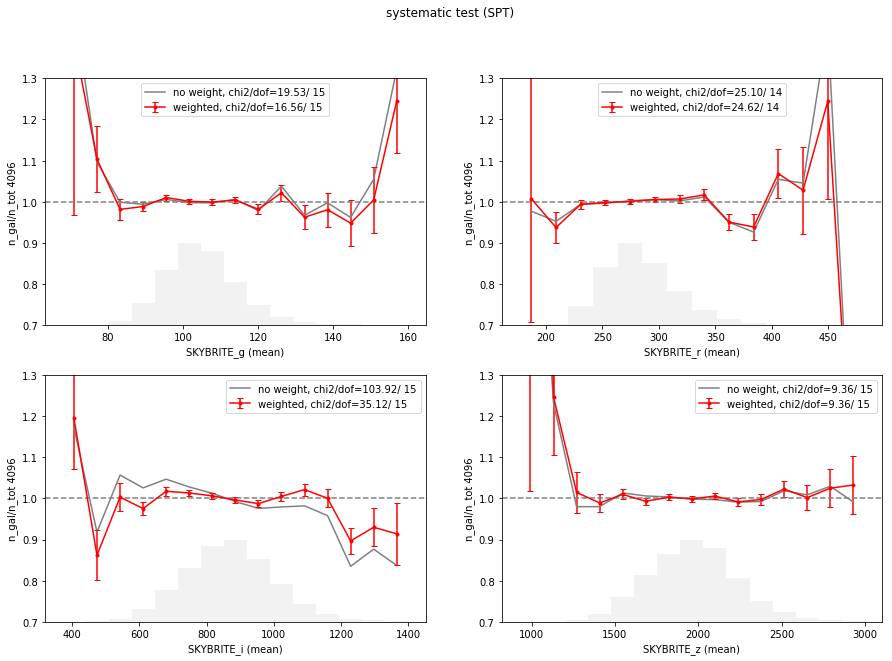

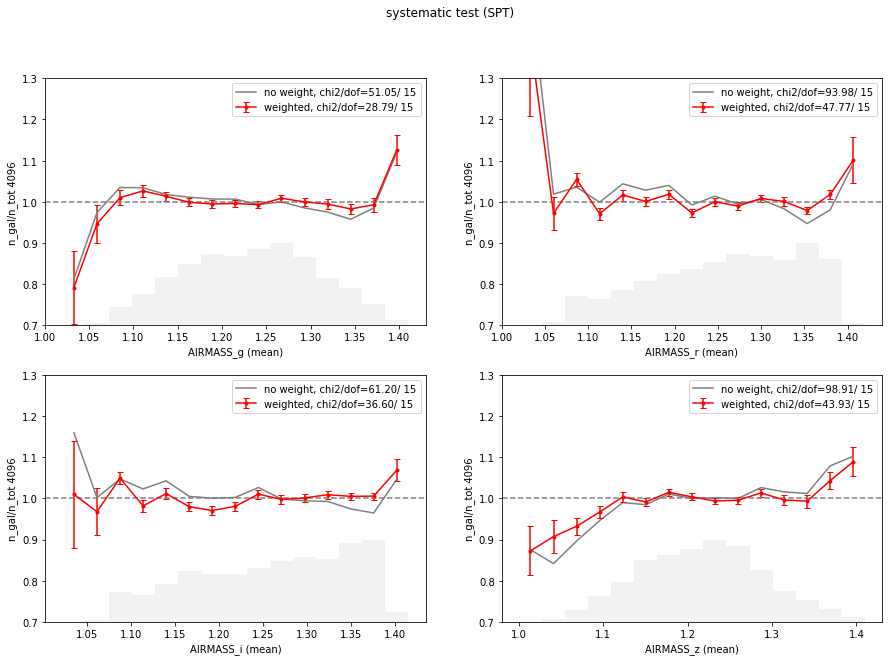

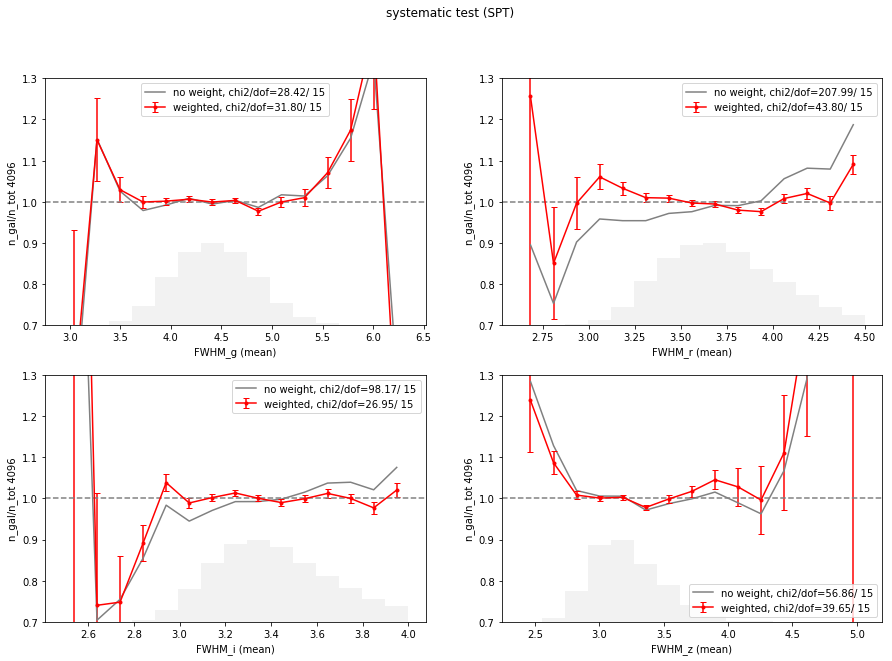

In [157]:
from systematics_module.contCorrection import plot_sysweight
for pr in properties:
    plot_sysweight(property = pr, nside = 4096, kind = 'SPT', 
               suffix1='1', suffix2=suffix, inputdir1 = inputdir, inputdir2 = inputdir, outdir=figoutdir)

